In [ ]:
# Install dalib, a library for domain adaptation, which has convenient implementations
!pip install dalib -q

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.autograd import Function
import torch.optim as optim
from dalib.modules.grl import GradientReverseLayer
from dalib.adaptation.cdan import ConditionalDomainAdversarialLoss # Corrected import

import numpy as np
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"BHAI, GPU READY HAI: {device}")

/tmp/ipython-input-2817144069.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


BHAI, GPU READY HAI: cuda


In [ ]:
import torch
import os

# This script assumes your trained models are named:
# - source_only_model
# - mmd_model
# - cdan_model
# - dann_model

print("--- Saving Trained Models ---")

# --- 1. Define the save path in your Google Drive ---
SAVE_PATH = '/content/drive/MyDrive/MyModels/'
os.makedirs(SAVE_PATH, exist_ok=True) # Create the directory if it doesn't exist

# --- 2. Define the full file paths for each model ---
source_model_path = os.path.join(SAVE_PATH, 'source_only_model.pth')
mmd_model_path = os.path.join(SAVE_PATH, 'mmd_model.pth')
cdan_model_path = os.path.join(SAVE_PATH, 'cdan_model.pth')
dann_model_path = os.path.join(SAVE_PATH, 'dann_model.pth') # Added path for DANN model

try:
    # --- 3. Save the state_dict for each model --

    print(f"Saving DANN model to: {dann_model_path}")
    torch.save(dann_model.state_dict(), dann_model_path)

    print("\n✅ All models have been saved successfully to Google Drive.")

except NameError as e:
    print(f"\n❌ ERROR: Could not save models. A model variable is not defined.")
    print(f"   Please ensure 'source_only_model', 'mmd_model', 'cdan_model', and 'dann_model' exist before running this cell.")
    print(f"   Details: {e}")



--- Saving Trained Models ---
Saving DANN model to: /content/drive/MyDrive/MyModels/dann_model.pth

❌ ERROR: Could not save models. A model variable is not defined.
   Please ensure 'source_only_model', 'mmd_model', 'cdan_model', and 'dann_model' exist before running this cell.
   Details: name 'dann_model' is not defined


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset

# --- 1. Define Paths and Parameters ---
# The base path to your PACS data inside Google Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/PACS/pacs_data/pacs_data'

# The domain to be excluded from sources and used as the target
TARGET_DOMAIN = 'sketch'

# Standard parameters
NUM_CLASSES = 7
BATCH_SIZE = 32
# NEW: Define split ratios
train_ratio = 0.70
val_ratio = 0.15
# test_ratio will be the remainder

# --- 2. Define Image Transformations ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    normalize,
])
# Validation and Test transforms are usually the same (no augmentation)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# --- 3. Automatically Detect Source Domains ---
all_domains = [d for d in os.listdir(DRIVE_BASE_PATH) if os.path.isdir(os.path.join(DRIVE_BASE_PATH, d))]
SOURCE_DOMAINS = [d for d in all_domains if d != TARGET_DOMAIN]

print(f"✅ Detected Source Domains: {SOURCE_DOMAINS}")
print(f"🎯 Set Target Domain: {TARGET_DOMAIN}")

# --- 4. Create Datasets with Train/Validation/Test Split ---
source_train_subsets = []
source_val_subsets = []
source_test_subsets = []

print("\nSplitting data for each source domain (70% train, 15% val, 15% test)...")
for domain in SOURCE_DOMAINS:
    domain_path = os.path.join(DRIVE_BASE_PATH, domain)

    # Create two versions of the full dataset with different transforms
    full_dataset_train = datasets.ImageFolder(domain_path, transform=transform_train)
    full_dataset_val_test = datasets.ImageFolder(domain_path, transform=transform_val_test)

    # Calculate split lengths
    total_size = len(full_dataset_train)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    # Split the indices into three sets
    indices = range(total_size)
    train_indices, val_indices, test_indices = random_split(
        indices,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create subsets using the correct indices AND the correct transforms
    source_train_subsets.append(Subset(full_dataset_train, train_indices))
    source_val_subsets.append(Subset(full_dataset_val_test, val_indices))
    source_test_subsets.append(Subset(full_dataset_val_test, test_indices))

# Combine all source subsets into final datasets
combined_source_train_dataset = ConcatDataset(source_train_subsets)
combined_source_val_dataset = ConcatDataset(source_val_subsets)
combined_source_test_dataset = ConcatDataset(source_test_subsets)

# --- Do the same split for the Target Domain ---
print(f"Splitting data for the target domain ('{TARGET_DOMAIN}')...")
target_path = os.path.join(DRIVE_BASE_PATH, TARGET_DOMAIN)
target_full_train = datasets.ImageFolder(target_path, transform=transform_train)
target_full_val_test = datasets.ImageFolder(target_path, transform=transform_val_test)

total_size = len(target_full_train)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(
    range(total_size),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

target_train_dataset = Subset(target_full_train, train_indices)
target_val_dataset = Subset(target_full_val_test, val_indices)
target_test_dataset = Subset(target_full_val_test, test_indices)

# --- 5. Create DataLoaders ---
source_train_loader = DataLoader(combined_source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
source_val_loader = DataLoader(combined_source_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
source_test_loader = DataLoader(combined_source_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

target_train_loader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
target_val_loader = DataLoader(target_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
target_test_loader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- 6. Verification ---
print("\n--- Corrected DataLoader Summary (Train/Val/Test) ---")
print(f"Total Combined Source Train Samples: {len(combined_source_train_dataset)}")
print(f"Total Combined Source Validation Samples: {len(combined_source_val_dataset)}")
print(f"Total Combined Source Test Samples: {len(combined_source_test_dataset)}")
print("-" * 30)
print(f"Total Target ('{TARGET_DOMAIN}') Train Samples: {len(target_train_dataset)}")
print(f"Total Target ('{TARGET_DOMAIN}') Validation Samples: {len(target_val_dataset)}")
print(f"Total Target ('{TARGET_DOMAIN}') Test Samples: {len(target_test_dataset)}")
print("\n✅ Setup Complete. Train, Validation, and Test sets are now properly separated.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PACS/pacs_data/pacs_data'

In [ ]:
!pip install datasets

In [ ]:
import torch
import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

# --- 1. Define Parameters for PACS ---
# The dataset will be downloaded automatically by the 'datasets' library
DATASET_NAME = 'flwrlabs/pacs'

# PACS domains: 'art_painting', 'cartoon', 'photo', 'sketch'
TARGET_DOMAIN = 'sketch'
DOMAIN_KEY = 'domain'    # The column name that specifies the domain

# Standard parameters
NUM_CLASSES = 7
BATCH_SIZE = 32
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
# test_ratio will be the remainder (0.15)

# --- 2. Define Image Transformations ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def apply_transforms(batch, transform):
    """Applies transformations to a batch of images."""
    batch['pixel_values'] = [transform(image.convert("RGB")) for image in batch['image']]
    return batch

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    normalize,
])
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# --- 3. Load and Filter Datasets ---
print(f"Loading '{DATASET_NAME}' dataset from the Hugging Face Hub...")
full_dataset = datasets.load_dataset(DATASET_NAME)['train']

all_domains = full_dataset.unique(DOMAIN_KEY)
SOURCE_DOMAINS = [d for d in all_domains if d != TARGET_DOMAIN]
SOURCE_DOMAINS = [SOURCE_DOMAINS[0]]

print(f"✅ Detected Source Domains: {SOURCE_DOMAINS}")
print(f"🎯 Set Target Domain: {TARGET_DOMAIN}")

source_dataset = full_dataset.filter(lambda x: x[DOMAIN_KEY] in SOURCE_DOMAINS)
target_dataset = full_dataset.filter(lambda x: x[DOMAIN_KEY] == TARGET_DOMAIN)

# --- 4. Split Datasets into Train, Validation, and Test ---
print("\nSplitting source and target domains (70% train, 15% val, 15% test)...")
source_train_val = source_dataset.train_test_split(test_size=(val_ratio + (1-train_ratio-val_ratio)), seed=42)
source_val_test = source_train_val['test'].train_test_split(test_size=0.5, seed=42)
source_train_dataset = source_train_val['train']
source_val_dataset = source_val_test['train']
source_test_dataset = source_val_test['test']

target_train_val = target_dataset.train_test_split(test_size=(val_ratio + (1-train_ratio-val_ratio)), seed=42)
target_val_test = target_train_val['test'].train_test_split(test_size=0.5, seed=42)
target_train_dataset = target_train_val['train']
target_val_dataset = target_val_test['train']
target_test_dataset = target_val_test['test']

# --- 5. Apply Transformations to the Datasets ---
source_train_dataset.set_transform(lambda batch: apply_transforms(batch, transform_train))
source_val_dataset.set_transform(lambda batch: apply_transforms(batch, transform_val_test))
source_test_dataset.set_transform(lambda batch: apply_transforms(batch, transform_val_test))

target_train_dataset.set_transform(lambda batch: apply_transforms(batch, transform_train))
target_val_dataset.set_transform(lambda batch: apply_transforms(batch, transform_val_test))
target_test_dataset.set_transform(lambda batch: apply_transforms(batch, transform_val_test))

# --- 6. Create DataLoaders (FIXED) ---
def collate_fn(batch):
    """Custom collate function to stack tensors from the dataset."""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

# Add drop_last=True to the training loaders to ensure consistent batch sizes
source_train_loader = DataLoader(
    source_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    drop_last=True  # <-- FIX: Prevents mismatched batch sizes
)
target_train_loader = DataLoader(
    target_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    drop_last=True  # <-- FIX: Prevents mismatched batch sizes
)

# Validation and test loaders do not need drop_last=True
source_val_loader = DataLoader(source_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
source_test_loader = DataLoader(source_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
target_val_loader = DataLoader(target_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
target_test_loader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)


# --- 7. Verification ---
print("\n--- PACS DataLoader Summary (Train/Val/Test) ---")
print(f"Total Combined Source Train Samples: {len(source_train_dataset)}")
print(f"Total Combined Source Validation Samples: {len(source_val_dataset)}")
print(f"Total Combined Source Test Samples: {len(source_test_dataset)}")
print("-" * 30)
print(f"Total Target ('{TARGET_DOMAIN}') Train Samples: {len(target_train_dataset)}")
print(f"Total Target ('{TARGET_DOMAIN}') Validation Samples: {len(target_val_dataset)}")
print(f"Total Target ('{TARGET_DOMAIN}') Test Samples: {len(target_test_dataset)}")
print("\n✅ Setup Complete using 'datasets' library for PACS.")


Loading 'flwrlabs/pacs' dataset from the Hugging Face Hub...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Detected Source Domains: ['art_painting']
🎯 Set Target Domain: sketch

Splitting source and target domains (70% train, 15% val, 15% test)...

--- PACS DataLoader Summary (Train/Val/Test) ---
Total Combined Source Train Samples: 1433
Total Combined Source Validation Samples: 307
Total Combined Source Test Samples: 308
------------------------------
Total Target ('sketch') Train Samples: 2750
Total Target ('sketch') Validation Samples: 589
Total Target ('sketch') Test Samples: 590

✅ Setup Complete using 'datasets' library for PACS.


In [ ]:
from torchvision.models import resnet50

###############
#ARCHITECTURE WILL BE A SIMPLE RESNET 50 BACKBONE , FOLLOWED WITH A 2 LAYER RELU LAYER"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Assuming GradientReverseLayer is defined from a previous cell

class Net(nn.Module):
    def __init__(self, output_features, mode='dann', pretrained=True):
        super(Net, self).__init__()

        self.mode = mode

        # --- Feature Extractor ---
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten())
        self.num_features = resnet.fc.in_features

        # --- Classifier (No changes here) ---
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_features)

        )

        # --- GRL ---
        self.grl = GradientReverseLayer()

        # --- UPGRADED Discriminators ---
        # Deeper architecture with LeakyReLU for more stable gradients

        if self.mode == 'dann':
            # DANN discriminator takes features directly.
            input_size = self.num_features
        elif self.mode == 'cdan':
            # CDAN discriminator takes the product of features and class predictions.
            input_size = self.num_features * output_features

        self.discriminator = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        # Forward pass remains the same, as the logic is handled by the new discriminator architecture
        features = self.feature_extractor(x)
        class_outputs = self.classifier(features)

        reversed_features = self.grl(features, alpha)

        if self.mode == 'dann':
            domain_output = self.discriminator(reversed_features)
        elif self.mode == 'cdan':
            softmax_out = F.softmax(class_outputs, dim=1)
            combined_input = torch.bmm(softmax_out.unsqueeze(2), reversed_features.unsqueeze(1))
            domain_output = self.discriminator(combined_input.view(-1, self.num_features * class_outputs.size(1)))

        return class_outputs, domain_output

In [ ]:
import torch
import os

# --- 1. Define a directory to save the models ---
# It's a good practice to save models in a dedicated folder.
# If you are using Google Colab, you might want to save to your Drive.
# e.g., SAVE_PATH = '/content/drive/MyDrive/MyModels/'
SAVE_PATH = '/content/drive/MyDrive/MyModels/'
os.makedirs(SAVE_PATH, exist_ok=True) # Create the directory if it doesn't exist

# --- 2. Save each model's state_dict ---
# This assumes your trained models are named:
# - source_only_model (for the baseline)
# - mmd_model (for the DAN/MMD model)
# - cdan_model (for the DANN/CDAN model)

# Define the file paths
source_model_path = os.path.join(SAVE_PATH, 'source_only_model.pth')
mmd_model_path = os.path.join(SAVE_PATH, 'mmd_model.pth')
dan_model_path = os.path.join(SAVE_PATH, 'dann_model.pth')

# Save the state dictionaries
# The state_dict contains all the learned weights and biases of the model.

print(f"Saving CDAN model to: {dan_model_path}")
torch.save(dann_.state_dict(), dan_model_path)
print(f"Saving source-only model to: {source_model_path}")
torch.save(normal.state_dict(), source_model_path)

print(f"Saving MMD model to: {mmd_model_path}")
torch.save(mmd_model.state_dict(), mmd_model_path)


print("\n✅ All models have been saved successfully.")


Saving CDAN model to: /content/drive/MyDrive/MyModels/cdan_model.pth
Saving source-only model to: /content/drive/MyDrive/MyModels/source_only_model.pth


NameError: name 'normal' is not defined

In [ ]:
plt.plot(loss)

In [ ]:
import torch
import torch.nn as nn

# This function is the core of the MMD calculation, implementing the Gaussian kernel trick.
def _guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0]) + int(target.size()[0])
    total = torch.cat([source, target], dim=0)

    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))

    # Calculate the L2 distance between every pair of features
    L2_distance = ((total0-total1)**2).sum(2)

    # Calculate bandwidth for the Gaussian kernel
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)

    # Use multiple kernels to capture different scales of similarity
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    # Apply the kernel function
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val)

class MMDLoss(nn.Module):
    """
    The Maximum Mean Discrepancy (MMD) loss function.
    """
    def __init__(self, kernel_mul=2.0, kernel_num=5):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = _guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num)

        # Split the kernel matrix into source-source, target-target, and source-target parts
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]

        # Calculate the MMD loss
        loss = torch.mean(XX + YY - XY - YX)
        return loss

In [ ]:
##classic
normal = Net(7,'dann').to(device)
# This assumes the Net class is already defined and device is set

epochs = 10 # Set number of epochs
normal = Net(output_features=7, mode='dann').to(device) # Your Net class

# Correctly referencing the model's parameters
optimizer = optim.Adam(
    list(normal.feature_extractor.parameters()) + list(normal.classifier.parameters()),
    lr=1e-4
)

# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
##HUGGINGFACE PACS
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import torch # Make sure torch is imported

# --- Assuming 'normal', 'optimizer', 'criterion', 'device', etc. are defined ---
epochs = 5 # Example value
class_names = np.arange(7)

# Lists to store features from each epoch
latent_source_per_epoch = []
latent_target_per_epoch = []
losses = []

print("--- Starting Source-Only Baseline Training ---")
for epoch in range(epochs):
    normal.train()
    pbar = tqdm(source_train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    running_loss = 0.0

    # --- CORRECTED TRAINING LOOP ---
    for batch in pbar:
        # Get images and labels from the dictionary
        images = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass with alpha=0
        class_outputs, _ = normal(images, alpha=0)

        loss = criterion(class_outputs, labels)
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'loss': loss.item()})
        running_loss+=loss.item()

    # --- End of Epoch: Store Latent Features from Test Sets ---
    normal.eval()
    running_loss = running_loss / len(source_train_loader)
    losses.append( running_loss)
    with torch.no_grad():
        # --- CORRECTED SOURCE TEST LOOP ---
        epoch_source_features = []
        # Note: The source test loader also yields a dictionary
        for s_batch in source_test_loader:
            s_images = s_batch['pixel_values'].to(device)
            features = normal.feature_extractor(s_images)
            epoch_source_features.append(features.cpu().numpy())
        latent_source_per_epoch.append(np.concatenate(epoch_source_features))

        # --- CORRECTED TARGET TEST LOOP ---
        epoch_target_features = []
        # Note: The target test loader also yields a dictionary
        for t_batch in target_test_loader:
            t_images = t_batch['pixel_values'].to(device)
            features = normal.feature_extractor(t_images)
            epoch_target_features.append(features.cpu().numpy())
        latent_target_per_epoch.append(np.concatenate(epoch_target_features))

    print(f"Epoch {epoch+1} complete. Latent features from test sets stored.")

print("\n✅ Training Finished.")

--- Starting Source-Only Baseline Training ---


Epoch 1/5 [Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1 complete. Latent features from test sets stored.


Epoch 2/5 [Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2 complete. Latent features from test sets stored.


Epoch 3/5 [Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3 complete. Latent features from test sets stored.


Epoch 4/5 [Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4 complete. Latent features from test sets stored.


Epoch 5/5 [Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5 complete. Latent features from test sets stored.

✅ Training Finished.


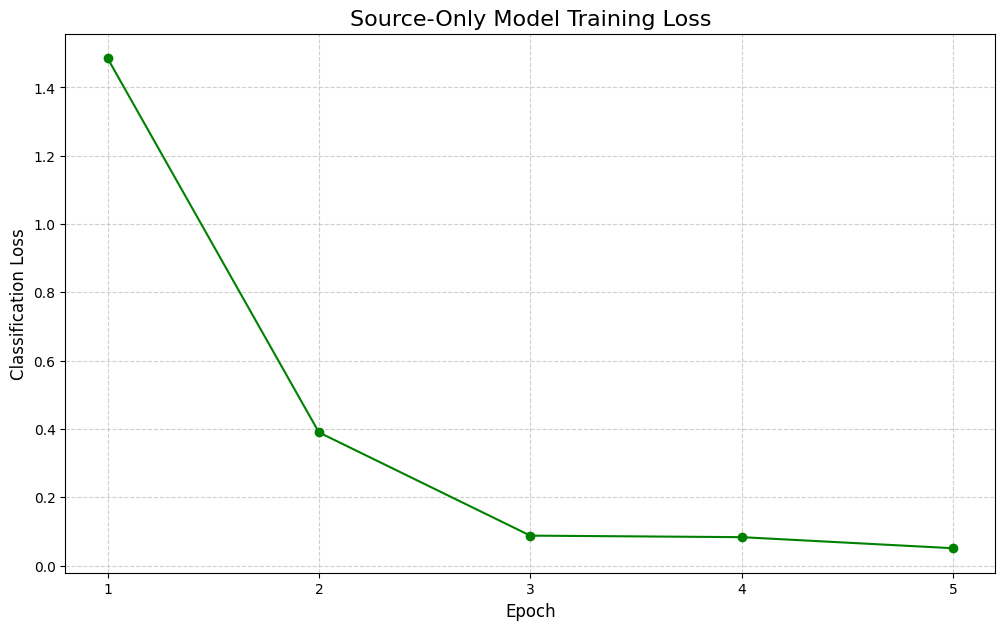

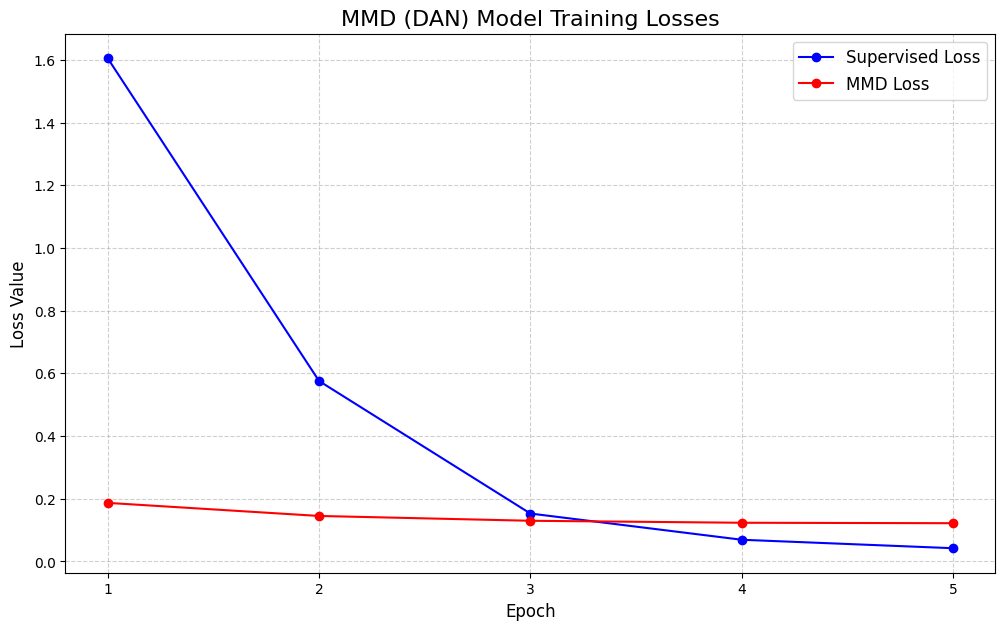

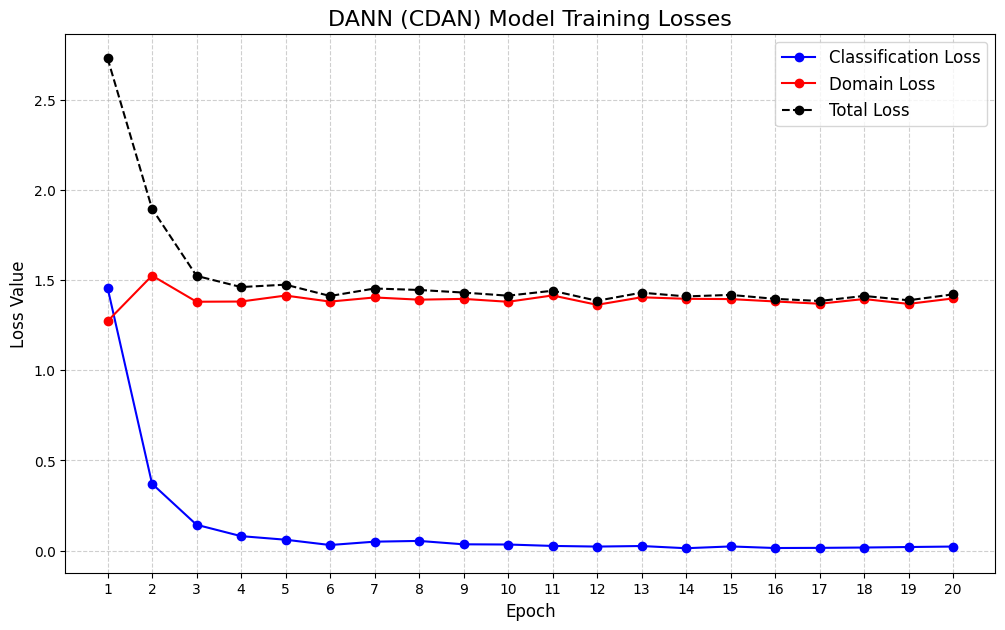

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# This script assumes the following lists have been populated from your training runs:
# - losses: From the source-only baseline model.
# - losses_sup, losses_mmd: From the MMD (DAN) model.
# - losses_s_dann, losses_d_dann, losses_dann: From the DANN (CDAN) model.

# --- Dummy Data (for demonstration purposes) ---
# In your notebook, these variables should already exist.
# This is just to make the script runnable as a standalone example.
if 'losses' not in locals():
    print("Generating dummy data for plotting demonstration...")
    epochs = 20
    losses = np.exp(-np.arange(epochs) * 0.2) + np.random.rand(epochs) * 0.1
    losses_sup = np.exp(-np.arange(epochs) * 0.25) + np.random.rand(epochs) * 0.08
    losses_mmd = 0.5 * np.exp(-np.arange(epochs) * 0.1) + np.random.rand(epochs) * 0.05
    losses_s_dann = np.exp(-np.arange(epochs) * 0.15) + np.random.rand(epochs) * 0.1
    losses_d_dann = 0.7 - 0.2 * np.exp(-np.arange(epochs) * 0.1) + np.random.rand(epochs) * 0.05
    losses_dann = np.array(losses_s_dann) + np.array(losses_d_dann)
# --- End of Dummy Data ---


# ===================================================================
# 1. Plot for Source-Only (Normal) Model
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='green')
plt.title('Source-Only Model Training Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Classification Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, len(losses) + 1))
plt.show()


# ===================================================================
# 2. Plot for MMD (DAN) Model
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(losses_sup) + 1), losses_sup, marker='o', linestyle='-', color='blue', label='Supervised Loss')
plt.plot(range(1, len(losses_mmd) + 1), losses_mmd, marker='o', linestyle='-', color='red', label='MMD Loss')
plt.title('MMD (DAN) Model Training Losses', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, len(losses_sup) + 1))
plt.legend(fontsize=12)
plt.show()


# ===================================================================
# 3. Plot for DANN (CDAN) Model
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(losses_s_dann) + 1), losses_s_dann, marker='o', linestyle='-', color='blue', label='Classification Loss')
plt.plot(range(1, len(losses_d_dann) + 1), losses_d_dann, marker='o', linestyle='-', color='red', label='Domain Loss')
plt.plot(range(1, len(losses_dann) + 1), losses_dann, marker='o', linestyle='--', color='black', label='Total Loss')
plt.title('DANN (CDAN) Model Training Losses', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, len(losses_s_dann) + 1))
plt.legend(fontsize=12)
plt.show()


In [ ]:
###HUGGING FACE VERSION
import torch
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# --- FINAL Analysis for Source-Only Model (Accuracy, F1, t-SNE) ---

# ===================================================================
# 1. HELPER FUNCTIONS (Corrected)
# ===================================================================

def evaluate_accuracy(model, dataloader, device):
    """Helper function to calculate accuracy for a given model and dataloader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        # CORRECTED LOOP: Handle dictionary batch
        for batch in dataloader:
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs, _ = model(images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_tsne(source_features, target_features, source_labels, target_labels, num_samples=2000, perplexity=30):
    """Performs t-SNE on a subset of the data and plots the results."""
    print("\nRunning t-SNE on a random subset of samples... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    total_points = len(all_features)
    indices = np.random.permutation(total_points)[:min(num_samples, total_points)]

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space at Final Epoch', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10, alpha=0.7)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10, alpha=0.7)
    handles, _ = scatter2.legend_elements(num=len(class_names))
    ax2.legend(handles=handles, labels=list(class_names))
    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. MAIN ANALYSIS SCRIPT (Corrected)
# ===================================================================

print("--- Final Evaluation and Visualization for Source-Only Model ---")

normal.eval()

# --- Part 1: Calculate and Print Accuracies ---
source_test_accuracy = evaluate_accuracy(normal, source_test_loader, device)
print(f"Final Accuracy on Combined Source Test Set: {source_test_accuracy:.2f}%")

target_test_accuracy = evaluate_accuracy(normal, target_test_loader, device)
print(f"Final Accuracy on Target ('{TARGET_DOMAIN}') Test Set: {target_test_accuracy:.2f}%")


# --- Part 2: Calculate and Plot F1 Scores for Target Test Set ---
final_preds = []
final_labels = []
with torch.no_grad():
    # CORRECTED LOOP: Handle dictionary batch
    for batch in tqdm(target_test_loader, desc="Calculating F1 Scores"):
        images = batch['pixel_values'].to(device)
        labels = batch['labels'] # Keep labels on CPU for numpy conversion

        class_outputs, _ = normal(images, alpha=0)
        preds = torch.argmax(class_outputs, dim=1)
        final_preds.append(preds.cpu().numpy())
        final_labels.append(labels.numpy())

final_preds = np.concatenate(final_preds)
final_labels = np.concatenate(final_labels)

f1s = f1_score(final_labels, final_preds, average=None, labels=range(len(class_names)), zero_division=0)
print(f"Average F1 Score on '{TARGET_DOMAIN}' Test Set: {f1s.mean():.4f}\n")

plt.figure(figsize=(12, 6))
plt.bar(class_names, f1s, color='coral')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title(f"Source-Only Model: F1 Scores on '{TARGET_DOMAIN}' Test Set (Final)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


# --- Part 3: Extract Current Features and Display t-SNE ---
print("\n--- Generating t-SNE Plot of Final Latent Features ---")
with torch.no_grad():
    print("Extracting source test features...")
    # CORRECTED LOOP: Handle dictionary batch in list comprehension
    current_source_features = np.concatenate(
        [normal.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(source_test_loader, leave=False)]
    )
    print("Extracting target test features...")
    # CORRECTED LOOP: Handle dictionary batch in list comprehension
    current_target_features = np.concatenate(
        [normal.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(target_test_loader, leave=False)]
    )

# CORRECTED LOOP: Handle dictionary batch to get labels
source_test_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
target_test_labels = np.concatenate([batch['labels'].numpy() for batch in target_test_loader])

plot_tsne(
    current_source_features,
    current_target_features,
    source_test_labels,
    target_test_labels
)

print("\n✅ Final Analysis Complete.")


--- Final Evaluation and Visualization for Source-Only Model ---


NameError: name 'normal' is not defined

In [ ]:
##MMD: All else is the same , but the loss now includes Lmmd . pass the Xsource through the whole network, however, now we're also going to pass in Xtarget, which will only go through the backbone , then , mmd between Zsource and Ztarget will be calculated

##classic
mmd = Net(7,'dann').to(device)
# This assumes the Net class is already defined and device is set

epochs = 5 # Set number of epochs

# Correctly referencing the model's parameters
optimizer = optim.Adam(
    list(mmd.feature_extractor.parameters()) + list(mmd.classifier.parameters()),
    lr=1e-4
)

# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm

# This script assumes the following are already defined:
# - Net: Your model class
# - MMDLoss: Your MMD loss class
# - source_train_loader, target_train_loader: Your DataLoaders
# - device: Your torch device ('cuda' or 'cpu')

# --- Model and Optimizer Setup ---
epochs = 5
mmd_model = Net(output_features=7, mode='dann').to(device)
optimizer = optim.Adam(
    list(mmd_model.feature_extractor.parameters()) + list(mmd_model.classifier.parameters()),
    lr=1e-4
)

# --- Loss Functions ---
cls_criterion = nn.CrossEntropyLoss()
mmd_criterion = MMDLoss().to(device)
losses_mmd = []
losses_sup = []
# --- Hyperparameter ---
lambda_mmd = 1.0

# --- Training Loop (Corrected) ---
print("--- Starting MMD (DAN) Training ---")
for epoch in range(epochs):
    mmd_model.train()
    running_loss_s = 0.0
    running_loss_m = 0.0
    len_dataloader = min(len(source_train_loader), len(target_train_loader))
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)

    pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{epochs} [MMD Training]")

    for _ in pbar:
        # --- CORRECTED DATA LOADING ---
        # Get the batch dictionary from each iterator
        source_batch = next(iter_source)
        target_batch = next(iter_target)

        # Extract tensors from the dictionaries using their keys
        source_images = source_batch['pixel_values'].to(device)
        source_labels = source_batch['labels'].to(device)
        target_images = target_batch['pixel_values'].to(device)
        # We don't need target labels for MMD, so we don't extract them

        optimizer.zero_grad()

        # --- FORWARD PASS ---
        source_features = mmd_model.feature_extractor(source_images)
        source_class_outputs = mmd_model.classifier(source_features)
        target_features = mmd_model.feature_extractor(target_images)

        # --- LOSS CALCULATION ---
        cls_loss = cls_criterion(source_class_outputs, source_labels)
        mmd_loss = mmd_criterion(source_features, target_features)
        total_loss = cls_loss + (lambda_mmd * mmd_loss)

        # --- BACKPROPAGATION ---
        total_loss.backward()
        optimizer.step()
        running_loss_s+= cls_loss.item()
        running_loss_m+=mmd_loss.item()

        pbar.set_postfix({'cls_loss': cls_loss.item(), 'mmd_loss': mmd_loss.item()})
    losses_mmd.append(running_loss_m / len_dataloader)
    losses_sup.append(running_loss_s / len_dataloader)


print("\n✅ MMD (DAN) Training Finished.")


--- Starting MMD (DAN) Training ---


Epoch 1/5 [MMD Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/5 [MMD Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/5 [MMD Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/5 [MMD Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/5 [MMD Training]:   0%|          | 0/44 [00:00<?, ?it/s]


✅ MMD (DAN) Training Finished.


In [ ]:
print(losses_sup)

[1.1707216175163493, 0.24880363695761737, 0.12519547308192533, 0.09252687594031586, 0.0736127599964247]


In [ ]:
import torch
import collections
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# ===================================================================
# 1. HELPER FUNCTIONS (Corrected Again)
# ===================================================================

def print_class_distribution(dataset, class_names, title):
    """
    Helper function rewritten to be more robust.
    It manually iterates through the untransformed dataset to collect labels,
    avoiding internal library errors.
    """
    print(f"\n--- Class Population for: {title} ---")
    # Temporarily access the dataset without any transforms
    untransformed_dataset = dataset.with_transform(None)

    # Manually iterate to collect labels safely
    labels = []
    for item in untransformed_dataset:
        labels.append(item['label'])

    class_counts = collections.Counter(labels)
    for i, name in enumerate(class_names):
        print(f"  - Class {name}: {class_counts.get(i, 0)} samples")

def plot_tsne(source_features, target_features, source_labels, target_labels, epoch, num_samples=2000, perplexity=30):
    """Performs t-SNE on a subset of the data and plots the results."""
    print("\nRunning t-SNE on a random subset of samples... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    total_points = len(all_features)
    indices = np.random.permutation(total_points)[:min(num_samples, total_points)]

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space at Final Epoch', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10, alpha=0.7)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10, alpha=0.7)
    handles, _ = scatter2.legend_elements(num=len(class_names) if 'class_names' in globals() else 7)
    ax2.legend(handles=handles, labels=list(class_names) if 'class_names' in globals() else [str(i) for i in range(7)])
    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. MAIN ANALYSIS SCRIPT (No changes needed here)
# ===================================================================

print("--- Final Evaluation and Visualization for MMD (DAN) Model ---")

# --- Part 1: Calculate Metrics on Target Test Set ---
mmd_model.eval()
final_preds = []
final_labels = []
with torch.no_grad():
    for batch in tqdm(target_test_loader, desc="Evaluating on Target (Sketch)"):
        images = batch['pixel_values'].to(device)
        labels = batch['labels']
        class_outputs, _ = mmd_model(images, alpha=0)
        preds = torch.argmax(class_outputs, dim=1)
        final_preds.append(preds.cpu().numpy())
        final_labels.append(labels.numpy())

final_preds = np.concatenate(final_preds)
final_labels = np.concatenate(final_labels)

acc = accuracy_score(final_preds, final_labels)
# Define class_names if it's not defined
if 'class_names' not in globals():
    class_names = [str(i) for i in range(np.max(final_labels) + 1)]
f1s = f1_score(final_labels, final_preds, average=None, labels=range(len(class_names)), zero_division=0)

print(f"\nFinal Accuracy on Sketch Test Set: {acc:.2%}")
print(f"Average F1 Score on Sketch Test Set: {f1s.mean():.4f}")

# --- Part 2: Display F1 Histogram and Class Populations ---
plt.figure(figsize=(12, 6))
plt.bar(class_names, f1s, color='coral')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title(f'MMD (DAN) Model: F1 Scores on Sketch Test Set (Final)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



# --- Part 3: Extract Current Features and Display t-SNE ---
print("\n--- Generating t-SNE Plot of Final Latent Features ---")
with torch.no_grad():
    print("Extracting source test features...")
    current_source_features = np.concatenate(
        [mmd_model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(source_test_loader, leave=False)]
    )
    print("Extracting target test features...")
    current_target_features = np.concatenate(
        [mmd_model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(target_test_loader, leave=False)]
    )

source_test_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
target_test_labels = np.concatenate([batch['labels'].numpy() for batch in target_test_loader])

plot_tsne(
    current_source_features,
    current_target_features,
    source_test_labels,
    target_test_labels,
    epoch=(epochs-1 if 'epochs' in locals() else 0)
)

print("\n✅ Final Analysis Complete.")


--- Final Evaluation and Visualization for MMD (DAN) Model ---


NameError: name 'mmd_model' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.manifold import TSNE
from tqdm.autonotebook import tqdm

# This script assumes the following are defined from previous cells:
# - Net: Your model class
# - MMDLoss: Your MMD loss class
# - source_train_loader, source_test_loader: DataLoaders for source domain
# - target_train_loader, target_test_loader: DataLoaders for target domain
# - device: Your torch device ('cuda' or 'cpu')
# - class_names: A list or array of your class names

# ===================================================================
# 1. HELPER FUNCTIONS (for final evaluation)
# ===================================================================

def plot_tsne(source_features, target_features, source_labels, target_labels, title):
    """Performs t-SNE on a subset of the data and plots the results."""
    print(f"\nRunning t-SNE for {title}... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    # Use a random subset to speed up t-SNE
    num_samples = 2000
    total_points = len(all_features)
    indices = np.random.permutation(total_points)[:min(num_samples, total_points)]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space for {title}', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10, alpha=0.7)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10, alpha=0.7)
    handles, _ = scatter2.legend_elements(num=len(class_names))
    ax2.legend(handles=handles, labels=list(class_names))
    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. EXPERIMENT SETUP
# ===================================================================

epochs = 5
learning_rate = 1e-4

# Define the different lambda values to test
experiments = {
    "MMD (λ=0.2)": 0.2,
    "MMD (λ=0.4)": 0.4,
    "MMD (λ=0.6)": 0.6,
    "MMD (λ=0.8)": 0.8,
    "MMD (λ=Schedule)": 'schedule' # Special key for the scheduled lambda
}

results = {} # Dictionary to store results from all experiments

# ===================================================================
# 3. MAIN TRAINING AND EVALUATION LOOP
# ===================================================================

for name, lambda_setting in experiments.items():
    print(f"\n{'='*20}\n--- Starting Training for: {name} ---\n{'='*20}")

    # --- Instantiate a fresh model and optimizer for each experiment ---
    model = Net(output_features=len(class_names), mode='dann').to(device)
    optimizer = optim.Adam(
        list(model.feature_extractor.parameters()) + list(model.classifier.parameters()),
        lr=learning_rate
    )
    cls_criterion = nn.CrossEntropyLoss()
    mmd_criterion = MMDLoss().to(device)

    # --- Training Loop ---
    len_dataloader = min(len(source_train_loader), len(target_train_loader))
    total_steps = epochs * len_dataloader

    for epoch in range(epochs):
        model.train()
        iter_source = iter(source_train_loader)
        iter_target = iter(target_train_loader)
        pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{epochs} [{name}]")

        for step in pbar:
            # --- Handle Lambda Schedule ---
            if lambda_setting == 'schedule':
                p = float(epoch * len_dataloader + step) / total_steps
                lambda_mmd = (2. / (1. + np.exp(-10 * p)) - 1)
            else:
                lambda_mmd = lambda_setting

            # --- Data Loading ---
            source_batch = next(iter_source)
            target_batch = next(iter_target)
            source_images = source_batch['pixel_values'].to(device)
            source_labels = source_batch['labels'].to(device)
            target_images = target_batch['pixel_values'].to(device)

            # --- Forward Pass, Loss, and Backward Pass ---
            optimizer.zero_grad()
            source_features = model.feature_extractor(source_images)
            source_class_outputs = model.classifier(source_features)
            target_features = model.feature_extractor(target_images)

            cls_loss = cls_criterion(source_class_outputs, source_labels)
            mmd_loss = mmd_criterion(source_features, target_features)
            total_loss = cls_loss + (lambda_mmd * mmd_loss)

            total_loss.backward()
            optimizer.step()
            pbar.set_postfix({'cls_loss': cls_loss.item(), 'mmd_loss': mmd_loss.item(), 'λ': lambda_mmd})

    print(f"✅ Training finished for {name}.")

    # --- Final Evaluation for this model ---
    model.eval()
    final_preds, final_labels = [], []
    with torch.no_grad():
        for batch in tqdm(target_test_loader, desc=f"Evaluating {name}"):
            images = batch['pixel_values'].to(device)
            labels = batch['labels']
            class_outputs, _ = model(images, alpha=0)
            preds = torch.argmax(class_outputs, dim=1)
            final_preds.append(preds.cpu().numpy())
            final_labels.append(labels.numpy())

    final_preds = np.concatenate(final_preds)
    final_labels = np.concatenate(final_labels)

    # --- Store all results for later analysis ---
    results[name] = {
        'accuracy': accuracy_score(final_labels, final_preds),
        'f1_scores': f1_score(final_labels, final_preds, average=None, labels=range(len(class_names)), zero_division=0),
        'model_state': model.state_dict() # Save the trained model's weights
    }

# ===================================================================
# 4. FINAL ANALYSIS AND VISUALIZATION (after all models are trained)
# ===================================================================
print(f"\n\n{'='*20}\n--- FINAL ANALYSIS OF ALL MMD MODELS ---\n{'='*20}")

for name, result in results.items():
    print(f"\n--- Results for: {name} ---")
    print(f"Final Accuracy on Sketch Test Set: {result['accuracy']:.2%}")
    print(f"Average F1 Score on Sketch Test Set: {result['f1_scores'].mean():.4f}")

    # --- Plot F1 Histogram ---
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, result['f1_scores'], color='teal')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Scores on Sketch Test Set ({name})')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Generate and Plot t-SNE ---
    # Create a temporary model and load the saved weights
    analysis_model = Net(output_features=len(class_names), mode='dann').to(device)
    analysis_model.load_state_dict(result['model_state'])
    analysis_model.eval()

    with torch.no_grad():
        source_features = np.concatenate(
            [analysis_model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in source_test_loader]
        )
        target_features = np.concatenate(
            [analysis_model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in target_test_loader]
        )
    source_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
    target_labels = np.concatenate([batch['labels'].numpy() for batch in target_test_loader])

    plot_tsne(source_features, target_features, source_labels, target_labels, title=name)



--- Starting Training for: MMD (λ=0.2) ---


NameError: name 'MMDLoss' is not defined

In [ ]:
##This is the biggie. DANN. over here , things will remian similar, except now a lambda will be defined, ad there will be 2 optimizers, for both discriminator and for the main chain. and lambda will be non zero. you will pass source and target at the same time. the source latent will go through the classifier, giving us Lsup, the tareget will go to the dsicriminator, giving us Ldom. now, with dradietn reversal active as described, store the latents at the end of every epoch and the f1 scores and then display them during testing. in the case of lambda ( or in this case alpha, you'll inject it using a schedule that doesnt go by epochs but by the number of batches processed, and based on that you'll increase it)
import torch.optim as optim
from tqdm.autonotebook import tqdm

# This assumes the Net class, data loaders, and helper functions are defined.

epochs = 15 # DANN needs a bit more time to stabilize
dann_model = Net(output_features=7, mode='dann').to(device)

# --- The Two Optimizers ---
# Optimizer for the "main chain": feature extractor and classifier
# This one tries to MINIMIZE classification loss and MAXIMIZE domain loss (due to GRL)
optimizer_main = optim.Adam(
    list(dann_model.feature_extractor.parameters()) + list(dann_model.classifier.parameters()),
    lr=1e-4
)

# Optimizer for the discriminator
# This one tries to MINIMIZE domain loss (get better at telling domains apart)
optimizer_disc = optim.Adam(dann_model.discriminator.parameters(), lr=1e-4)

# --- Loss Functions ---
cls_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCELoss()

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.autonotebook import tqdm

# This script assumes the following are defined:
# - dann_model: Your DANN model
# - source_train_loader, source_test_loader: DataLoaders
# - target_train_loader, target_val_loader, target_test_loader: DataLoaders
# - device: Your torch device
# - cls_criterion, domain_criterion: Your loss functions
# - optimizer_main, optimizer_disc: Your optimizers

# --- Setup for Per-Epoch Analysis ---
# class_names = np.arange(7) # Assuming 7 classes for PACS
# epochs = 20  # Example value

# --- Storage for per-epoch analysis ---
latent_source_per_epoch = []
latent_target_per_epoch = []
f1_scores_per_epoch = []
# NEW: Lists to store average losses per epoch
losses_dann = []      # Total loss
losses_s_dann = []    # Classification loss
losses_d_dann = []    # Domain loss

# --- Training Loop ---
print("--- Starting DANN Training ---")

# Calculate total steps for the alpha schedule
len_dataloader = min(len(source_train_loader), len(target_train_loader))
total_steps = epochs * len_dataloader

for epoch in range(epochs):
    dann_model.train()
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)

    # NEW: Accumulators for epoch losses
    epoch_total_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_domain_loss = 0.0

    pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{epochs} [DANN Training]")

    for step in pbar:
        # --- Alpha Schedule ---
        current_step = epoch * len_dataloader + step
        p = float(current_step) / total_steps
        alpha = (2. / (1. + np.exp(-10 * p)) - 1) * 1

        # --- CORRECTED DATA LOADING ---
        source_batch = next(iter_source)
        target_batch = next(iter_target)
        source_images = source_batch['pixel_values'].to(device)
        source_labels = source_batch['labels'].to(device)
        target_images = target_batch['pixel_values'].to(device)

        # Create domain labels
        source_domain_labels = torch.ones(source_images.size(0), 1, device=device)
        target_domain_labels = torch.zeros(target_images.size(0), 1, device=device)

        # --- Forward Pass ---
        s_class_out, s_domain_out = dann_model(source_images, alpha)
        _, t_domain_out = dann_model(target_images, alpha)

        # --- Loss Calculation ---
        cls_loss = cls_criterion(s_class_out, source_labels)
        domain_loss = domain_criterion(s_domain_out, 0.9*source_domain_labels) + domain_criterion(t_domain_out, target_domain_labels)
        total_loss = cls_loss + domain_loss

        # --- Backpropagation & Optimizer Steps ---
        optimizer_main.zero_grad()
        optimizer_disc.zero_grad()
        total_loss.backward()
        optimizer_main.step()
        optimizer_disc.step()

        # Update progress bar and loss accumulators
        pbar.set_postfix({'cls_loss': cls_loss.item(), 'dom_loss': domain_loss.item(), 'alpha': alpha})
        epoch_total_loss += total_loss.item()
        epoch_cls_loss += cls_loss.item()
        epoch_domain_loss += domain_loss.item()

    # --- End of Epoch: Calculate and Store Average Losses ---
    avg_total_loss = epoch_total_loss / len_dataloader
    avg_cls_loss = epoch_cls_loss / len_dataloader
    avg_domain_loss = epoch_domain_loss / len_dataloader
    losses_dann.append(avg_total_loss)
    losses_s_dann.append(avg_cls_loss)
    losses_d_dann.append(avg_domain_loss)

    # --- End of Epoch: Evaluation & Storage ---
    dann_model.eval()
    with torch.no_grad():
        # 1. Store Latent Features (CORRECTED LOOPS)
        epoch_source_features = np.concatenate(
            [dann_model.feature_extractor(s_batch['pixel_values'].to(device)).cpu().numpy() for s_batch in source_test_loader]
        )
        latent_source_per_epoch.append(epoch_source_features)

        epoch_target_features = np.concatenate(
            [dann_model.feature_extractor(t_batch['pixel_values'].to(device)).cpu().numpy() for t_batch in target_test_loader]
        )
        latent_target_per_epoch.append(epoch_target_features)

        # 2. Store F1 Scores from Target Validation Set (CORRECTED LOOP)
        val_preds, val_labels = [], []
        for batch in target_val_loader:
            images = batch['pixel_values'].to(device)
            labels = batch['labels']
            class_outputs, _ = dann_model(images, alpha=0)
            preds = torch.argmax(class_outputs, dim=1)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(labels.numpy())

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        epoch_f1s = f1_score(val_labels, val_preds, average=None, labels=range(len(class_names)), zero_division=0)
        f1_scores_per_epoch.append(epoch_f1s)

    print(f"Epoch {epoch+1} complete. Latents and F1 scores stored. Avg F1: {epoch_f1s.mean():.4f}, Avg Loss: {avg_total_loss:.4f}")
    if epoch_f1s.mean() < 0.81:
      break

print("\n✅ DANN Training Finished.")


--- Starting DANN Training ---


Epoch 1/20 [DANN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1 complete. Latents and F1 scores stored. Avg F1: 0.8278, Avg Loss: 1.3564


Epoch 2/20 [DANN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2 complete. Latents and F1 scores stored. Avg F1: 0.8030, Avg Loss: 1.3520

✅ DANN Training Finished.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.manifold import TSNE
from tqdm.autonotebook import tqdm

# This script assumes 'Net', dataloaders, 'device', and 'class_names' are defined.

# ===================================================================
# 1. HELPER FUNCTIONS FOR PER-EPOCH ANALYSIS
# ===================================================================

def evaluate_and_plot_f1(model, loader, device, class_names, title):
    """Calculates F1 scores, prints the average, and plots the histogram."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch['pixel_values'].to(device), batch['labels']
            outputs, _ = model(images, alpha=0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    f1s = f1_score(all_labels, all_preds, average=None, labels=range(len(class_names)), zero_division=0)
    avg_f1 = f1s.mean()
    print(f"Average F1 Score on Target Test Set: {avg_f1:.4f}")

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, f1s, color='dodgerblue')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

def evaluate_accuracy(model, loader, device):
    """Calculates and prints the accuracy on a given loader."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            images, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs, _ = model(images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on Target Test Set: {accuracy:.2f}%")

def plot_tsne(model, source_loader, target_loader, device, class_names, title):
    """Extracts features and plots the t-SNE visualization."""
    model.eval()
    print("Extracting features for t-SNE... (This may take a minute)")
    with torch.no_grad():
        source_features = np.concatenate(
            [model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in source_loader]
        )
        target_features = np.concatenate(
            [model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in target_loader]
        )
    source_labels = np.concatenate([batch['labels'].numpy() for batch in source_loader])
    target_labels = np.concatenate([batch['labels'].numpy() for batch in target_loader])

    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    indices = np.random.permutation(len(all_features))[:2000]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=16)

    ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10)
    ax1.legend(handles=ax1.collections[0].legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10)
    ax2.legend(handles=scatter2.legend_elements(num=len(class_names))[0], labels=list(class_names))
    ax2.set_title('Colored by Class')
    plt.show()


# ===================================================================
# 2. MAIN EXPERIMENT SWEEP
# ===================================================================

# --- Experiment Parameters ---
MAX_ALPHAS = [0.2, 0.4, 0.6, 0.8, 1.0]
EPOCHS = 10
class_names = np.arange(7) # Assuming 7 classes for PACS

for max_alpha in MAX_ALPHAS:
    print(f"\n\n{'='*30}\n--- Starting DANN Experiment with Max Alpha = {max_alpha} ---\n{'='*30}")

    # --- 1. Initialize a fresh model and optimizers for each run ---
    dann_model = Net(output_features=7, mode='dann').to(device)
    optimizer_main = optim.Adam(
        list(dann_model.feature_extractor.parameters()) + list(dann_model.classifier.parameters()),
        lr=1e-4, betas=(0.5, 0.999)
    )
    optimizer_disc = optim.Adam(
        dann_model.discriminator.parameters(),
        lr=1e-4, betas=(0.5, 0.999)
    )
    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()

    # --- 2. Training Loop ---
    len_dataloader = min(len(source_train_loader), len(target_train_loader))
    total_steps = EPOCHS * len_dataloader

    for epoch in range(EPOCHS):
        dann_model.train()
        iter_source, iter_target = iter(source_train_loader), iter(target_train_loader)
        pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{EPOCHS} [Max α={max_alpha}]", leave=False)

        for step in pbar:
            # --- Alpha schedule with the max_alpha for this experiment ---
            p = float(epoch * len_dataloader + step) / total_steps
            alpha = (2. / (1. + np.exp(-10 * p)) - 1) * max_alpha

            # --- Data Loading and Training Step ---
            source_batch, target_batch = next(iter_source), next(iter_target)
            source_images, source_labels = source_batch['pixel_values'].to(device), source_batch['labels'].to(device)
            target_images = target_batch['pixel_values'].to(device)
            source_domain_labels = torch.ones(source_images.size(0), 1, device=device)
            target_domain_labels = torch.zeros(target_images.size(0), 1, device=device)

            optimizer_main.zero_grad()
            optimizer_disc.zero_grad()

            s_class_out, s_domain_out = dann_model(source_images, alpha)
            _, t_domain_out = dann_model(target_images, alpha)

            cls_loss = cls_criterion(s_class_out, source_labels)
            domain_loss = domain_criterion(s_domain_out, 0.9 * source_domain_labels) + domain_criterion(t_domain_out, target_domain_labels)
            total_loss = cls_loss + domain_loss

            total_loss.backward()
            optimizer_main.step()
            optimizer_disc.step()

            pbar.set_postfix({'cls_loss': cls_loss.item(), 'dom_loss': domain_loss.item()})

        # --- 3. End-of-Epoch Full Evaluation ---
        print(f"\n--- Evaluation for Epoch {epoch+1}/{EPOCHS} (Max Alpha = {max_alpha}) ---")

        # F1 Score and Histogram
        evaluate_and_plot_f1(
            dann_model, target_test_loader, device, class_names,
            title=f'F1 Scores (Epoch {epoch+1}, Max α={max_alpha})'
        )

        # Test Accuracy
        evaluate_accuracy(dann_model, target_test_loader, device)

        # t-SNE Plot
        plot_tsne(
            dann_model, source_test_loader, target_test_loader, device, class_names,
            title=f't-SNE (Epoch {epoch+1}, Max α={max_alpha})'
        )

print("\n\n✅ All DANN experiments finished.")




--- Starting DANN Experiment with Max Alpha = 0.2 ---


Epoch 1/10 [Max α=0.2]:   0%|          | 0/44 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim

# This script assumes 'Net', dataloaders, 'device', and 'class_names' are defined.
cdan_model = Net(output_features=7, mode='dann').to(device)

# --- The Two Optimizers ---
# Optimizer for the "main chain": feature extractor and classifier
optimizer_main = optim.Adam(
    list(cdan_model.feature_extractor.parameters()) + list(cdan_model.classifier.parameters()),
    lr=1e-5
)

# Optimizer for the discriminator
optimizer_disc = optim.Adam(cdan_model.discriminator.parameters(), lr=1e-4)

# --- Loss Functions ---
cls_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCELoss()

# --- Storage for per-epoch analysis ---
epochs = 20
latent_source_per_epoch = []
latent_target_per_epoch = []
f1_scores_per_epoch = []
losses_cdan = []
losses_s_cdan = []
losses_d_cdan = []

# --- Training Loop ---
print("--- Starting Strict Class-Aware DANN Training ---")

len_dataloader = min(len(source_train_loader), len(target_train_loader))
total_steps = epochs * len_dataloader

for epoch in range(epochs):
    cdan_model.train()
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)

    epoch_total_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_domain_loss = 0.0

    pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{epochs} [Class-Aware DANN]")

    for step in pbar:
        # --- Alpha Schedule ---
        current_step = epoch * len_dataloader + step
        p = float(current_step) / total_steps
        alpha = (2. / (1. + np.exp(-10 * p)) - 1) * 1

        # --- Data Loading ---
        source_batch = next(iter_source)
        target_batch = next(iter_target)
        source_images = source_batch['pixel_values'].to(device)
        source_labels = source_batch['labels'].to(device)
        target_images = target_batch['pixel_values'].to(device)
        target_labels = target_batch['labels'].to(device)

        # --- Forward Pass ---
        optimizer_main.zero_grad()
        optimizer_disc.zero_grad()

        s_class_out, s_domain_out = cdan_model(source_images, alpha)
        _, t_domain_out = cdan_model(target_images, alpha)

        # 1. Supervised classification loss on source data
        cls_loss = cls_criterion(s_class_out, source_labels)

        # --- 2. Strict Class-Aware Domain Loss ---
        domain_loss = torch.tensor(0.0, device=device)
        unique_labels = torch.unique(source_labels)

        for label in unique_labels:
            s_mask = (source_labels == label)
            t_mask = (target_labels == label)

            if s_mask.sum() > 0 and t_mask.sum() > 0:
                s_domain_masked = s_domain_out[s_mask]
                t_domain_masked = t_domain_out[t_mask]

                s_domain_labels = torch.ones_like(s_domain_masked, device=device)
                t_domain_labels = torch.zeros_like(t_domain_masked, device=device)

                domain_loss += domain_criterion(s_domain_masked, 0.9 * s_domain_labels) + \
                               domain_criterion(t_domain_masked, t_domain_labels)

        # --- 3. Total Loss and Backpropagation ---
        # The fallback to standard DANN has been removed.
        # If domain_loss is 0, its gradients will also be 0.
        total_loss = cls_loss + domain_loss
        total_loss.backward()
        optimizer_main.step()
        optimizer_disc.step()

        # --- Logging and Loss Accumulation ---
        pbar.set_postfix({'cls_loss': cls_loss.item(), 'dom_loss': domain_loss.item(), 'alpha': alpha})
        epoch_total_loss += total_loss.item()
        epoch_cls_loss += cls_loss.item()
        # Ensure we only add a float to the accumulator
        epoch_domain_loss += domain_loss.item() if torch.is_tensor(domain_loss) else 0.0

    # --- End of Epoch: Calculate and Store Average Losses ---
    avg_total_loss = epoch_total_loss / len_dataloader
    avg_cls_loss = epoch_cls_loss / len_dataloader
    avg_domain_loss = epoch_domain_loss / len_dataloader
    losses_cdan.append(avg_total_loss)
    losses_s_cdan.append(avg_cls_loss)
    losses_d_cdan.append(avg_domain_loss)

    # --- End of Epoch: Evaluation & Storage ---
    cdan_model.eval()
    with torch.no_grad():
        epoch_source_features = np.concatenate(
            [cdan_model.feature_extractor(s_batch['pixel_values'].to(device)).cpu().numpy() for s_batch in source_test_loader]
        )
        latent_source_per_epoch.append(epoch_source_features)
        epoch_target_features = np.concatenate(
            [cdan_model.feature_extractor(t_batch['pixel_values'].to(device)).cpu().numpy() for t_batch in target_test_loader]
        )
        latent_target_per_epoch.append(epoch_target_features)

        val_preds, val_labels = [], []
        for batch in target_val_loader:
            images, labels = batch['pixel_values'].to(device), batch['labels']
            class_outputs, _ = cdan_model(images, alpha=0)
            preds = torch.argmax(class_outputs, dim=1)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(labels.numpy())

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        epoch_f1s = f1_score(val_labels, val_preds, average=None, labels=range(len(class_names)), zero_division=0)
        f1_scores_per_epoch.append(epoch_f1s)

    print(f"Epoch {epoch+1} complete. Latents and F1 scores stored. Avg F1: {epoch_f1s.mean():.4f}, Avg Loss: {avg_total_loss:.4f}")

print("\n✅ Class-Aware DANN Training Finished.")



NameError: name 'epochs' is not defined

In [ ]:
# This line in your Canvas correctly creates the full file path:
SAVE_PATH = 'drive/MyDrive/MyModels'
cdan_model_path = os.path.join(SAVE_PATH, 'cdan_model.pth')
torch.save(cdan_model.state_dict(), cdan_model_path)

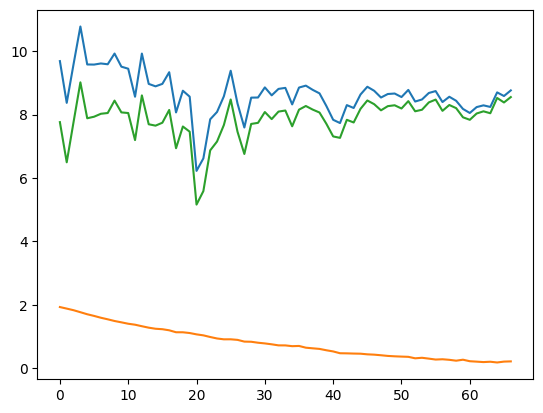

In [ ]:
plt.plot(losses_cdan)
plt.plot(losses_s_cdan)
plt.plot(losses_d_cdan)

In [ ]:
class_names = np.arange(7)


--- Displaying Final Results from Last Epoch ---
Final Accuracy on Combined Source Test Set: 88.64%
Final Accuracy on Target (Sketch) Test Set: 73.90%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

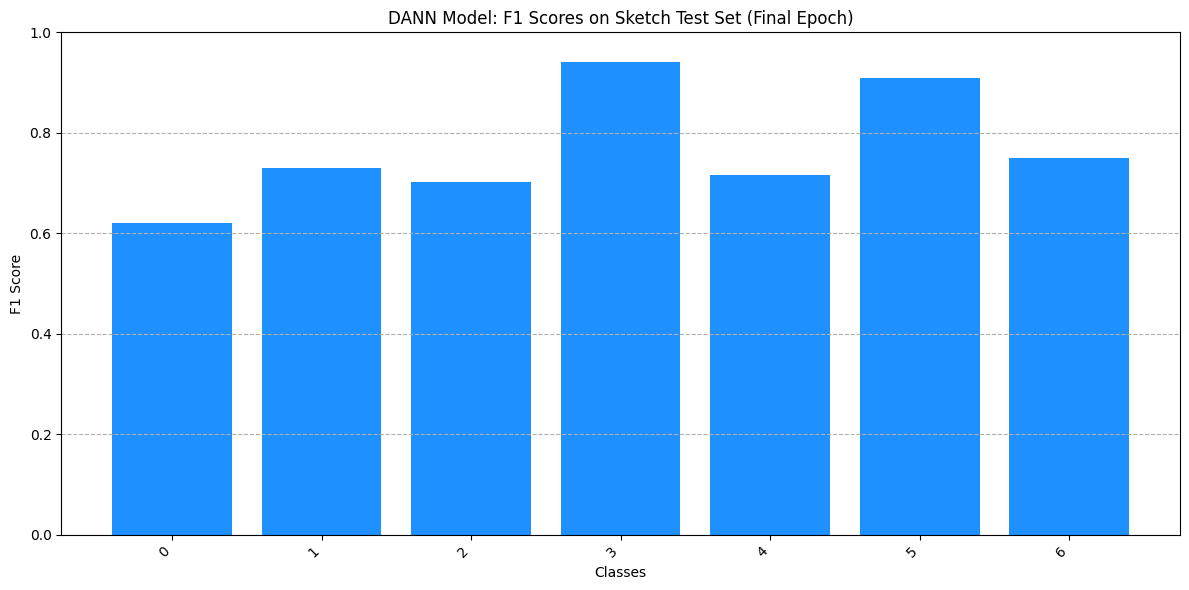


--- Generating t-SNE Plot of Features from the Final Epoch ---

Running t-SNE on a random subset of samples... (This may take a minute)


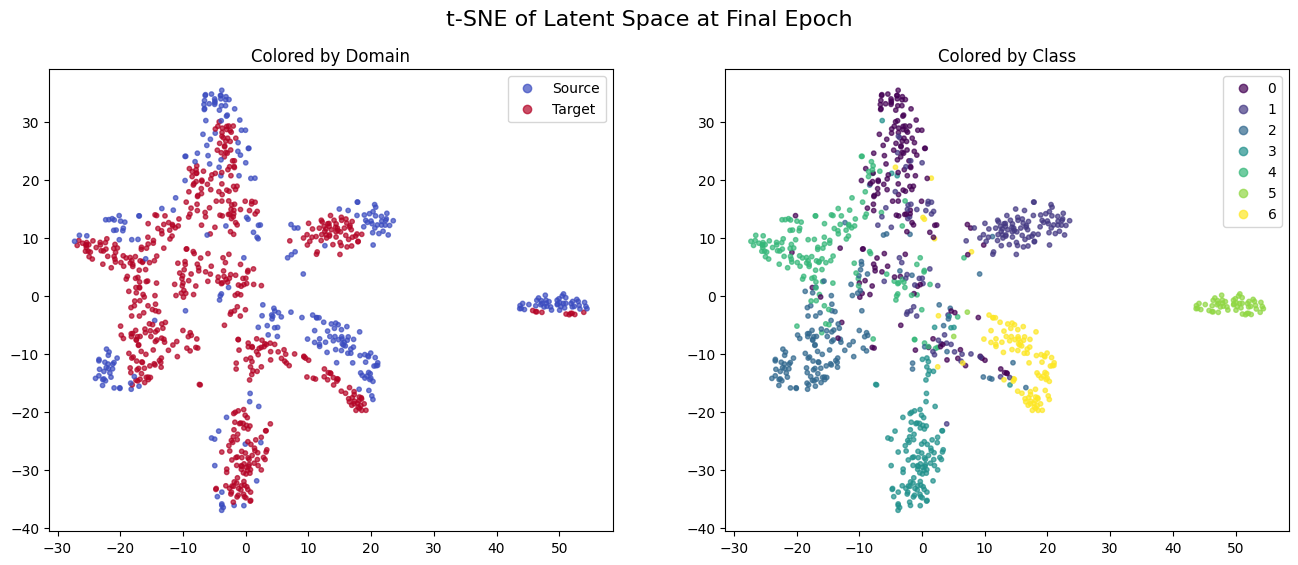


✅ DANN Final Analysis Complete.


In [ ]:
import torch
import collections
from sklearn.metrics import f1_score, accuracy_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# This script assumes the following are defined from previous cells:
# - dann_model: Your trained DANN model
# - source_test_loader, target_test_loader: Your DataLoaders
# - class_names: A list or array of your class names
# - device: Your torch device ('cuda' or 'cpu')
# - latent_source_per_epoch, latent_target_per_epoch: Lists of features from training
# - epochs: The number of epochs the model was trained for

# ===================================================================
# 1. HELPER FUNCTIONS (Corrected)
# ===================================================================

def evaluate_accuracy(model, dataloader, device):
    """
    Helper function to calculate accuracy.
    CORRECTED to handle dictionary batches from the DataLoader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        # Corrected loop
        for batch in dataloader:
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            # Use alpha=0 for pure inference
            outputs, _ = model(images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def print_class_distribution(dataset, class_names, title):
    """
    Helper function to print class populations.
    CORRECTED to work with Hugging Face Dataset objects by iterating
    through the untransformed data.
    """
    print(f"\n--- Class Population for: {title} ---")
    # Temporarily access the dataset without any transforms to avoid errors
    untransformed_dataset = dataset.with_transform(None)

    # Manually iterate to collect labels safely
    labels = [item['label'] for item in untransformed_dataset]

    class_counts = collections.Counter(labels)
    for i, name in enumerate(class_names):
        print(f"  - Class {name}: {class_counts.get(i, 0)} samples")

# Assuming plot_tsne is defined from a previous cell, it should work as is.
# If not, here is a safe version.
def plot_tsne(source_features, target_features, source_labels, target_labels, epoch, num_samples=2000, perplexity=30):
    """Performs t-SNE on a subset of the data and plots the results."""
    print("\nRunning t-SNE on a random subset of samples... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    total_points = len(all_features)
    indices = np.random.permutation(total_points)[:min(num_samples, total_points)]

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space at Final Epoch', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10, alpha=0.7)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10, alpha=0.7)
    handles, _ = scatter2.legend_elements(num=len(class_names))
    ax2.legend(handles=handles, labels=list(class_names))
    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. MAIN ANALYSIS SCRIPT (Corrected)
# ===================================================================

print("\n--- Displaying Final Results from Last Epoch ---")
dann_model.eval()

# --- 1. Calculate and Print Overall Accuracy ---
source_test_accuracy = evaluate_accuracy(dann_model, source_test_loader, device)
print(f"Final Accuracy on Combined Source Test Set: {source_test_accuracy:.2f}%")

target_test_accuracy = evaluate_accuracy(dann_model, target_test_loader, device)
print(f"Final Accuracy on Target (Sketch) Test Set: {target_test_accuracy:.2f}%")

# --- 2. Calculate and Plot F1 Score Histogram for Target Test Set ---
final_preds = []
final_labels = []
with torch.no_grad():
    # Corrected loop
    for batch in tqdm(target_test_loader, desc="Calculating F1 Scores"):
        images = batch['pixel_values'].to(device)
        labels = batch['labels']
        class_outputs, _ = dann_model(images, alpha=0)
        preds = torch.argmax(class_outputs, dim=1)
        final_preds.append(preds.cpu().numpy())
        final_labels.append(labels.numpy())

final_preds = np.concatenate(final_preds)
final_labels = np.concatenate(final_labels)

final_f1_scores = f1_score(final_labels, final_preds, average=None, labels=range(len(class_names)), zero_division=0)

plt.figure(figsize=(12, 6))
plt.bar(class_names, final_f1_scores, color='dodgerblue')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title(f'DANN Model: F1 Scores on Sketch Test Set (Final Epoch)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



# --- 4. t-SNE Plot of Final Latent Features ---
print("\n--- Generating t-SNE Plot of Features from the Final Epoch ---")
# Corrected loop to get source labels
source_test_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
# Target labels are already available from the F1 calculation
target_test_labels = final_labels

plot_tsne(
    latent_source_per_epoch[-1],
    latent_target_per_epoch[-1],
    source_test_labels,
    target_test_labels,
    epoch=(epochs-1)
)

print("\n✅ DANN Final Analysis Complete.")


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score # Added for per-epoch evaluation

# This script assumes the following are defined:
# - Net: Your model class with internal CDAN logic.
# - source_train_loader, target_train_loader, target_val_loader: Your original DataLoaders.
# - device: Your torch device.
# - class_names: A list/array of class names.

# ===================================================================
# 1. SETUP AND TRAIN THE CDAN MODEL ON THE FULL DATASET
# ===================================================================

# --- Model, Optimizers, and Loss Setup ---
# Your Net class should be set to 'cdan' mode to use the correct logic
experimental_cdan = Net(output_features=7, mode='cdan').to(device)

optimizer_main = optim.Adam(
    list(experimental_cdan.feature_extractor.parameters()) + list(experimental_cdan.classifier.parameters()),
    lr=1e-4, betas=(0.5, 0.999)
)
optimizer_disc = optim.Adam(
    experimental_cdan.discriminator.parameters(),
    lr=2.3e-4, betas=(0.5, 0.999)
)
cls_criterion = nn.CrossEntropyLoss()
# Your Net's discriminator ends in a Sigmoid, so BCELoss is the correct choice.
domain_criterion = nn.BCELoss()

# --- NEW: Storage for Per-Epoch Analysis ---
cdan_supl = [] # For supervised (classification) loss
cdan_discl = [] # For discriminator (domain) loss
f1_scores_per_epoch = []

# --- Training Loop ---
epochs = 20
print("\n--- Starting Standard CDAN Training on Full Dataset ---")

# Use the full dataloaders
len_dataloader = min(len(source_train_loader), len(target_train_loader))
total_steps = epochs * len_dataloader

for epoch in range(epochs):
    experimental_cdan.train()
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)

    # NEW: Accumulators for running losses
    running_cls_loss = 0.0
    running_domain_loss = 0.0

    pbar = tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{epochs} [CDAN Training]")

    for step in pbar:
        # Alpha schedule for GRL
        current_step = epoch * len_dataloader + step
        p = float(current_step) / (total_steps + 1e-12)
        alpha = (2. / (1. + np.exp(-10 * p)) - 1)

        # Data Loading from the full loaders
        try:
            source_batch = next(iter_source)
            target_batch = next(iter_target)
        except StopIteration:
            iter_source = iter(source_train_loader)
            iter_target = iter(target_train_loader)
            source_batch = next(iter_source)
            target_batch = next(iter_target)

        source_images, source_labels = source_batch['pixel_values'].to(device), source_batch['labels'].to(device)
        # We don't need target labels for standard CDAN
        target_images = target_batch['pixel_values'].to(device)

        # --- Combined Forward Pass & Loss Calculation ---
        optimizer_main.zero_grad()
        optimizer_disc.zero_grad()

        # Create domain labels (1 for source, 0 for target)
        source_domain_labels = torch.ones(source_images.size(0), 1, device=device)
        target_domain_labels = torch.zeros(target_images.size(0), 1, device=device)

        # Forward pass for source data
        s_class_out, s_domain_out = experimental_cdan(source_images, alpha)

        # Forward pass for target data
        _, t_domain_out = experimental_cdan(target_images, alpha)

        # 1. Classification loss on source data
        cls_loss = cls_criterion(s_class_out, source_labels)

        # 2. Domain loss for both source and target
        domain_loss = domain_criterion(s_domain_out, source_domain_labels) + \
                      domain_criterion(t_domain_out, target_domain_labels)

        # --- Combined Loss and Backward Pass ---
        total_loss = cls_loss + domain_loss
        total_loss.backward()

        # Step both optimizers. The GRL handles the adversarial updates automatically.
        optimizer_main.step()
        optimizer_disc.step()

        pbar.set_postfix({'cls_loss': cls_loss.item(), 'dom_loss': domain_loss.item()})

        # Accumulate losses
        running_cls_loss += cls_loss.item()
        running_domain_loss += domain_loss.item()

    # --- NEW: End-of-Epoch Analysis ---
    # Calculate and store average losses
    avg_cls_loss = running_cls_loss / len_dataloader
    avg_domain_loss = running_domain_loss / len_dataloader
    cdan_supl.append(avg_cls_loss)
    cdan_discl.append(avg_domain_loss)

    # Calculate F1 score on the validation set
    experimental_cdan.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in target_val_loader:
            images, labels = batch['pixel_values'].to(device), batch['labels']
            class_outputs, _ = experimental_cdan(images, alpha=0)
            preds = torch.argmax(class_outputs, dim=1)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(labels.numpy())

    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)
    epoch_f1s = f1_score(val_labels, val_preds, average=None, labels=range(len(class_names)), zero_division=0)
    f1_scores_per_epoch.append(epoch_f1s)

    print(f"Epoch {epoch+1} complete. Avg F1 on Val Set: {epoch_f1s.mean():.4f}")


print("\n✅ Standard CDAN Training Finished.")




--- Starting Standard CDAN Training on Full Dataset ---


Epoch 1/20 [CDAN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1 complete. Avg F1 on Val Set: 0.4194


Epoch 2/20 [CDAN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2 complete. Avg F1 on Val Set: 0.4516


Epoch 3/20 [CDAN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3 complete. Avg F1 on Val Set: 0.2971


Epoch 4/20 [CDAN Training]:   0%|          | 0/44 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import copy

# This script assumes the following are defined:
# - source_reload: Your trained and loaded source-only model object
# - Net: Your model class
# - source_train_loader, target_train_loader, target_test_loader: Your DataLoaders
# - device: Your torch device
# - BATCH_SIZE: Your batch size

# ===================================================================
# 1. EXPERIMENT SETUP
# ===================================================================

# --- Hyperparameters ---
CONFIDENCE_THRESHOLD = 0.9  # Key parameter to tune
FT_EPOCHS = 5
FT_LR = 1e-4 # Use a slightly higher LR for classifier-only training

# --- Get the baseline (pre-training) accuracy once ---
print("--- Evaluating Baseline Source-Only Model ---")
source_only_model = source_reload.to('cuda')
source_only_model.eval()
with torch.no_grad():
    initial_preds, initial_labels = [], []
    for batch in target_test_loader:
        images, labels = batch['pixel_values'].to(device), batch['labels']
        outputs, _ = source_only_model(images, alpha=0)
        initial_preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
        initial_labels.append(labels.numpy())
    initial_preds, initial_labels = np.concatenate(initial_preds), np.concatenate(initial_labels)
initial_acc = accuracy_score(initial_labels, initial_preds)
print(f"Accuracy on Target Test Set BEFORE Self-Training: {initial_acc:.2%}")

# ===================================================================
# 2. MAIN SELF-TRAINING PROCESS
# ===================================================================

print(f"\n{'='*20}\n--- Running Self-Training with Confidence Threshold: {CONFIDENCE_THRESHOLD} ---\n{'='*20}")

# --- Step 1: Create a fresh copy of the model for this run ---
fine_tuning_model = Net(output_features=7, mode='dann').to(device)
fine_tuning_model.load_state_dict(source_only_model.state_dict())

# --- Step 2: Generate Pseudo-Labels ---
print(f"Generating Pseudo-Labels (Confidence > {CONFIDENCE_THRESHOLD})...")
pseudo_labeled_data = []
with torch.no_grad():
    for batch in tqdm(target_train_loader, desc="Generating Labels", leave=False):
        images = batch['pixel_values'].to(device)
        outputs, _ = source_only_model(images, alpha=0)
        probs = F.softmax(outputs, dim=1)
        confidences, pseudo_labels = torch.max(probs, dim=1)
        for i in range(len(images)):
            if confidences[i].item() > CONFIDENCE_THRESHOLD:
                pseudo_labeled_data.append((images[i].cpu(), pseudo_labels[i].cpu()))

num_labels = len(pseudo_labeled_data)
if not pseudo_labeled_data:
    print("❌ ERROR: No pseudo-labels generated at this threshold. Halting experiment.")
else:
    print(f"✅ Generated {num_labels} high-confidence pseudo-labels.")

    # --- Step 3: Create DataLoader for Pseudo-Labels ---
    images_tensor = torch.stack([item[0] for item in pseudo_labeled_data])
    labels_tensor = torch.stack([item[1] for item in pseudo_labeled_data])
    pseudo_dataset = TensorDataset(images_tensor, labels_tensor)
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- Step 4: Fine-Tune on COMBINED Data with Frozen Backbone ---
    print("Fine-tuning classifier on combined data with frozen backbone...")

    # Freeze the feature extractor parameters
    for param in fine_tuning_model.feature_extractor.parameters():
        param.requires_grad = False

    # Optimizer will only act on the classifier parameters
    optimizer_st = optim.Adam(fine_tuning_model.classifier.parameters(), lr=FT_LR)
    criterion_st = nn.CrossEntropyLoss()

    fine_tuning_model.train()
    for epoch in range(FT_EPOCHS):
        source_iter = iter(source_train_loader)
        pbar = tqdm(pseudo_loader, desc=f"Fine-Tuning Epoch {epoch+1}/{FT_EPOCHS}", leave=False)

        for pseudo_images, pseudo_labels in pbar:
            try:
                source_batch = next(source_iter)
            except StopIteration:
                source_iter = iter(source_train_loader)
                source_batch = next(source_iter)

            source_images = source_batch['pixel_values']
            source_labels = source_batch['labels']

            # Combine the source and pseudo-labeled batches
            combined_images = torch.cat([source_images, pseudo_images])
            combined_labels = torch.cat([source_labels, pseudo_labels])
            images, labels = combined_images.to(device), combined_labels.to(device)

            optimizer_st.zero_grad()
            outputs, _ = fine_tuning_model(images, alpha=0)
            loss = criterion_st(outputs, labels)
            loss.backward() # Gradients will only be computed for the classifier
            optimizer_st.step()
            pbar.set_postfix({'loss': loss.item()})

    print("✅ Fine-tuning complete.")

    # --- Step 5: Evaluate the fine-tuned model ---
    fine_tuning_model.eval()
    with torch.no_grad():
        final_preds, final_labels = [], []
        for batch in target_test_loader:
            images, labels = batch['pixel_values'].to(device), batch['labels']
            outputs, _ = fine_tuning_model(images, alpha=0)
            final_preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
            final_labels.append(labels.numpy())
        final_preds, final_labels = np.concatenate(final_preds), np.concatenate(final_labels)

    final_acc = accuracy_score(final_preds, final_labels)
    final_f1 = f1_score(final_preds, final_labels, average='macro', zero_division=0)

    # ===================================================================
    # 3. FINAL RESULTS
    # ===================================================================
    print(f"\n\n{'='*20}\n--- Self-Training Results (Threshold: {CONFIDENCE_THRESHOLD}) ---\n{'='*20}")
    print(f"Initial Accuracy (Source-Only): {initial_acc:.2%}")
    print(f"Final Accuracy (After Self-Training): {final_acc:.2%}")
    print(f"Performance Gain: {final_acc - initial_acc:+.2%}")
    print(f"Final Macro F1-Score: {final_f1:.4f}")



--- Evaluating Baseline Source-Only Model ---
Accuracy on Target Test Set BEFORE Self-Training: 55.25%

--- Running Self-Training with Confidence Threshold: 0.9 ---
Generating Pseudo-Labels (Confidence > 0.9)...


Generating Labels:   0%|          | 0/85 [00:00<?, ?it/s]

✅ Generated 672 high-confidence pseudo-labels.
Fine-tuning classifier on combined data with frozen backbone...


Fine-Tuning Epoch 1/5:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tuning Epoch 2/5:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tuning Epoch 3/5:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tuning Epoch 4/5:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tuning Epoch 5/5:   0%|          | 0/21 [00:00<?, ?it/s]

✅ Fine-tuning complete.


--- Self-Training Results (Threshold: 0.9) ---
Initial Accuracy (Source-Only): 55.25%
Final Accuracy (After Self-Training): 72.03%
Performance Gain: +16.78%
Final Macro F1-Score: 0.7385




--- Final Analysis of Fine-Tuned Model ---


Evaluating Target Domain:   0%|          | 0/19 [00:00<?, ?it/s]


Initial Target Accuracy (Source-Only): 0.55%
Final Target Accuracy (After Self-Training): 72.03%
Performance Gain on Target: +71.48%
Final Source Accuracy (After Self-Training): 96.10%
Final Target Macro F1-Score: 0.7385

Extracting final features for t-SNE plot...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Self-Training Model (Final State)... (This may take a minute)


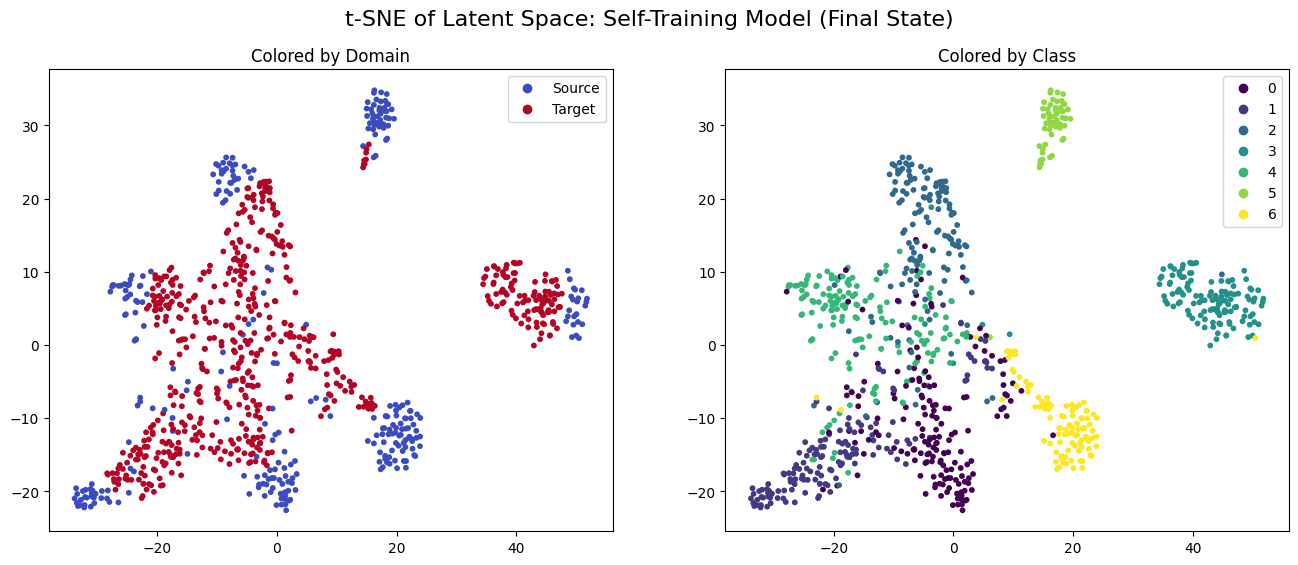


✅ Final Analysis Complete.


In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# This script assumes the following are defined from previous cells:
# - fine_tuning_model: Your final, trained model object.
# - source_test_loader, target_test_loader: Your DataLoaders.
# - device: Your torch device.
# - class_names: A list/array of class names.
# - initial_acc: The baseline accuracy from the source-only model.

# ===================================================================
# 1. HELPER FUNCTIONS (Copied for self-containment)
# ===================================================================

def evaluate_accuracy(model, dataloader, device):
    """Helper function to calculate accuracy (handles dictionary batches)."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs, _ = model(images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_tsne(source_features, target_features, source_labels, target_labels, class_names, title):
    """Performs and plots t-SNE on a subset of the data."""
    print(f"\nRunning t-SNE for {title}... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    indices = np.random.permutation(len(all_features))[:2000] # Use a subset for speed

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space: {title}', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10)

    # --- THE FIX IS HERE: Make legend creation more robust ---
    # Determine the number of unique classes directly from the plotted data.
    num_classes = len(np.unique(all_labels))

    # Create legend labels safely.
    try:
        # Try to use the provided class_names variable.
        legend_labels = list(class_names)
        # If the length doesn't match, fall back to default labels.
        if len(legend_labels) != num_classes:
            legend_labels = [str(i) for i in range(num_classes)]
    except TypeError:
        # If class_names isn't a list/array, create default labels.
        legend_labels = [str(i) for i in range(num_classes)]

    handles, _ = scatter2.legend_elements(num=num_classes)
    ax2.legend(handles=handles, labels=legend_labels)
    # --- END FIX ---

    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. FINAL COMPREHENSIVE EVALUATION
# ===================================================================
print(f"\n\n{'='*20}\n--- Final Analysis of Fine-Tuned Model ---\n{'='*20}")

# Use the fine_tuning_model from the previous cell for evaluation
model_to_evaluate = fine_tuning_model
model_to_evaluate.eval()

# --- 1. Calculate Target Accuracy and F1 Score ---
final_preds, final_labels = [], []
with torch.no_grad():
    for batch in tqdm(target_test_loader, desc="Evaluating Target Domain"):
        images, labels = batch['pixel_values'].to(device), batch['labels']
        outputs, _ = model_to_evaluate(images, alpha=0)
        final_preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
        final_labels.append(labels.numpy())
final_preds, final_labels = np.concatenate(final_preds), np.concatenate(final_labels)
final_target_acc = accuracy_score(final_labels, final_preds)
final_f1 = f1_score(final_labels, final_preds, average='macro', zero_division=0)

# --- 2. Calculate Source Accuracy ---
final_source_acc = evaluate_accuracy(model_to_evaluate, source_test_loader, device)

# --- 3. Print All Results ---
print(f"\nInitial Target Accuracy (Source-Only): {initial_acc:.2f}%")
print(f"Final Target Accuracy (After Self-Training): {final_target_acc*100:.2f}%")
print(f"Performance Gain on Target: {final_target_acc*100 - initial_acc:+.2f}%")
print(f"Final Source Accuracy (After Self-Training): {final_source_acc:.2f}%")
print(f"Final Target Macro F1-Score: {final_f1:.4f}")

# --- 4. Generate t-SNE Plot ---
with torch.no_grad():
    print("\nExtracting final features for t-SNE plot...")
    source_features = np.concatenate(
        [model_to_evaluate.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(source_test_loader, leave=False)]
    )
    target_features = np.concatenate(
        [model_to_evaluate.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(target_test_loader, leave=False)]
    )
source_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
target_labels = final_labels # Reuse labels from F1 calculation

# Call the now-fixed plot_tsne function
plot_tsne(
    source_features,
    target_features,
    source_labels,
    target_labels,
    class_names,
    title=f"Self-Training Model (Final State)"
)

print("\n✅ Final Analysis Complete.")



Testing and evaluation

In [ ]:
dann_model = Net(7,'dann')
source_reload = Net(7,'dann')
mmd_reload = Net(7,'dann')
cdan_reload  = Net(7 , 'dann')
path = '/content/drive/MyDrive/MyModels/'

dann_model.load_state_dict(torch.load(path + 'dann_model.pth'))
source_reload.load_state_dict(torch.load(path + 'source_only_model.pth'))
mmd_reload.load_state_dict(torch.load(path + 'mmd_model.pth'))
cdan_reload.load_state_dict(torch.load(path + 'cdan_model.pth'))

<All keys matched successfully>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset

# This script assumes the following are defined in your main notebook:
# - source_test_loader, target_test_loader: Your original DataLoaders
# - Net: Your model class
# - device: Your torch device

def create_stress_loader(original_loader, class_to_reduce, reduction_percentage=0.1):
    """
    Creates a new DataLoader with a reduced population for a specific class.

    Args:
        original_loader (DataLoader): The original DataLoader (e.g., target_test_loader).
        class_to_reduce (int): The integer index of the class to be reduced.
        reduction_percentage (float): The percentage of the original class
                                      population to keep (e.g., 0.1 for 10%).

    Returns:
        DataLoader: A new DataLoader with the reduced class population.
    """
    print(f"\n--- Creating Stress Loader: Reducing Class {class_to_reduce} to {reduction_percentage:.0%} ---")

    # Get the underlying Hugging Face dataset from the loader
    original_dataset = original_loader.dataset

    # --- THE FIX IS HERE ---
    # Instead of removing the transform, we iterate over the original dataset.
    # This is more robust and avoids the internal library error, although it may be slightly slower
    # as it will process images unnecessarily.
    print("Extracting labels from the original dataset...")
    labels = np.array([item['label'] for item in original_dataset])

    # Find the indices for the target class and all other classes
    target_class_indices = np.where(labels == class_to_reduce)[0]
    other_class_indices = np.where(labels != class_to_reduce)[0]

    # --- Subsample the target class ---
    # Shuffle the indices to ensure the subset is random
    np.random.shuffle(target_class_indices)

    # Calculate how many samples to keep
    num_to_keep = int(len(target_class_indices) * reduction_percentage)
    subsampled_indices = target_class_indices[:num_to_keep]

    print(f"Original count for class {class_to_reduce}: {len(target_class_indices)}")
    print(f"Reduced count for class {class_to_reduce}: {len(subsampled_indices)}")

    # --- Combine the indices ---
    # We keep all samples from other classes and the subsampled target class
    final_indices = np.concatenate([subsampled_indices, other_class_indices])

    # Shuffle the final combined list to mix the classes during evaluation
    np.random.shuffle(final_indices)

    # Create a Subset using the original dataset but with our new list of indices
    stress_dataset = Subset(original_dataset, final_indices)

    # Create a new DataLoader from the Subset
    stress_loader = DataLoader(
        stress_dataset,
        batch_size=original_loader.batch_size,
        collate_fn=original_loader.collate_fn, # Use the same collate_fn
        shuffle=False # Shuffle is False for evaluation
    )

    print(f"✅ Stress loader created with {len(stress_dataset)} total samples.")
    return stress_loader


# ===================================================================
# Example of how to use this function in your main notebook:
# ===================================================================
if __name__ == '__main__':
    # This is a dummy example. In your notebook, you would use your actual loaders.
    # ----------------- DUMMY SETUP (for demonstration) -----------------
    from datasets import Dataset as HFDataset

    # Create a fake dataset with 100 samples and 3 classes
    dummy_data = {
        'image': [np.random.rand(224, 224, 3) for _ in range(100)],
        'label': np.random.randint(0, 3, 100)
    }
    dummy_hf_dataset = HFDataset.from_dict(dummy_data)

    def dummy_collate(batch):
        # A simple collate for demonstration
        labels = torch.tensor([item['label'] for item in batch])
        return {'pixel_values': None, 'labels': labels} # Images not needed for this example

    dummy_loader = DataLoader(dummy_hf_dataset, batch_size=10, collate_fn=dummy_collate)
    # ----------------- END DUMMY SETUP -----------------

    # --- ACTUAL USAGE ---
    # Suppose you want to test robustness by reducing the population of class 1
    CLASS_TO_STRESS = 3

    stress_loader_target = create_stress_loader(target_test_loader, CLASS_TO_STRESS)

    # Now you can use this 'stress_loader_target' to evaluate your models
    # For example, using a helper function you already have:
    #
    #   acc_on_stress_test = evaluate_accuracy(dann_model, stress_loader_target, device)
    #   print(f"Accuracy on stress test (Class {CLASS_TO_STRESS} reduced): {acc_on_stress_test:.2f}%")




--- Creating Stress Loader: Reducing Class 3 to 10% ---
Extracting labels from the original dataset...
Original count for class 3: 103
Reduced count for class 3: 10
✅ Stress loader created with 497 total samples.


In [ ]:
class_names = np.arange(7)

In [ ]:
import collections
from torch.utils.data import DataLoader

def print_class_distribution(loader, class_names, title):
    """
    Calculates and prints the class distribution for a Hugging Face DataLoader.

    Args:
        loader (DataLoader): The DataLoader to analyze.
        class_names (list or np.ndarray): A list/array of names for the classes.
        title (str): A title for the printed output.
    """
    print(f"\n--- Class Distribution for: {title} ---")

    # Get the underlying Hugging Face dataset from the loader
    dataset = loader.dataset

    # The most robust way to get labels without triggering transform errors
    # is to manually iterate through the untransformed dataset. This avoids
    # internal library errors when transforms are set.
    try:
        untransformed_dataset = dataset.with_transform(None)
        labels = [item['label'] for item in untransformed_dataset]
    except Exception:
        # Fallback for datasets that don't use .with_transform (e.g., Subsets)
        print("Could not use .with_transform(), iterating through loader (may be slower)...")
        all_labels = []
        for batch in loader:
            all_labels.extend(batch['labels'].cpu().numpy())
        labels = all_labels

    # Count the occurrences of each class label
    class_counts = collections.Counter(labels)

    total_samples = len(labels)
    if total_samples == 0:
        print("Dataset is empty.")
        return

    print(f"Total Samples: {total_samples}")

    # Print the count for each class
    for i, name in enumerate(class_names):
        count = class_counts.get(i, 0)
        percentage = (count / total_samples) * 100
        print(f"  - Class '{name}': {count} samples ({percentage:.1f}%)")
print_class_distribution(source_test_loader, class_names, "Source Test Set")
print_class_distribution(stress_loader_target, class_names, "Target Test Set")



--- Class Distribution for: Source Test Set ---
Could not use .with_transform(), iterating through loader (may be slower)...
Total Samples: 308
  - Class '0': 56 samples (18.2%)
  - Class '1': 37 samples (12.0%)
  - Class '2': 39 samples (12.7%)
  - Class '3': 25 samples (8.1%)
  - Class '4': 33 samples (10.7%)
  - Class '5': 46 samples (14.9%)
  - Class '6': 72 samples (23.4%)

--- Class Distribution for: Target Test Set ---
Could not use .with_transform(), iterating through loader (may be slower)...
Total Samples: 581
  - Class '0': 112 samples (19.3%)
  - Class '1': 109 samples (18.8%)
  - Class '2': 101 samples (17.4%)
  - Class '3': 103 samples (17.7%)
  - Class '4': 127 samples (21.9%)
  - Class '5': 1 samples (0.2%)
  - Class '6': 28 samples (4.8%)




--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 88.96%
Final Accuracy on Target ('sketch') Test Set: 75.08%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7767



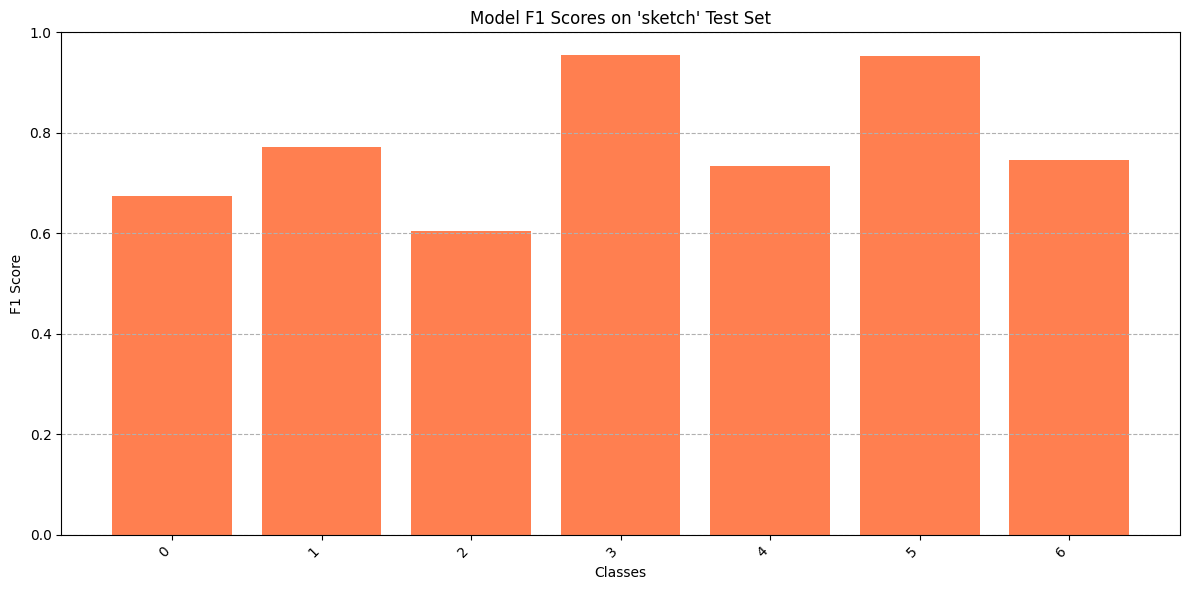


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


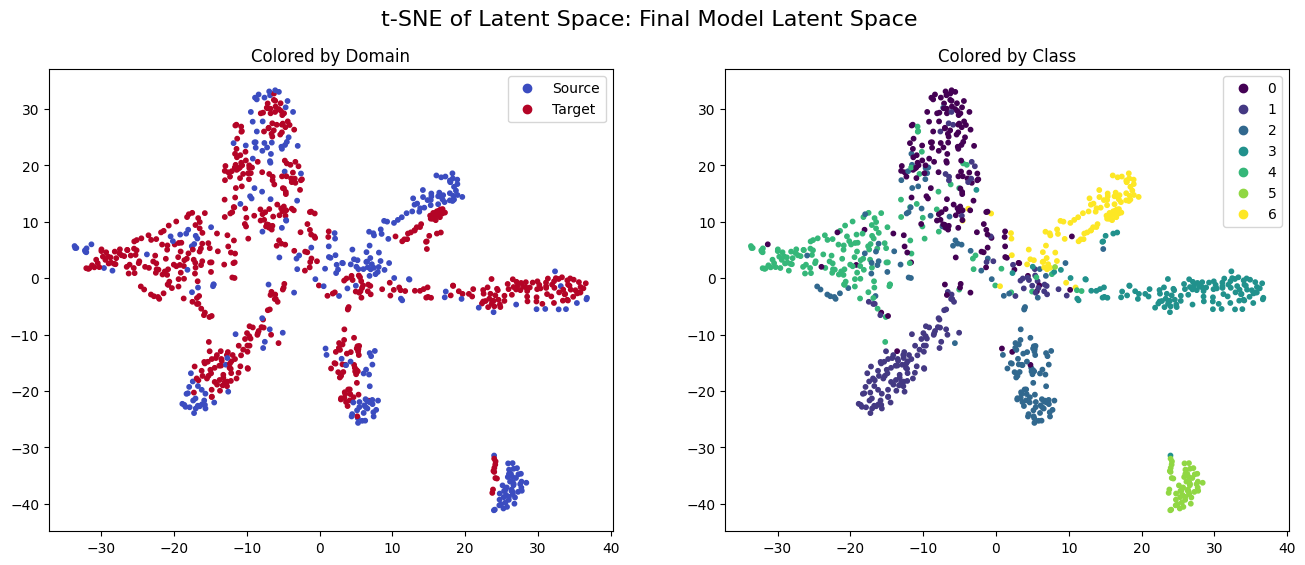


✅ Final Analysis Complete.


In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# This script assumes the following are defined from previous cells:
# - fine_tuning_model: Your final, trained model object.
# - source_test_loader, target_test_loader: Your DataLoaders.
# - device: Your torch device.
# - class_names: A list/array of class names.
# - initial_acc: The baseline accuracy from the source-only model.
# - TARGET_DOMAIN: The name of your target domain (e.g., 'sketch')

# ===================================================================
# 1. HELPER FUNCTIONS (Copied for self-containment)
# ===================================================================

def evaluate_accuracy(model, dataloader, device):
    """Helper function to calculate accuracy (handles dictionary batches)."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs, _ = model(images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_tsne(source_features, target_features, source_labels, target_labels, class_names, title):
    """Performs and plots t-SNE on a subset of the data."""
    print(f"\nRunning t-SNE for {title}... (This may take a minute)")
    all_features = np.concatenate([source_features, target_features])
    all_domains = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])
    all_labels = np.concatenate([source_labels, target_labels])

    indices = np.random.permutation(len(all_features))[:2000] # Use a subset for speed

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
    features_2d = tsne.fit_transform(all_features[indices])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f't-SNE of Latent Space: {title}', fontsize=16)

    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=all_domains[indices], cmap='coolwarm', s=10)
    ax1.legend(handles=scatter1.legend_elements()[0], labels=['Source', 'Target'])
    ax1.set_title('Colored by Domain')

    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels[indices], cmap='viridis', s=10)

    # --- Robust legend creation ---
    num_classes = len(np.unique(all_labels))
    try:
        legend_labels = list(class_names)
        if len(legend_labels) != num_classes:
            legend_labels = [str(i) for i in range(num_classes)]
    except TypeError:
        legend_labels = [str(i) for i in range(num_classes)]

    handles, _ = scatter2.legend_elements(num=num_classes)
    ax2.legend(handles=handles, labels=legend_labels)
    # --- END FIX ---

    ax2.set_title('Colored by Class')
    plt.show()

# ===================================================================
# 2. CORRECTED TESTER FUNCTION
# ===================================================================
def tester(model, source_test_loader, target_test_loader, device, class_names, TARGET_DOMAIN):
    model.eval()

    print(f"\n\n{'='*20}\n--- Running Full Evaluation ---\n{'='*20}")

    # --- Part 1: Calculate and Print Accuracies ---
    source_test_accuracy = evaluate_accuracy(model, source_test_loader, device)
    print(f"Final Accuracy on Combined Source Test Set: {source_test_accuracy:.2f}%")

    target_test_accuracy = evaluate_accuracy(model, target_test_loader, device)
    print(f"Final Accuracy on Target ('{TARGET_DOMAIN}') Test Set: {target_test_accuracy:.2f}%")

    # --- Part 2: Calculate and Plot F1 Scores for Target Test Set ---
    final_preds, final_labels = [], []
    with torch.no_grad():
        for batch in tqdm(target_test_loader, desc="Calculating F1 Scores"):
            images = batch['pixel_values'].to(device)
            labels = batch['labels'] # Keep labels on CPU for numpy conversion
            class_outputs, _ = model(images, alpha=0)
            preds = torch.argmax(class_outputs, dim=1)
            final_preds.append(preds.cpu().numpy())
            final_labels.append(labels.numpy())

    final_preds = np.concatenate(final_preds)
    final_labels = np.concatenate(final_labels)

    f1s = f1_score(final_preds, final_labels, average=None, labels=range(len(class_names)), zero_division=0)
    print(f"Average F1 Score on '{TARGET_DOMAIN}' Test Set: {f1s.mean():.4f}\n")

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, f1s, color='coral')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title(f"Model F1 Scores on '{TARGET_DOMAIN}' Test Set")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Part 3: Extract Current Features and Display t-SNE ---
    print("\n--- Generating t-SNE Plot of Final Latent Features ---")
    with torch.no_grad():
        print("Extracting source test features...")
        current_source_features = np.concatenate(
            [model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(source_test_loader, leave=False)]
        )
        print("Extracting target test features...")
        current_target_features = np.concatenate(
            [model.feature_extractor(batch['pixel_values'].to(device)).cpu().numpy() for batch in tqdm(target_test_loader, leave=False)]
        )

    source_test_labels = np.concatenate([batch['labels'].numpy() for batch in source_test_loader])
    target_test_labels = np.concatenate([batch['labels'].numpy() for batch in target_test_loader])

    # --- Correct arguments are passed to plot_tsne ---
    plot_tsne(
        current_source_features,
        current_target_features,
        source_test_labels,
        target_test_labels,
        class_names, # Pass the class_names variable
        title='Final Model Latent Space'
    )

    print("\n✅ Final Analysis Complete.")

# ===================================================================
# 3. EXAMPLE OF HOW TO CALL THE TESTER FUNCTION
# ===================================================================
# You would run this in a new cell after your model is trained.
# This assumes 'dann_model', 'source_test_loader', 'target_test_loader',
# 'device', 'class_names', and 'TARGET_DOMAIN' are all defined.

# Call the tester function with all required arguments.
tester(dann_model,source_test_loader, target_test_loader,device, class_names, TARGET_DOMAIN
)



In [ ]:
class_names = np.arange(7)

Final Accuracy on Combined Source Test Set: 83.12%
Final Accuracy on Target ('sketch') Test Set: 69.66%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.6691



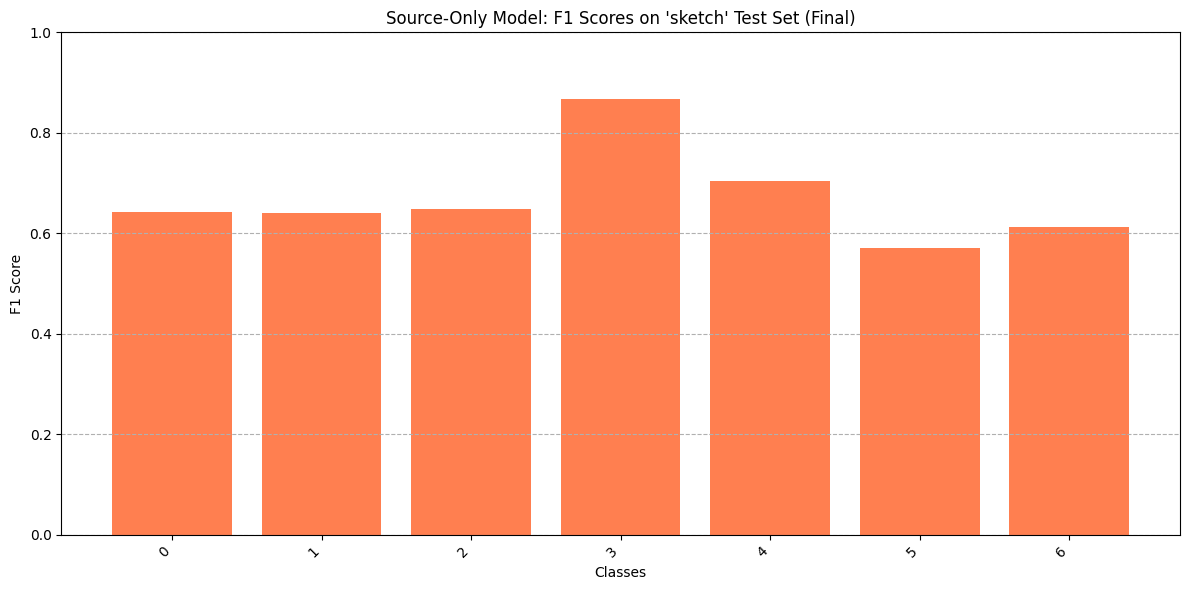


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE on a random subset of samples... (This may take a minute)


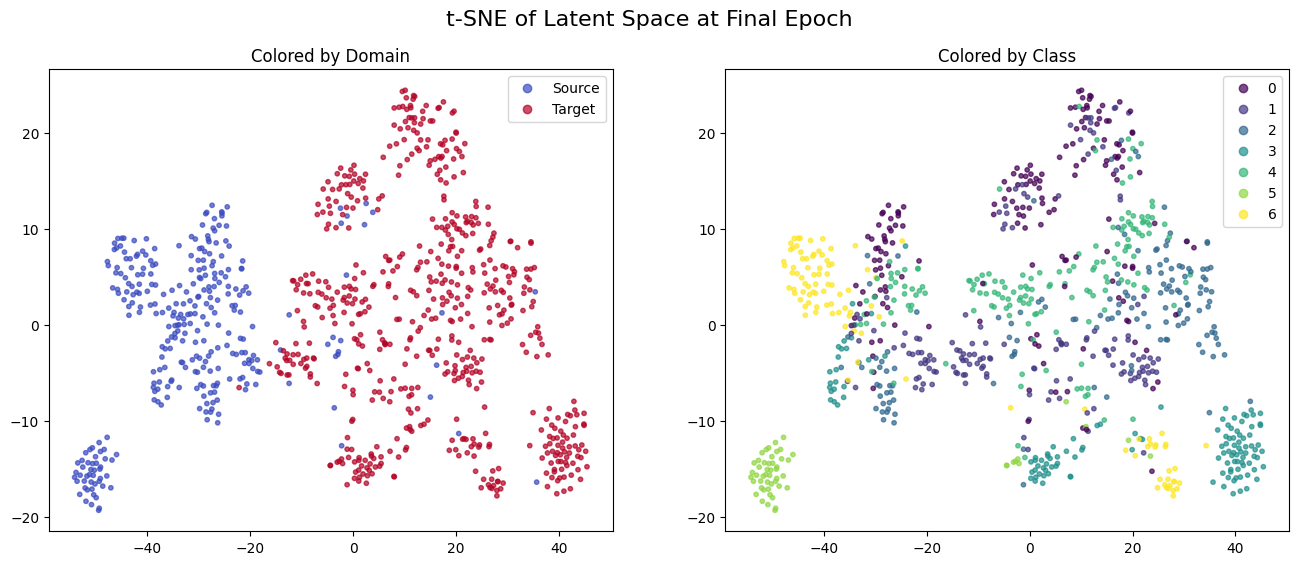


✅ Final Analysis Complete.


In [ ]:
tester(cdan_model , source_test_loader,target_test_loader)

Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 72.88%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7528



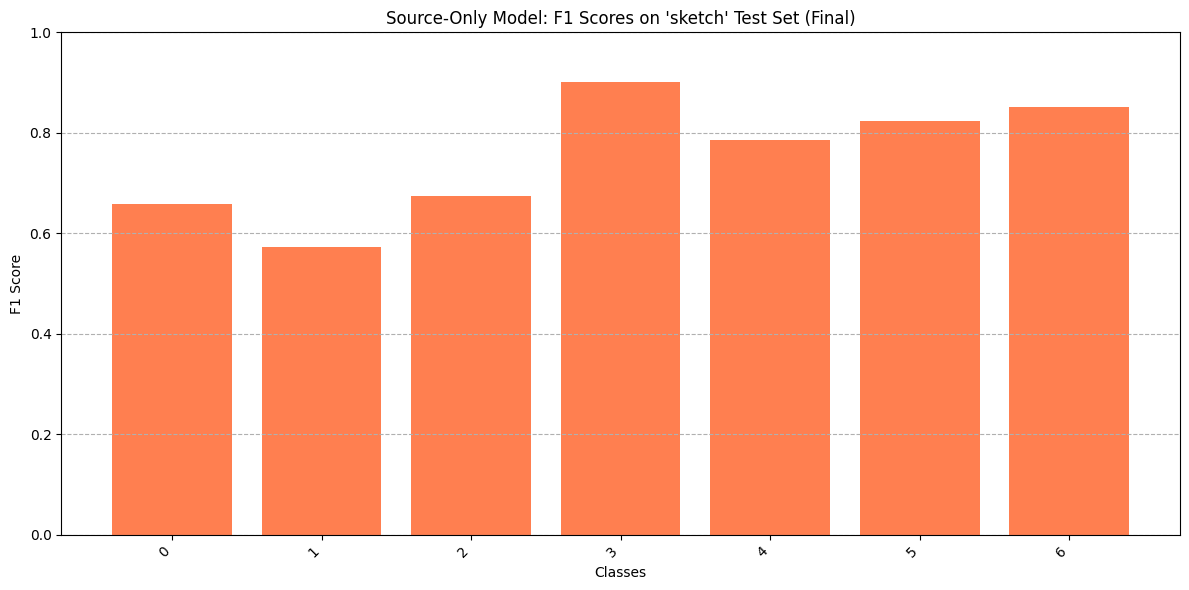


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE on a random subset of samples... (This may take a minute)


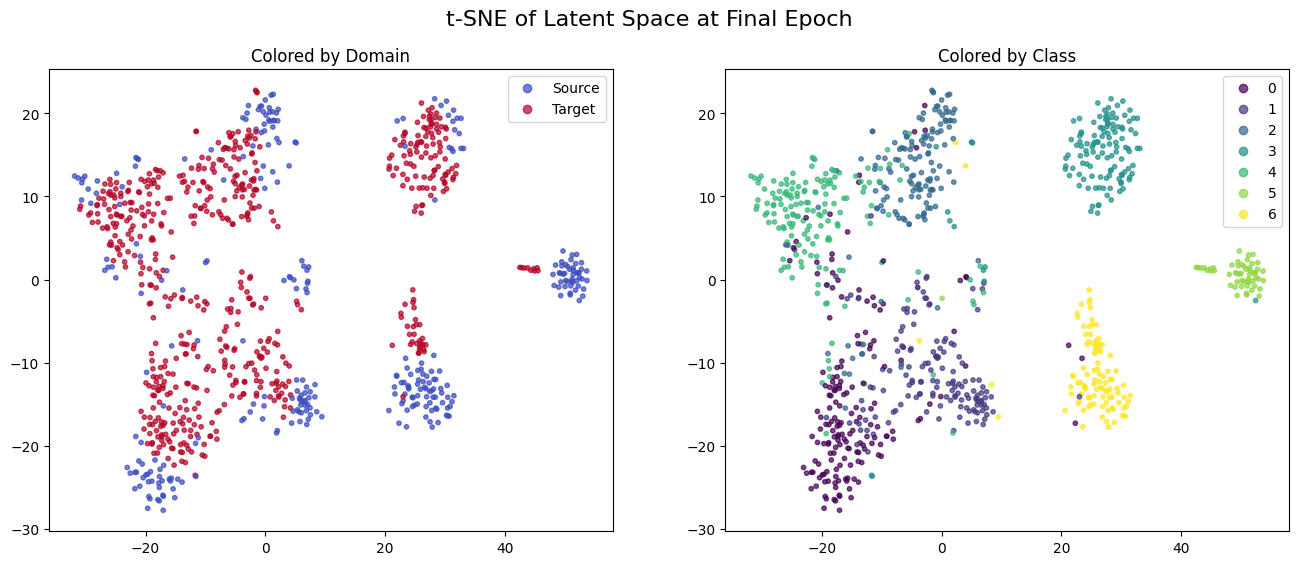


✅ Final Analysis Complete.
Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 72.98%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7797



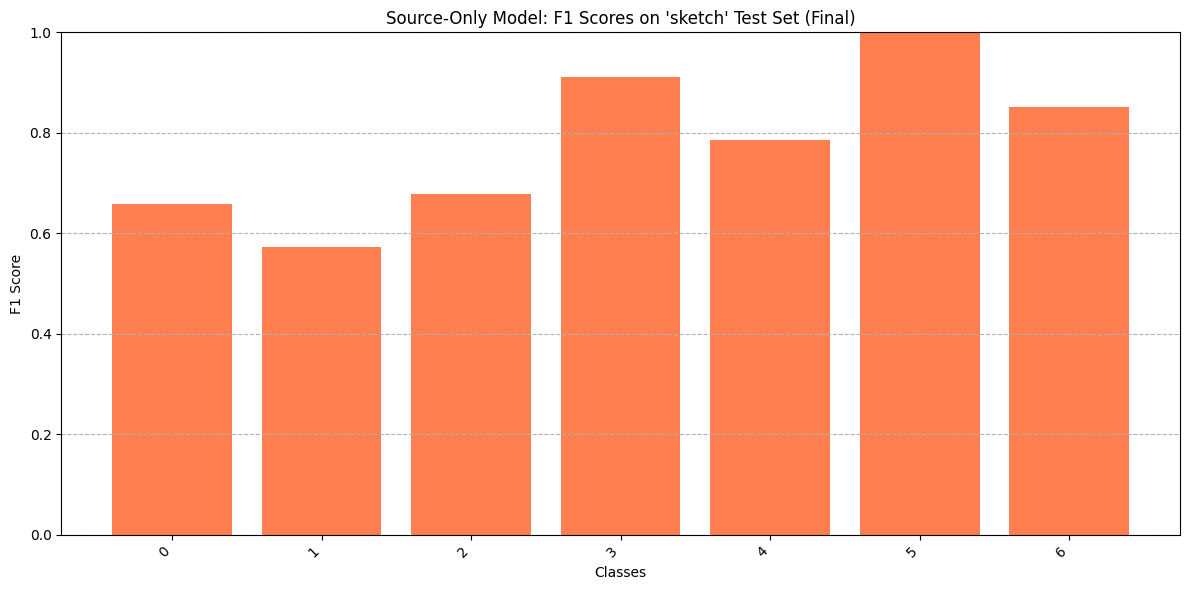


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE on a random subset of samples... (This may take a minute)


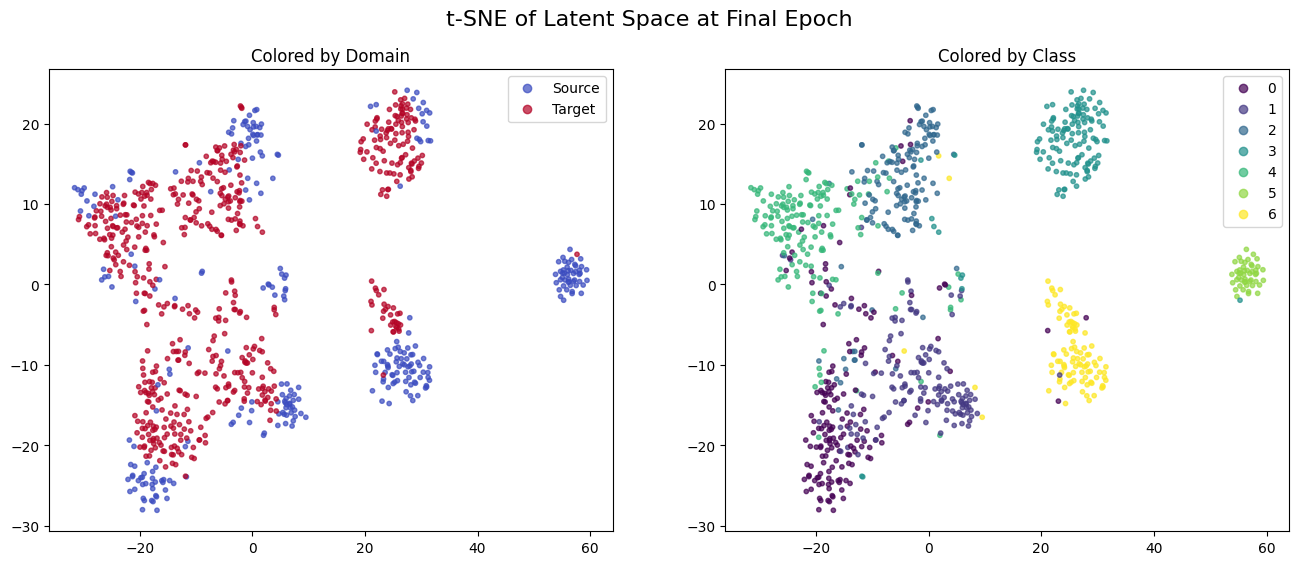


✅ Final Analysis Complete.


In [ ]:
tester(mmd_reload.to('cuda') , source_test_loader,target_test_loader)
tester(mmd_reload.to('cuda') , source_test_loader,stress_loader_target)

Final Accuracy on Combined Source Test Set: 86.36%
Final Accuracy on Target ('sketch') Test Set: 75.90%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7886



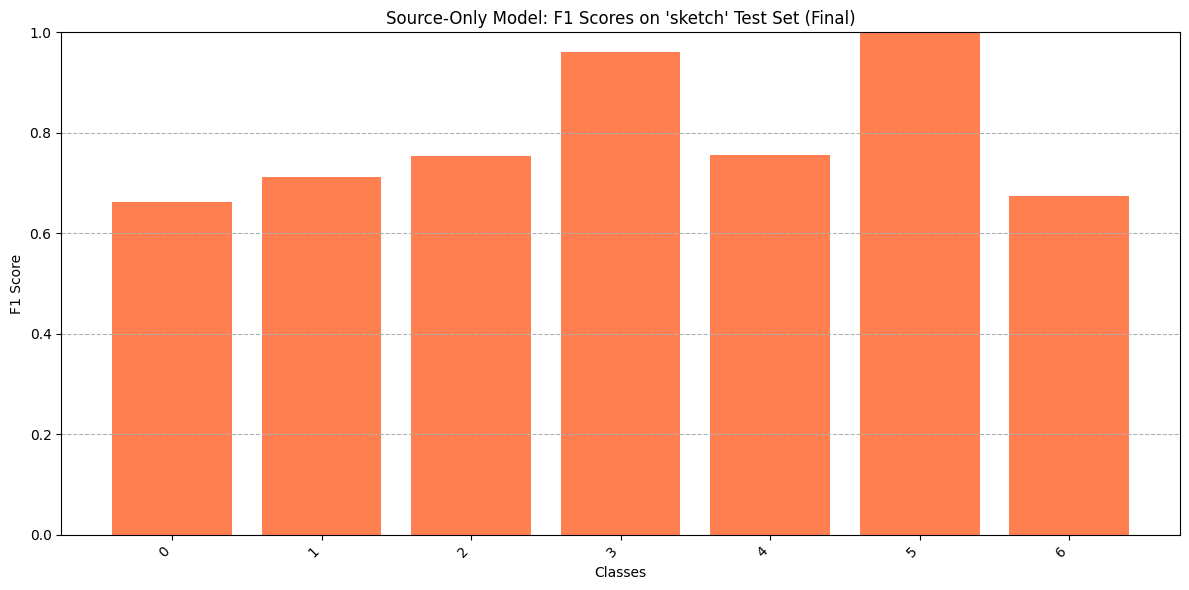


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


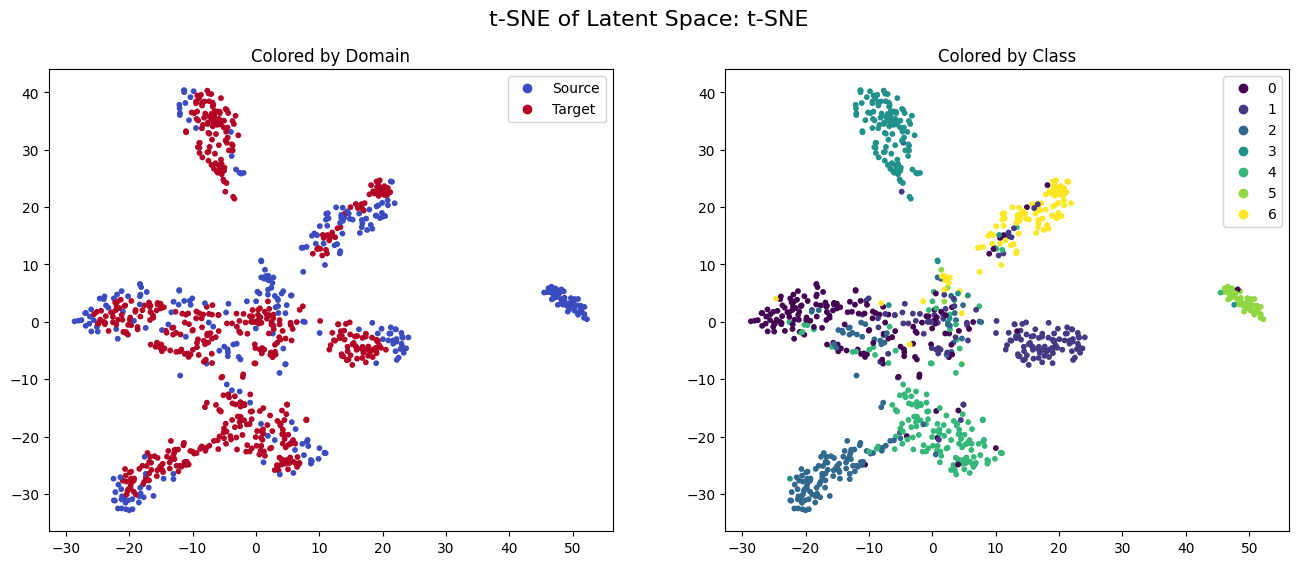


✅ Final Analysis Complete.
Final Accuracy on Combined Source Test Set: 86.36%
Final Accuracy on Target ('sketch') Test Set: 76.10%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7800



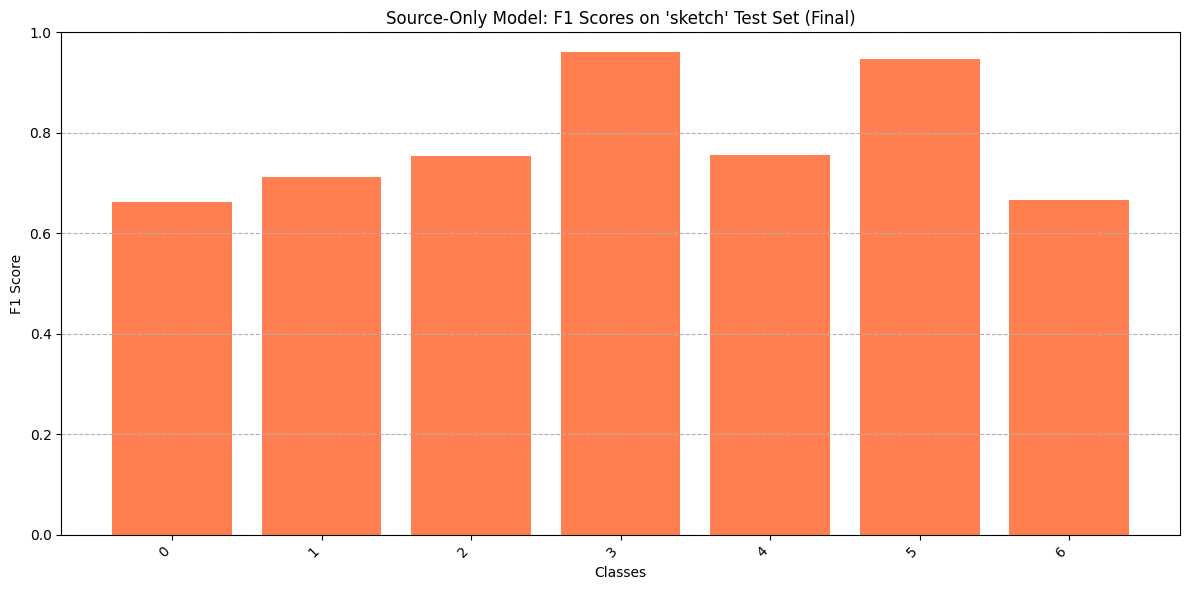


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


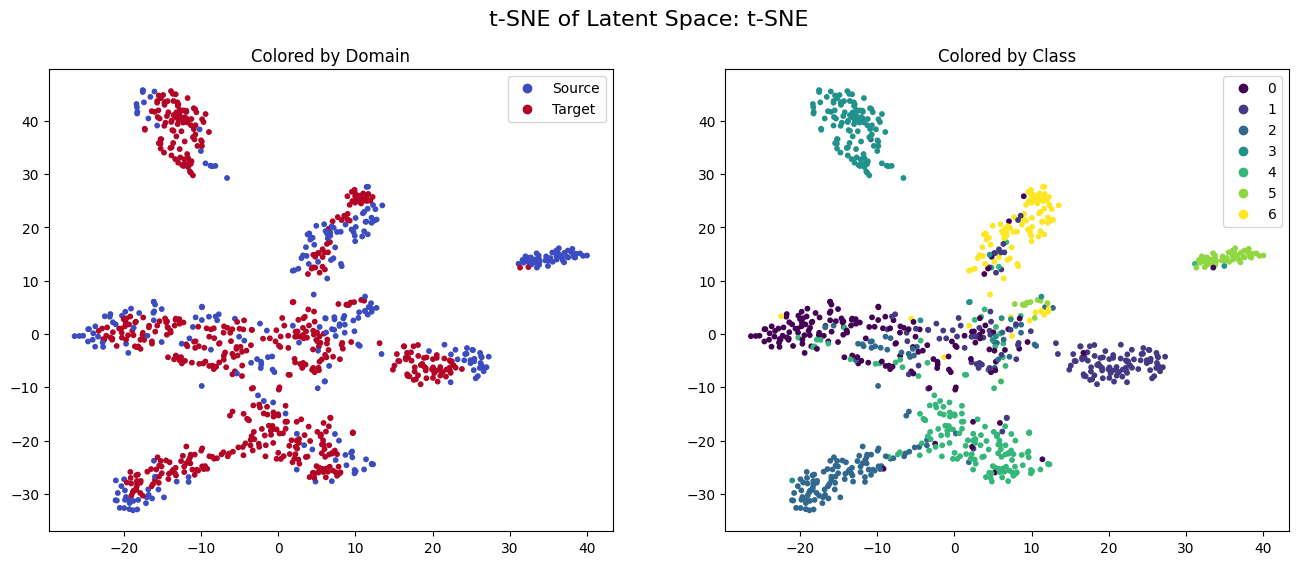


✅ Final Analysis Complete.


In [ ]:
tester(cdan_reload.to('cuda') , source_test_loader,stress_loader_target)
tester(cdan_reload.to('cuda') , source_test_loader,target_test_loader)

In [ ]:
#tester(dann_model , source_test_loader,stress_loader_target)
tester(dann_model , source_test_loader,target_test_loader)

Accuracy on Target Test Set: 88.96%


TypeError: unsupported format string passed to NoneType.__format__

Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 56.11%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.4192



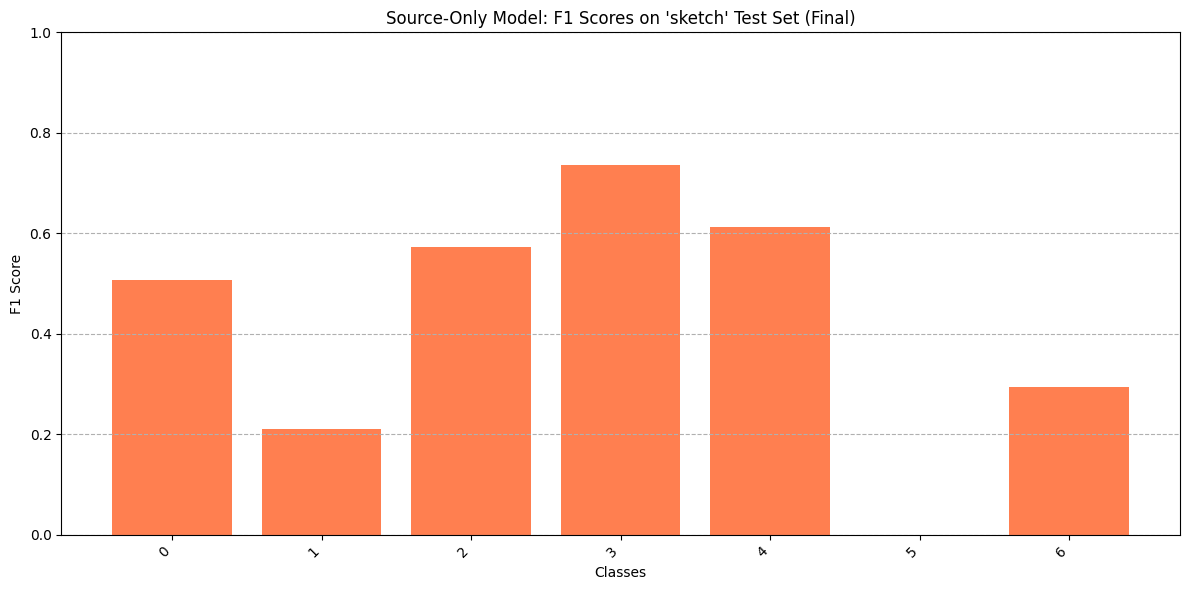


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


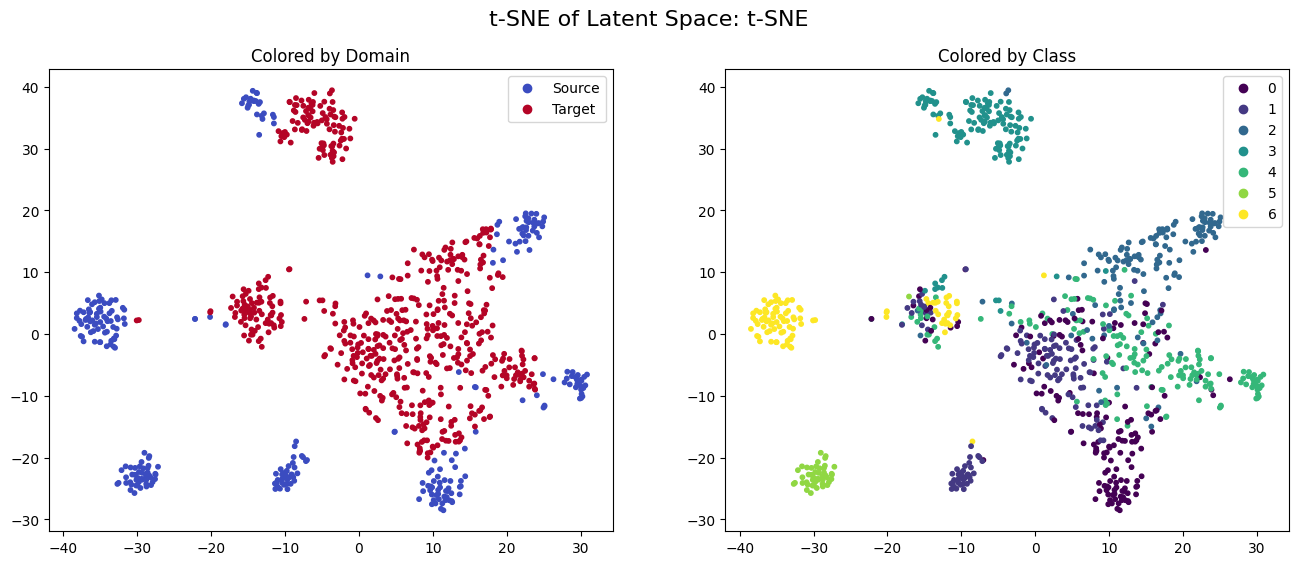


✅ Final Analysis Complete.
Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 55.25%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.4159



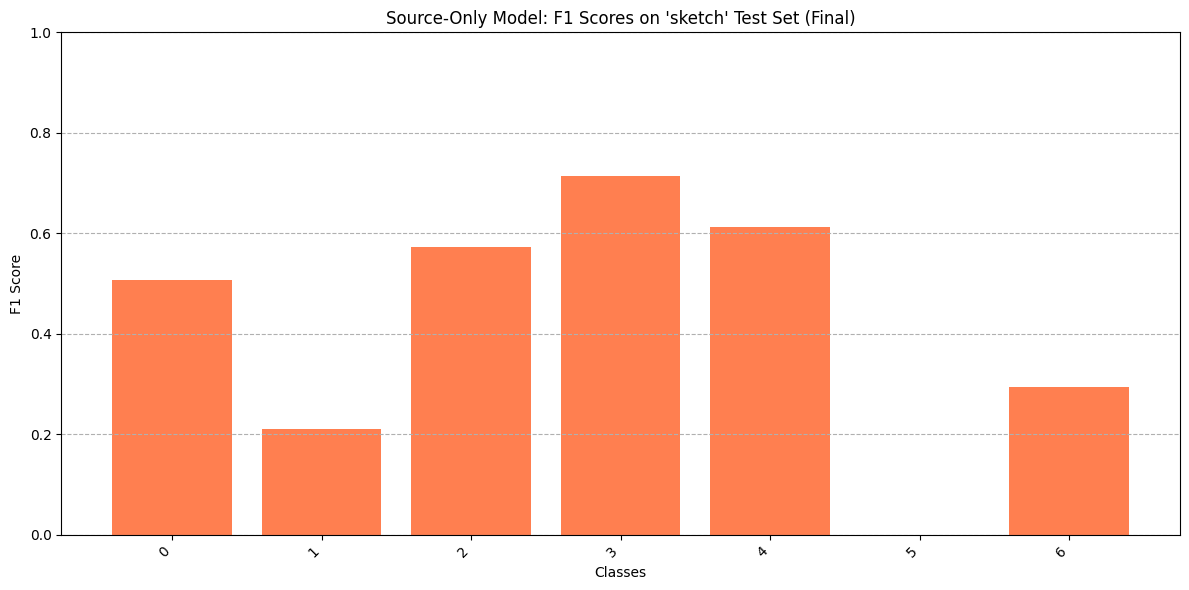


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


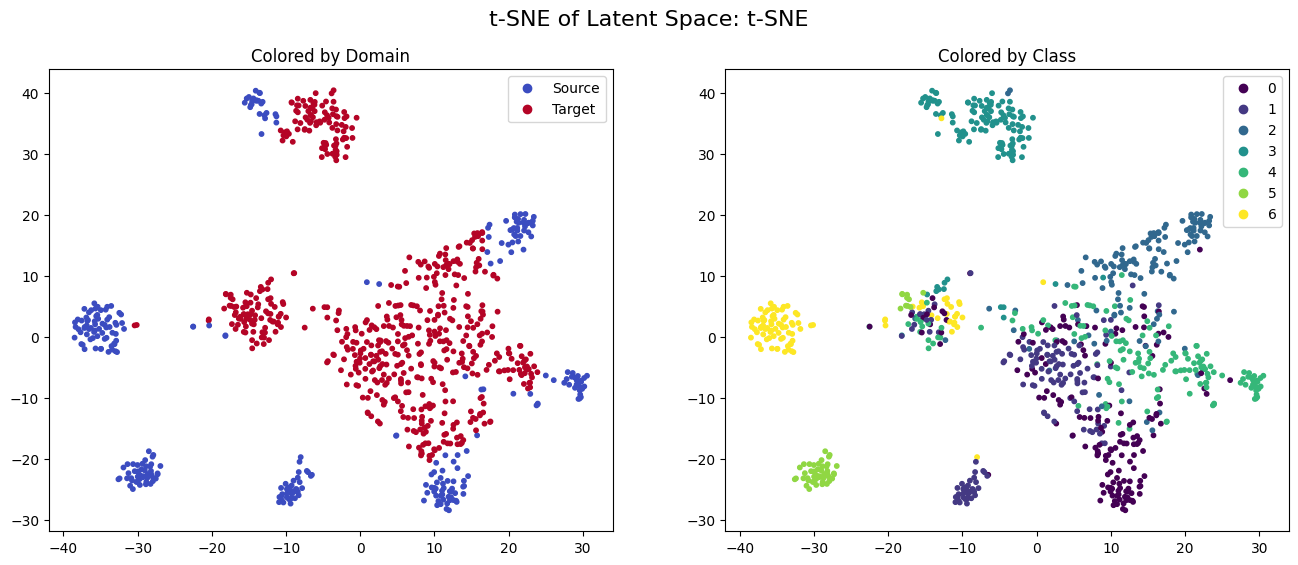


✅ Final Analysis Complete.


In [ ]:
tester(source_reload.to('cuda') , source_test_loader,stress_loader_target)
tester(source_reload.to('cuda') , source_test_loader,target_test_loader)

In [ ]:
class_names = np.arange(7)

Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 71.94%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7555



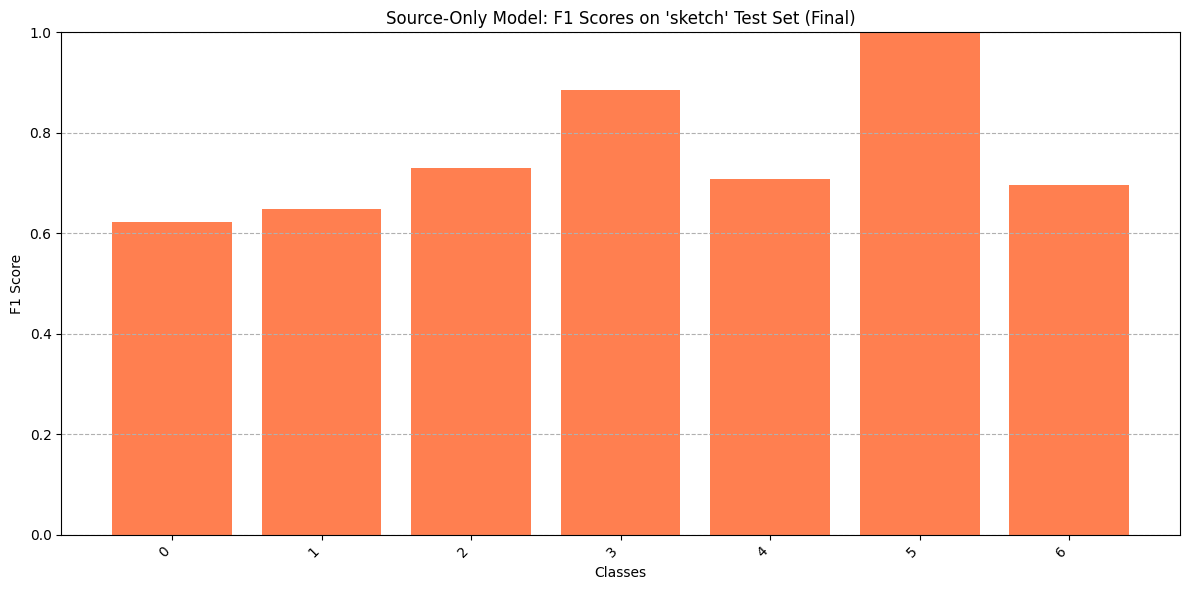


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


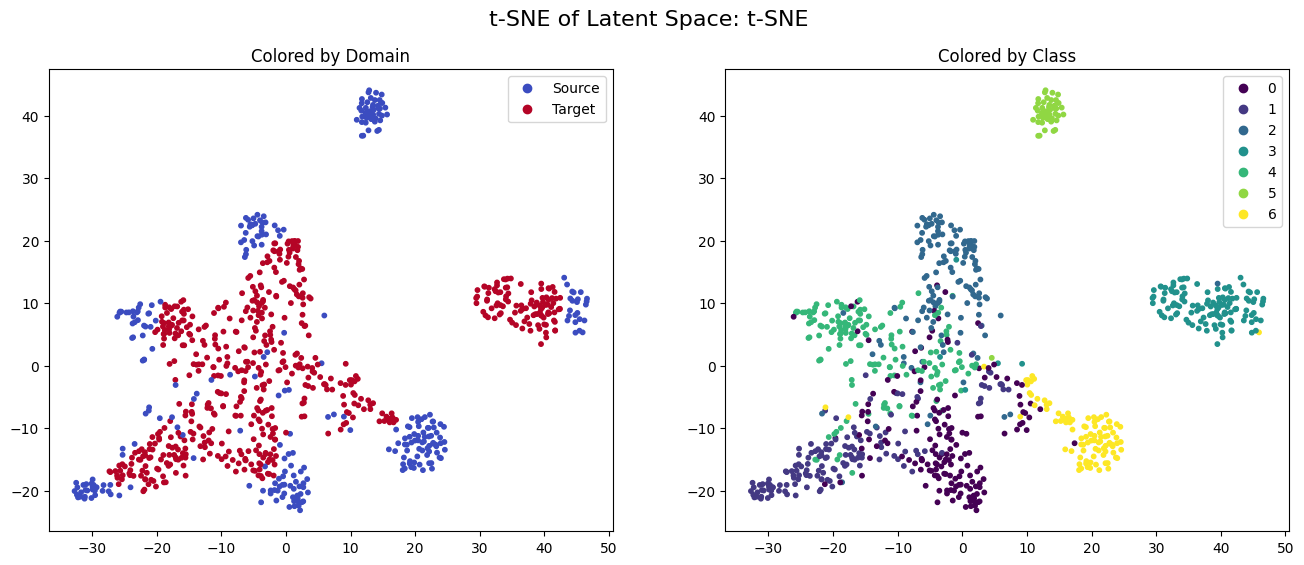


✅ Final Analysis Complete.
Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 72.03%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7385



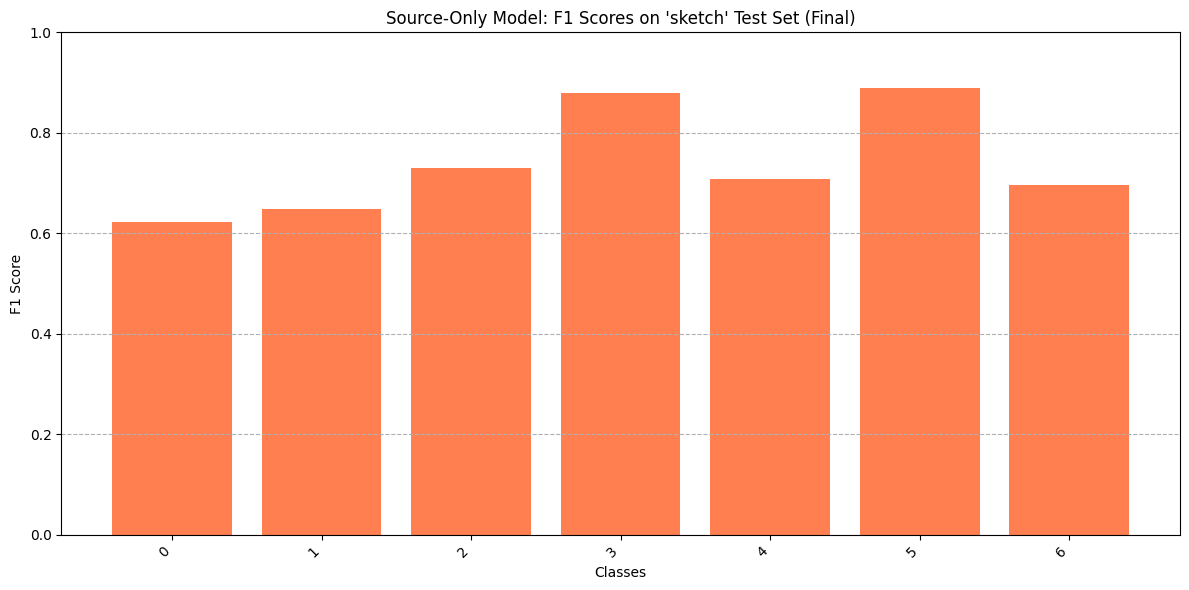


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for t-SNE... (This may take a minute)


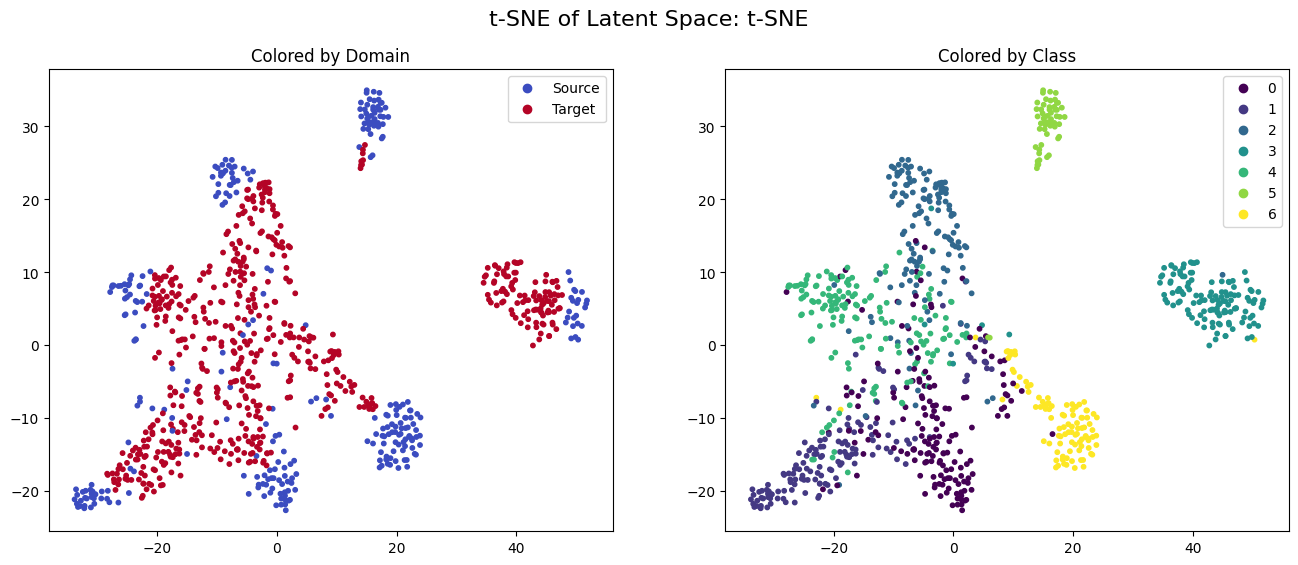


✅ Final Analysis Complete.


In [ ]:
tester(fine_tuning_model.to('cuda') , source_test_loader,stress_loader_target)
tester(fine_tuning_model.to('cuda') , source_test_loader,target_test_loader)

In [ ]:
class_names = np.arange(7)


🔍 Evaluating MMD Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 72.88%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7528



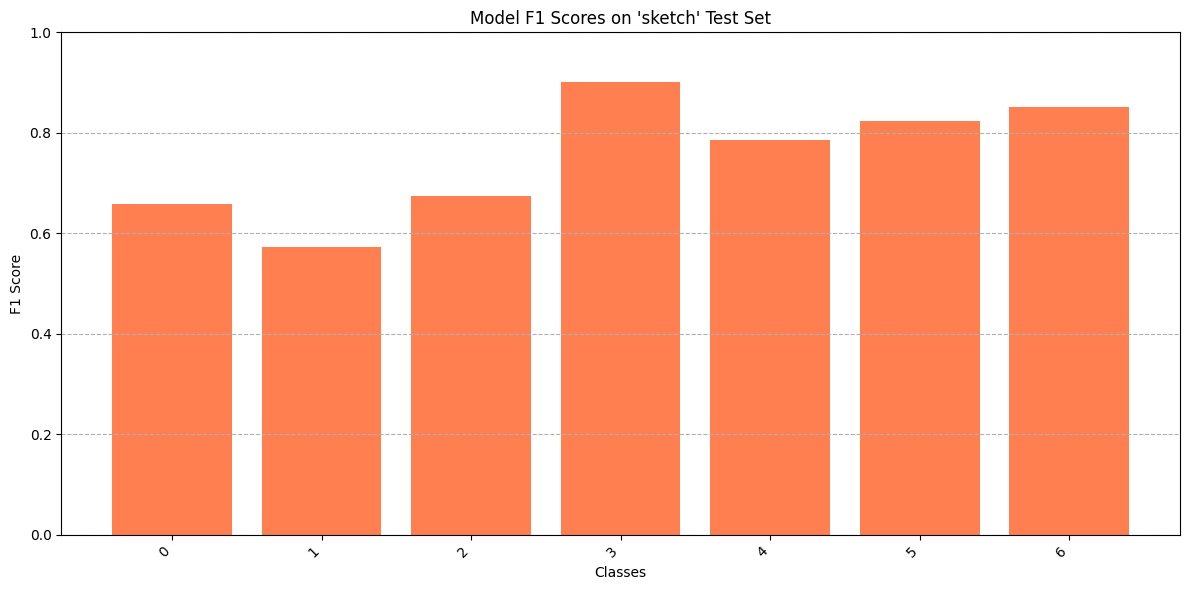


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


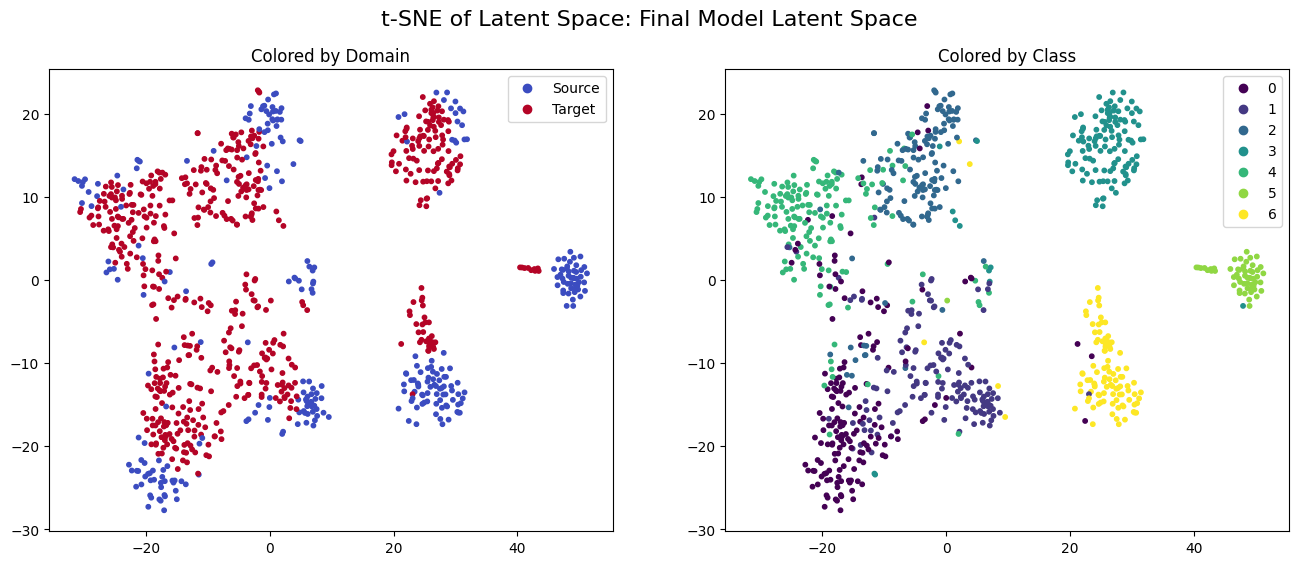


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 72.81%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.6362



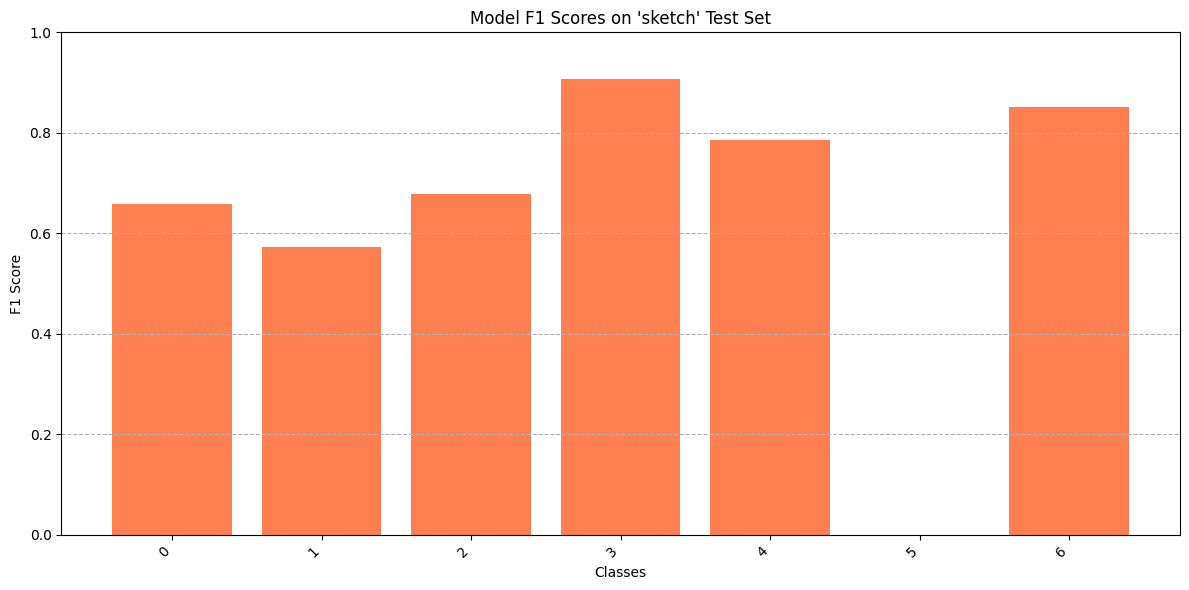


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


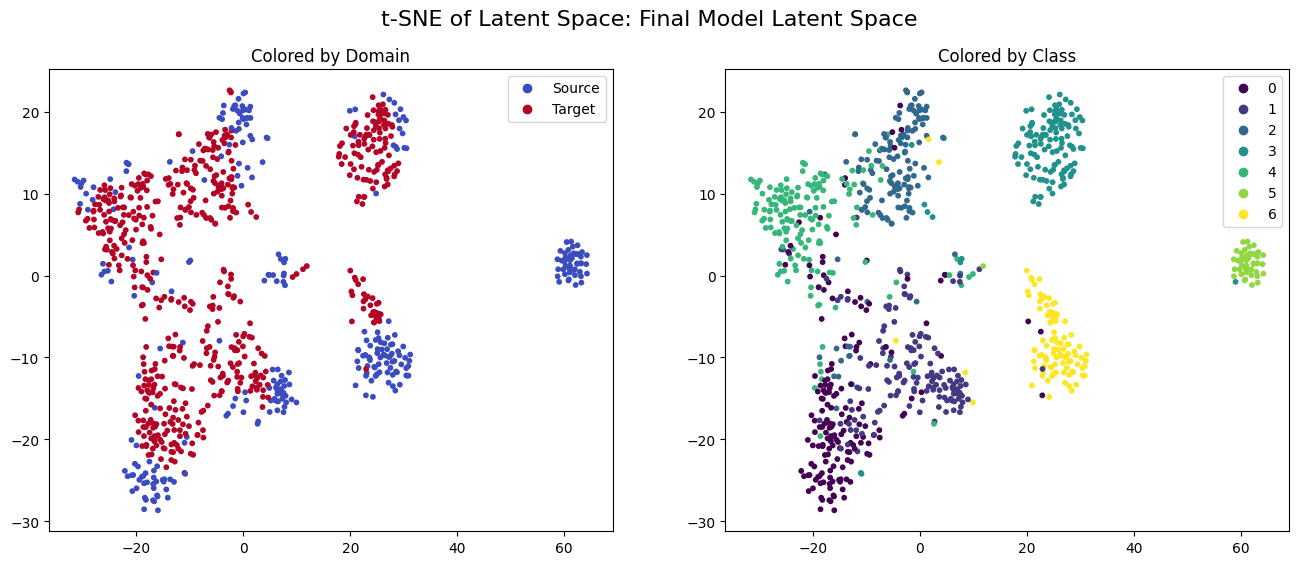


✅ Final Analysis Complete.

🔍 Evaluating DANN Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 88.96%
Final Accuracy on Target ('sketch') Test Set: 75.08%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7767



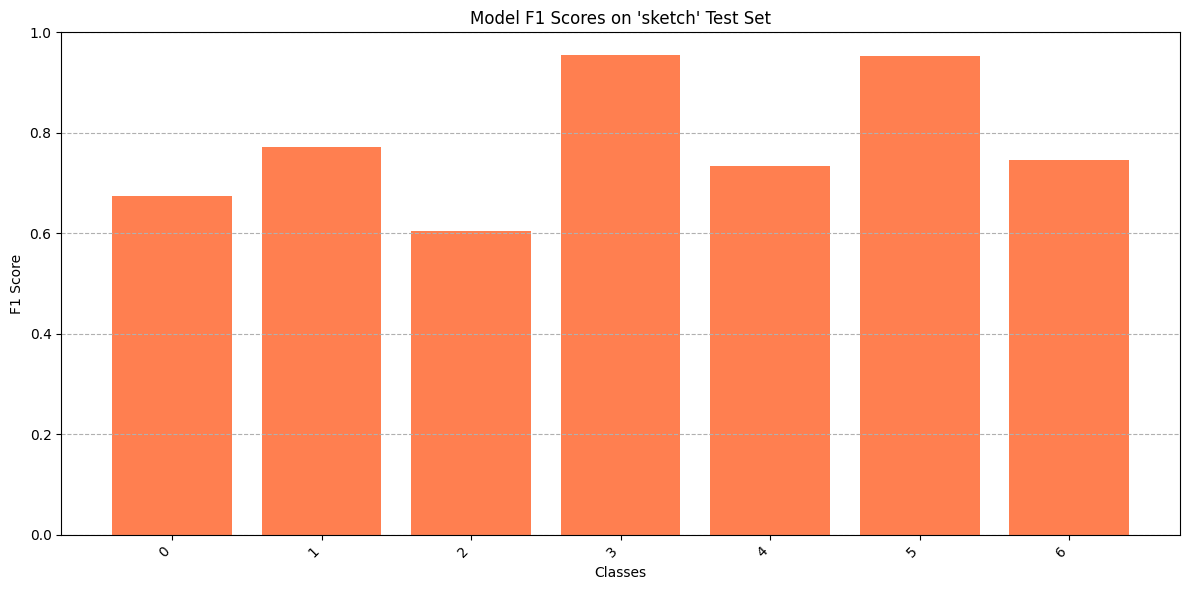


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


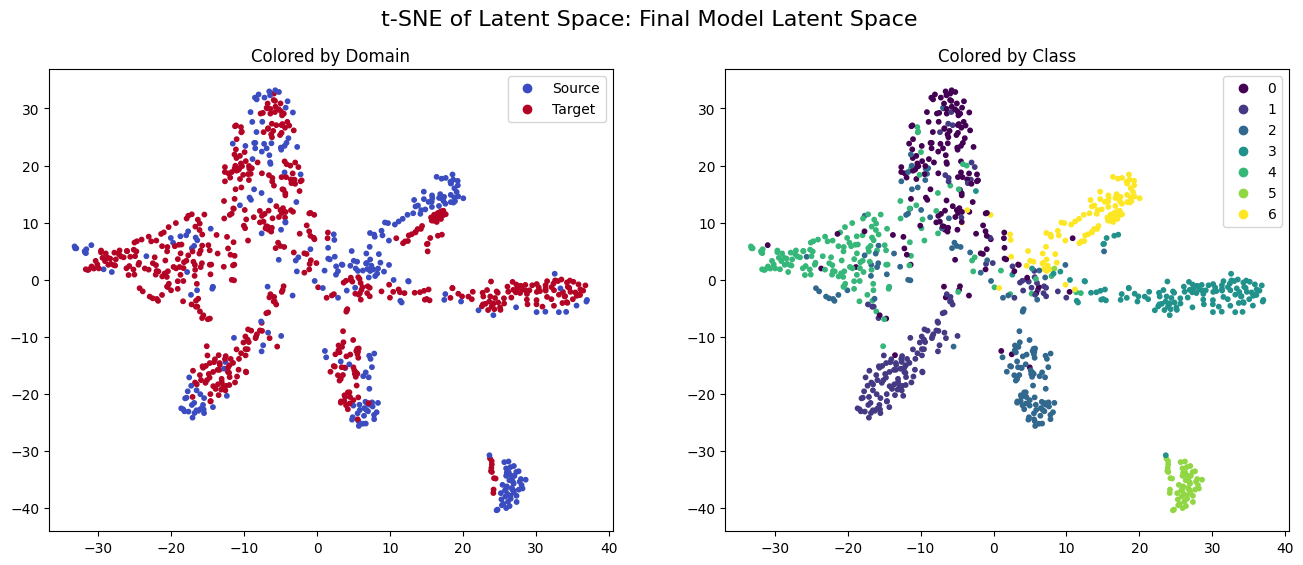


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 88.96%
Final Accuracy on Target ('sketch') Test Set: 74.70%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7359



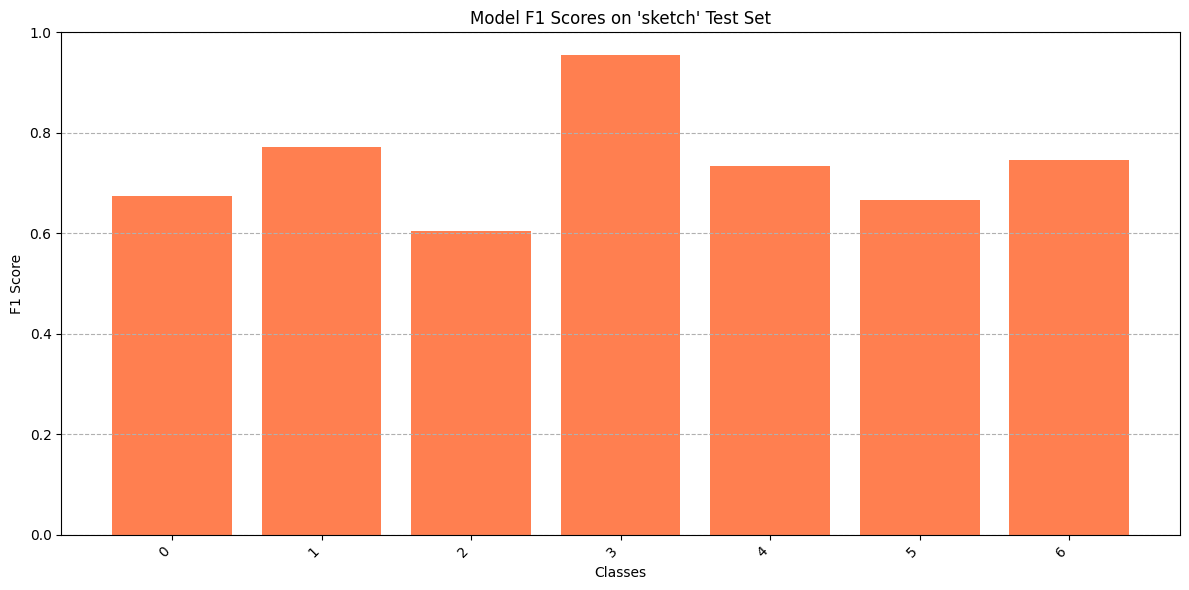


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


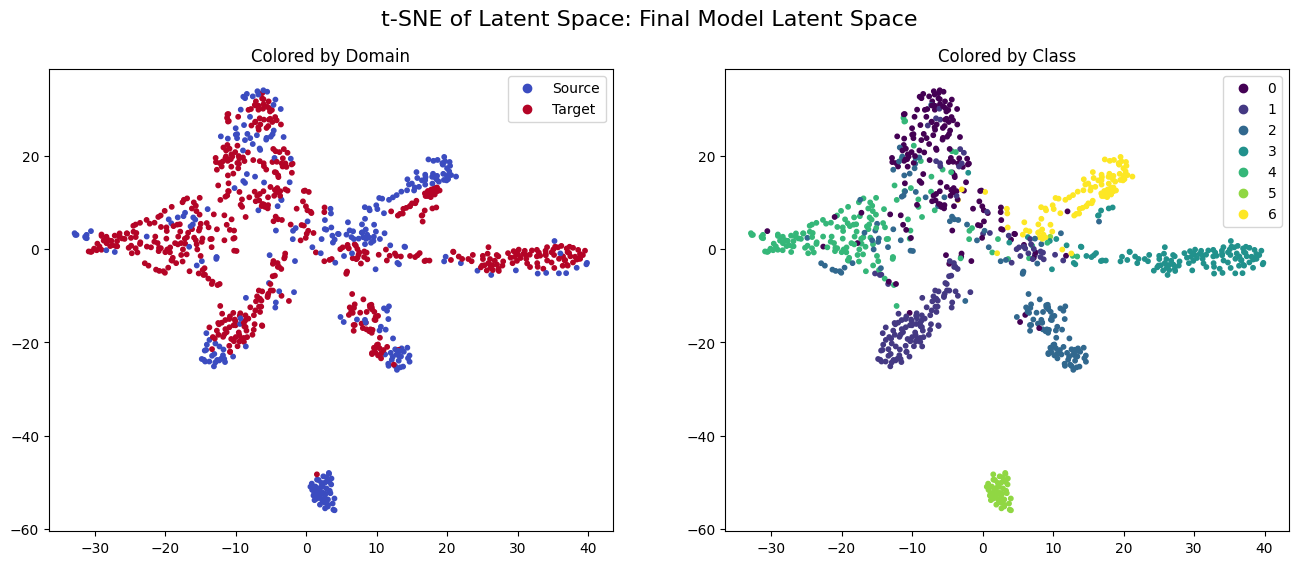


✅ Final Analysis Complete.

🔍 Evaluating Source-only Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 55.25%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.4159



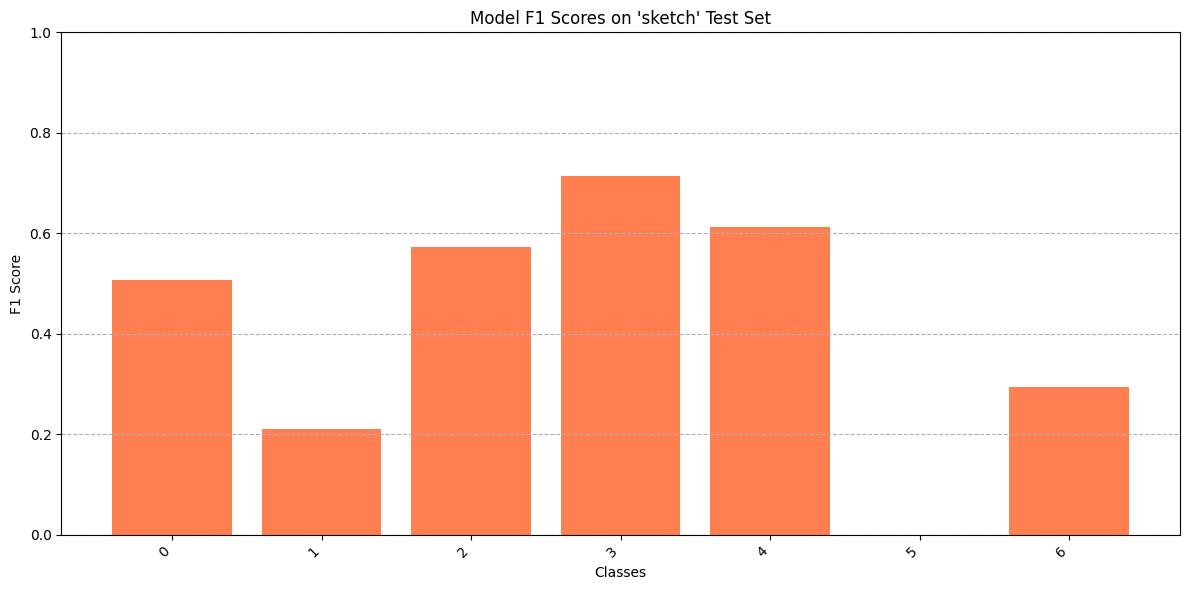


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


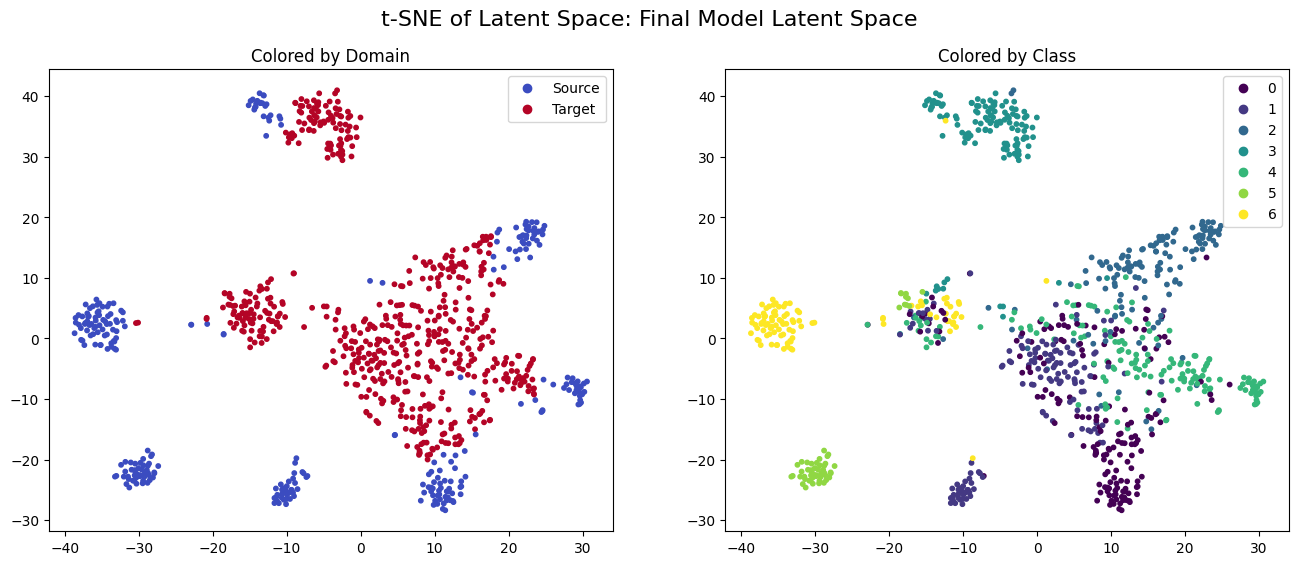


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 56.11%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.4192



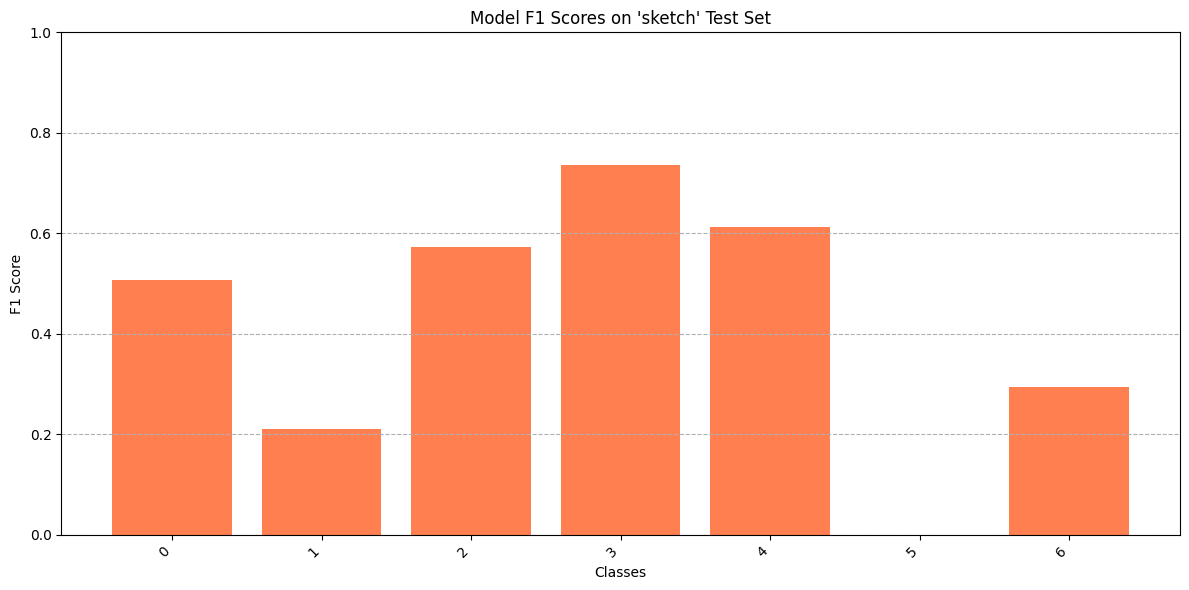


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


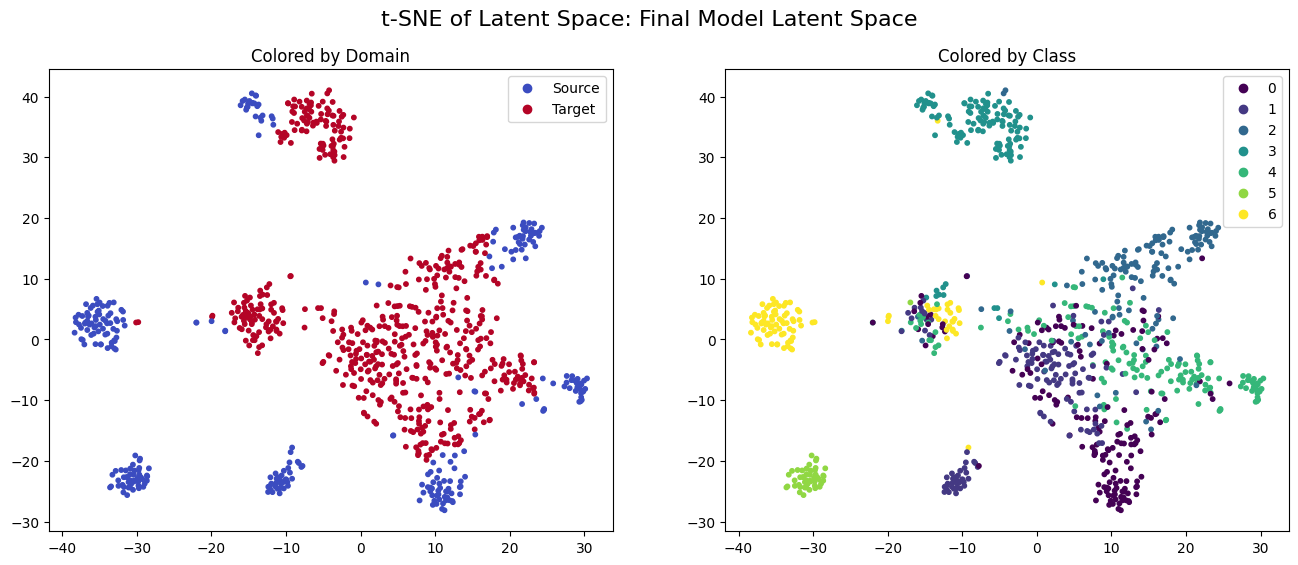


✅ Final Analysis Complete.

🔍 Evaluating Fine-tuned Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 72.03%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7385



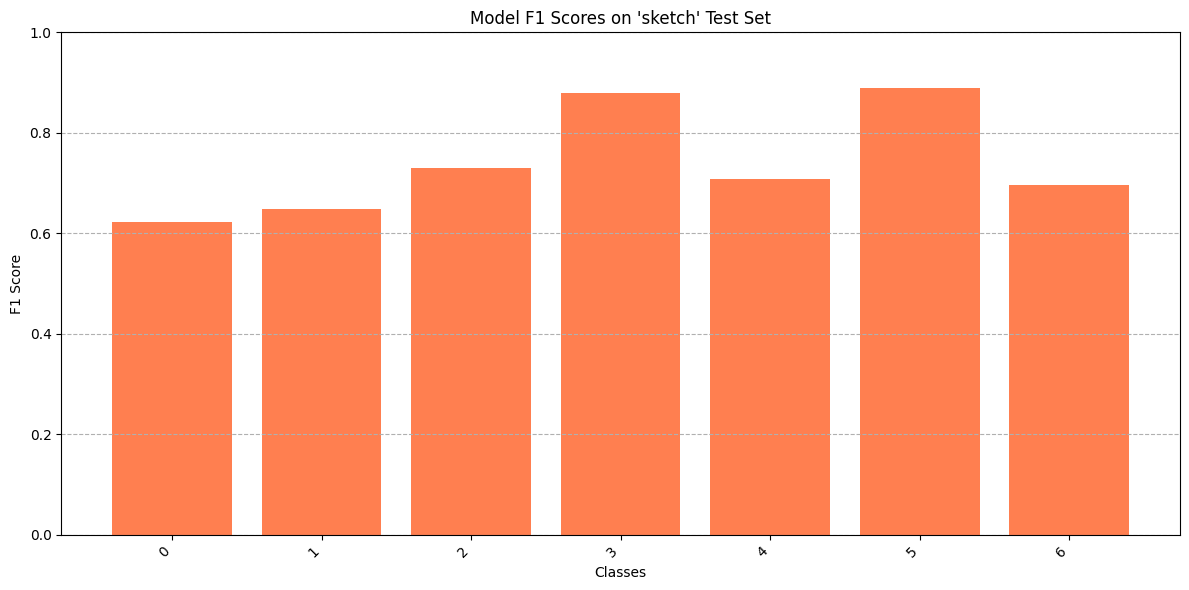


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


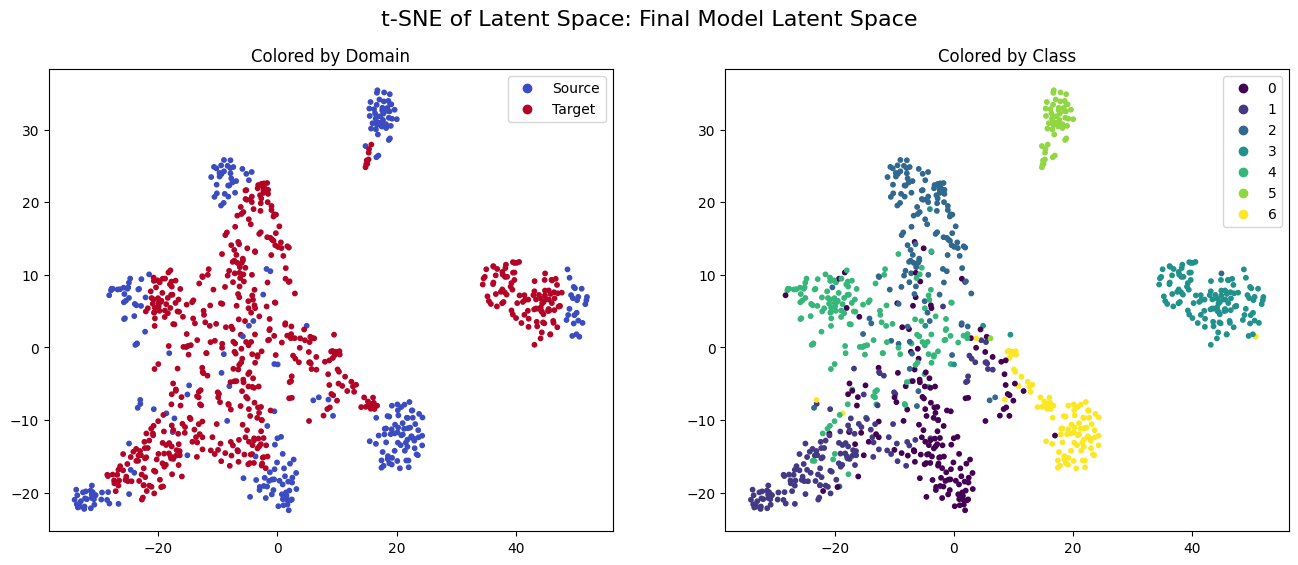


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 71.94%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7555



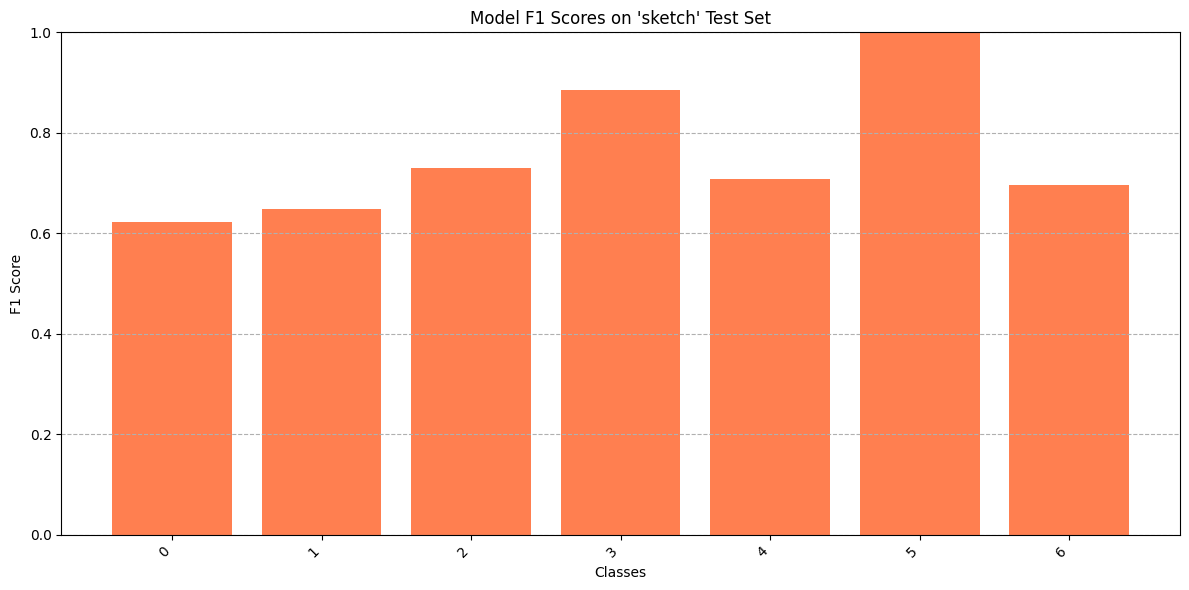


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


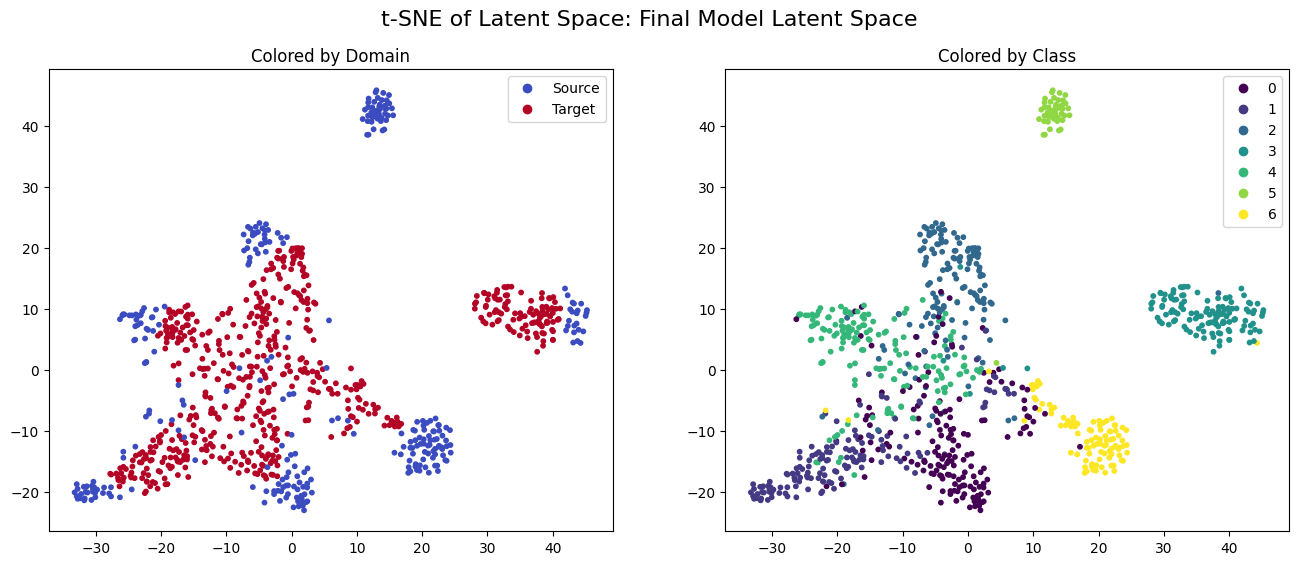


✅ Final Analysis Complete.


In [ ]:
# --- Evaluation Cell ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "MMD": mmd_reload.to(device),
    "DANN": dann_model.to(device),
    "Source-only": source_reload.to(device),
    "Fine-tuned": fine_tuning_model.to(device)
}

loaders = {
    "Target": target_test_loader,
    "Stress": stress_loader_target,
}

# Loop through models and evaluate on each test loader
for model_name, model in models.items():
    print(f"\n🔍 Evaluating {model_name} Model")
    for loader_name, loader in loaders.items():
        print(f"  • Dataset: {loader_name}")
        tester(model, source_test_loader, loader, device, class_names, TARGET_DOMAIN)



🔍 Evaluating MMD Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 72.88%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7528



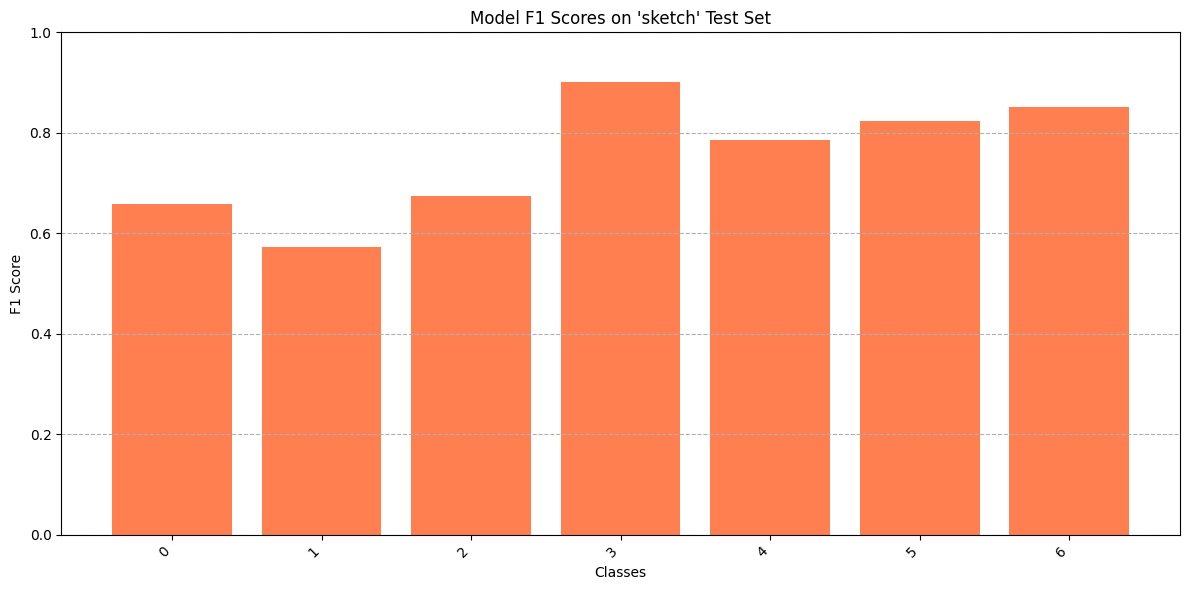


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


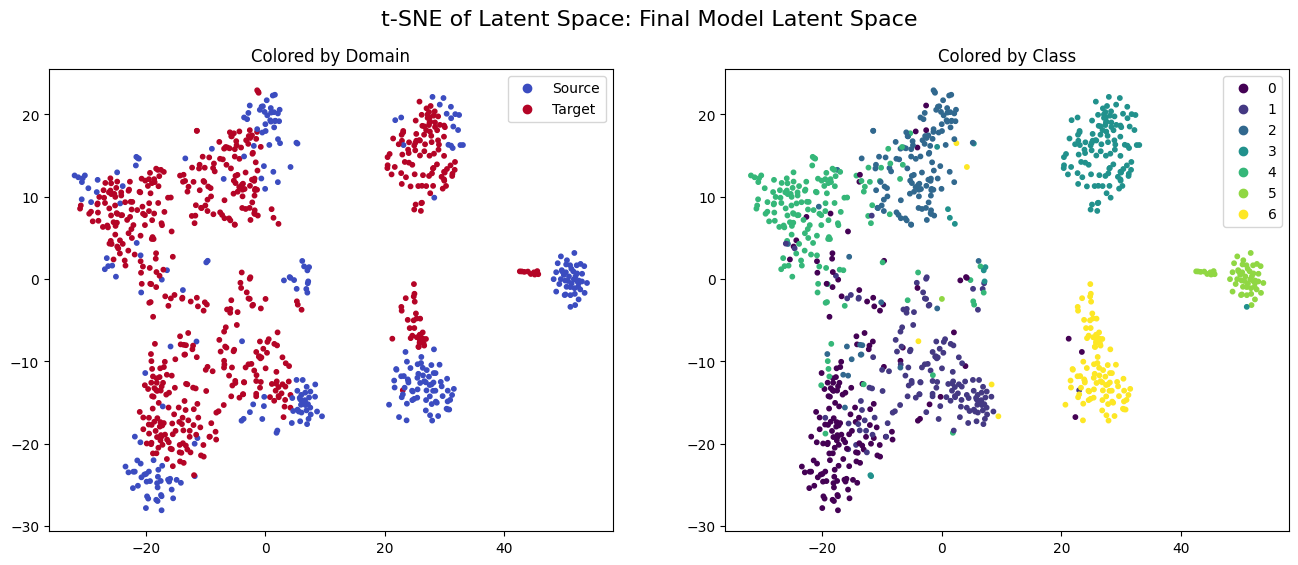


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 91.56%
Final Accuracy on Target ('sketch') Test Set: 70.62%


Calculating F1 Scores:   0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7403



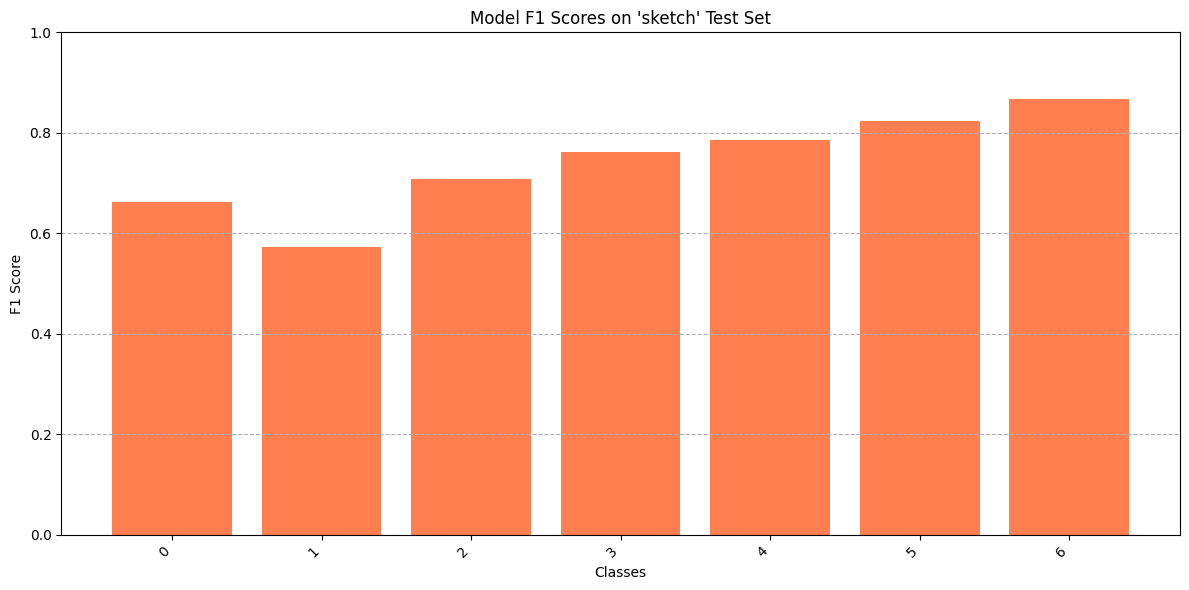


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/16 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


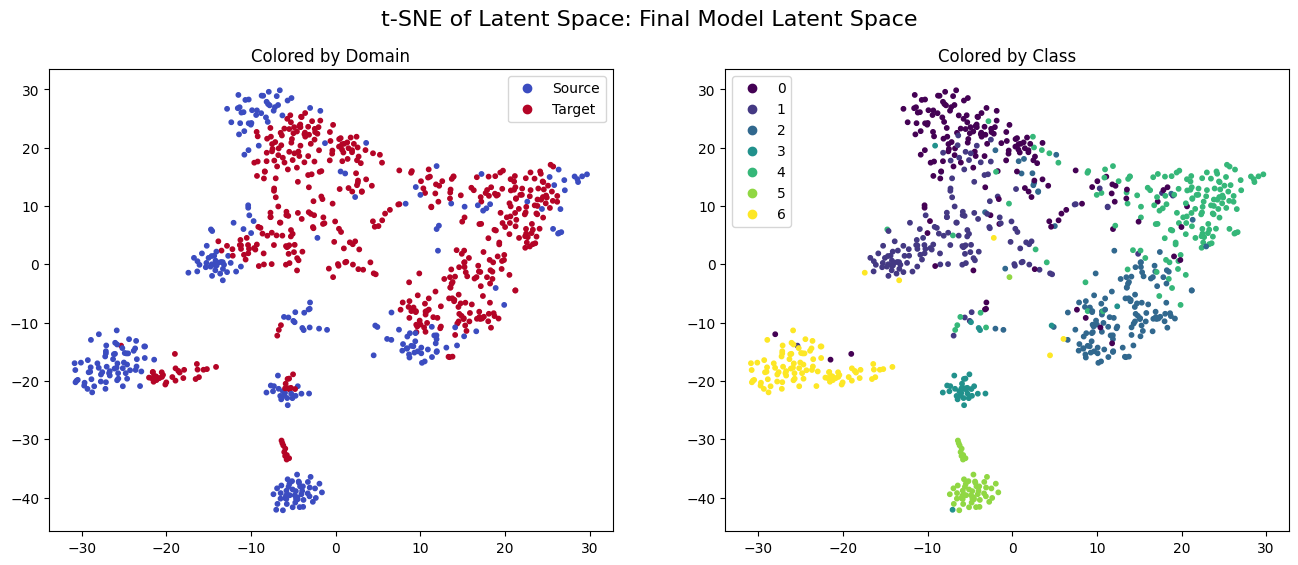


✅ Final Analysis Complete.

🔍 Evaluating DANN Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 88.96%
Final Accuracy on Target ('sketch') Test Set: 75.08%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7767



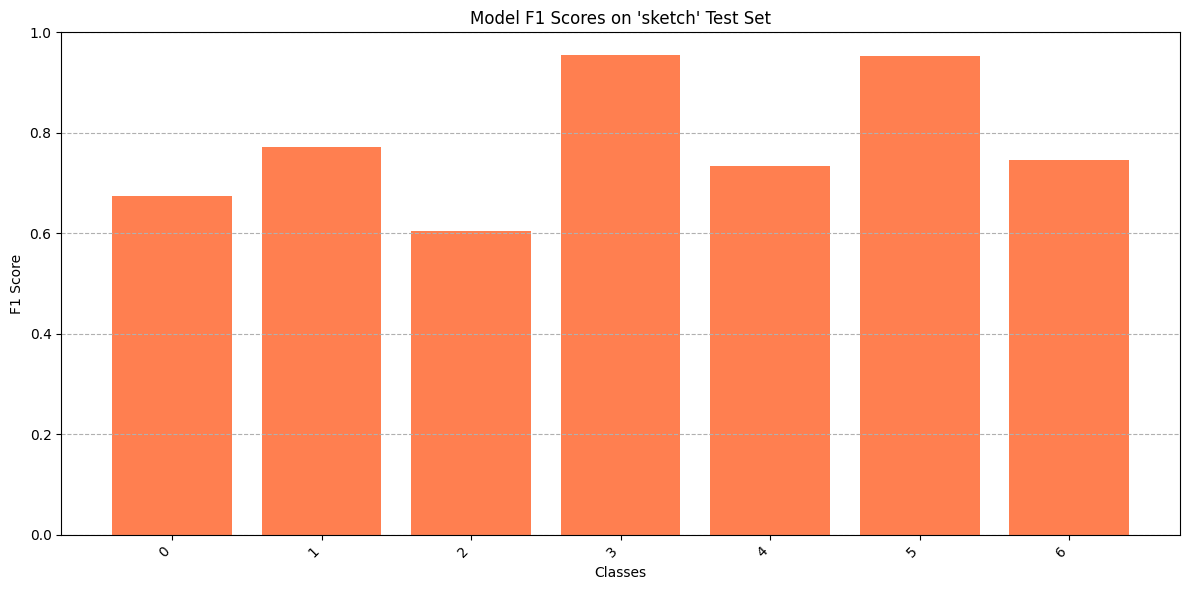


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


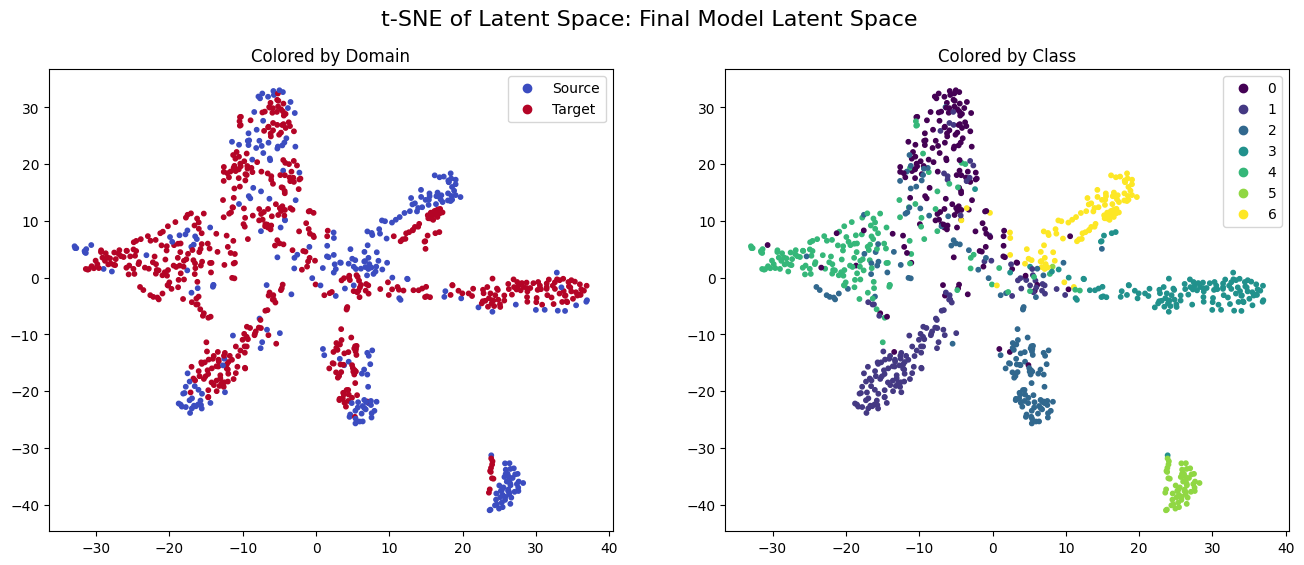


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 88.96%
Final Accuracy on Target ('sketch') Test Set: 71.63%


Calculating F1 Scores:   0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7734



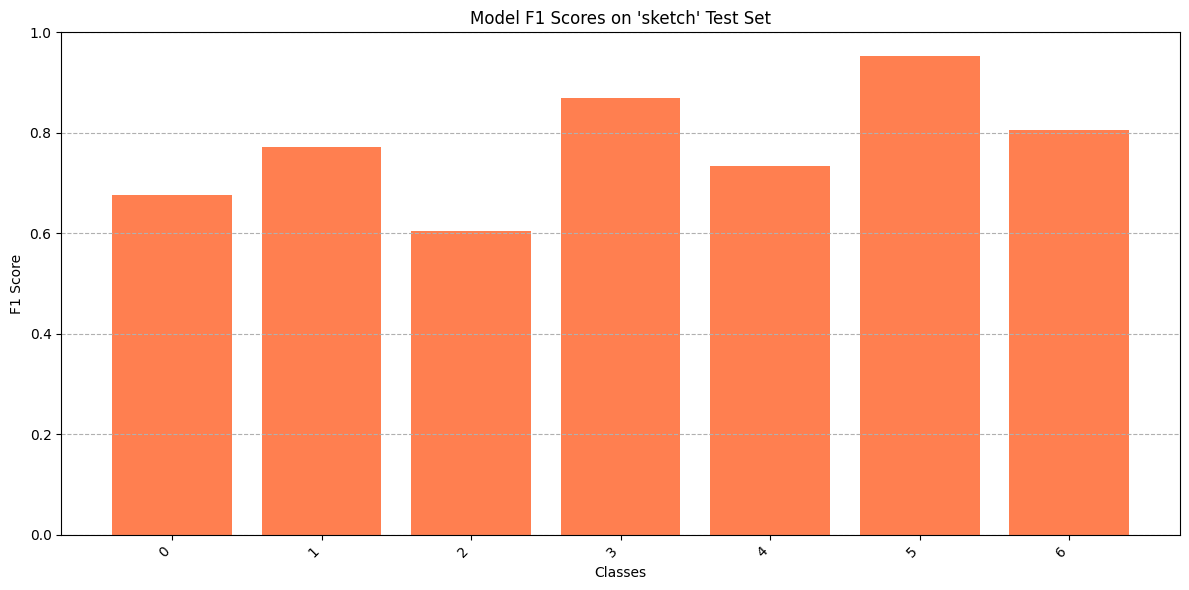


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/16 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


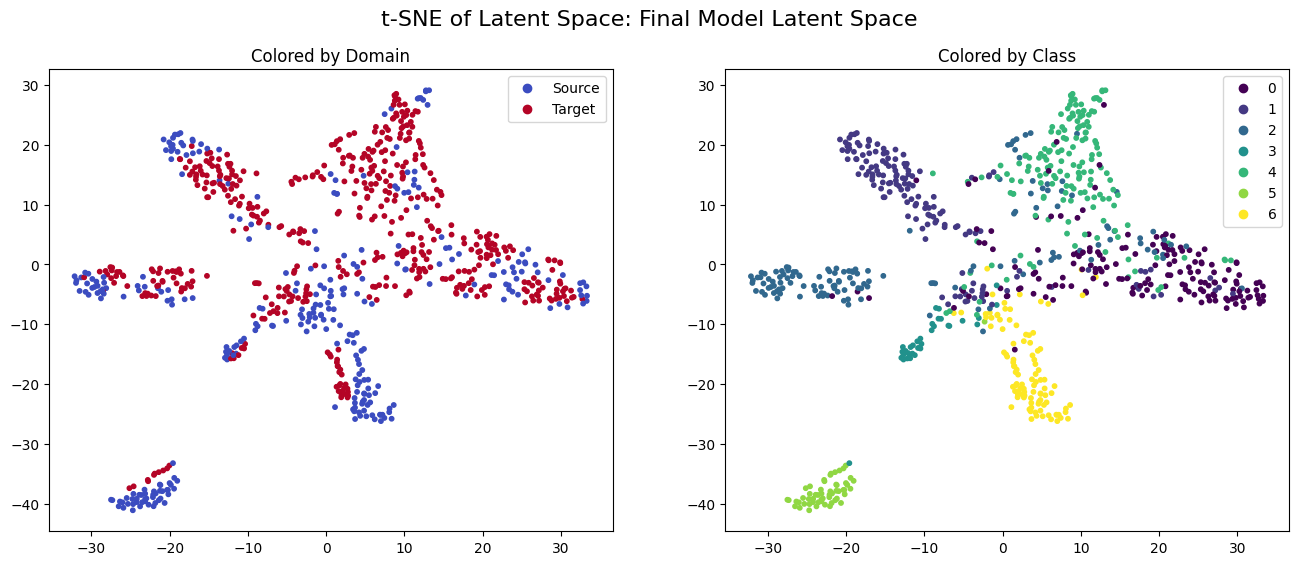


✅ Final Analysis Complete.

🔍 Evaluating Source-only Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 55.25%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.4159



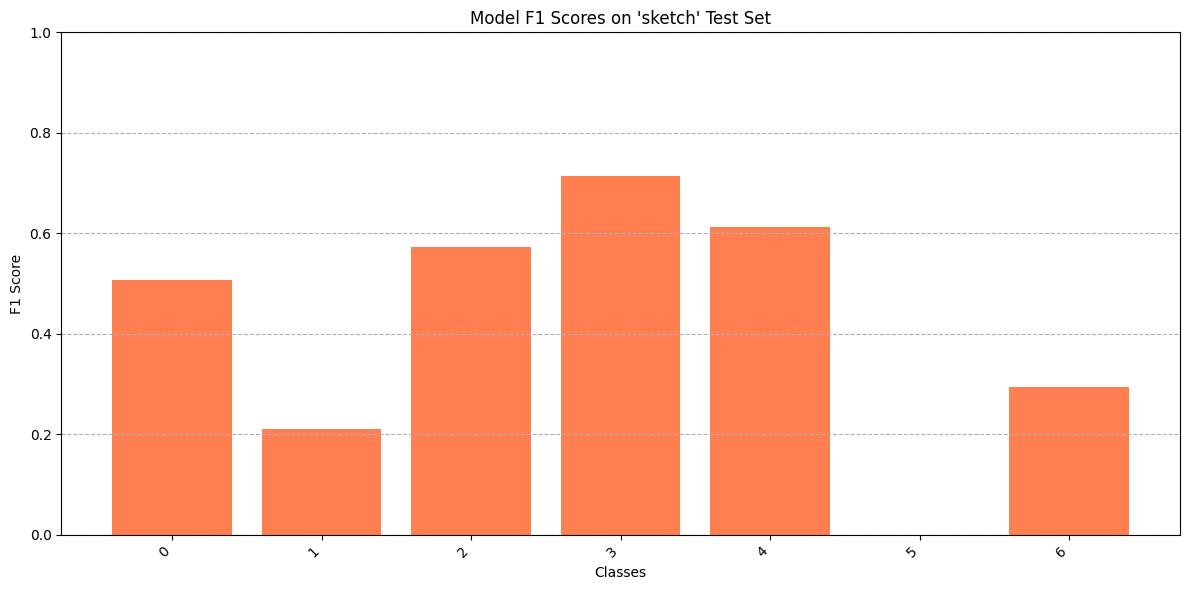


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


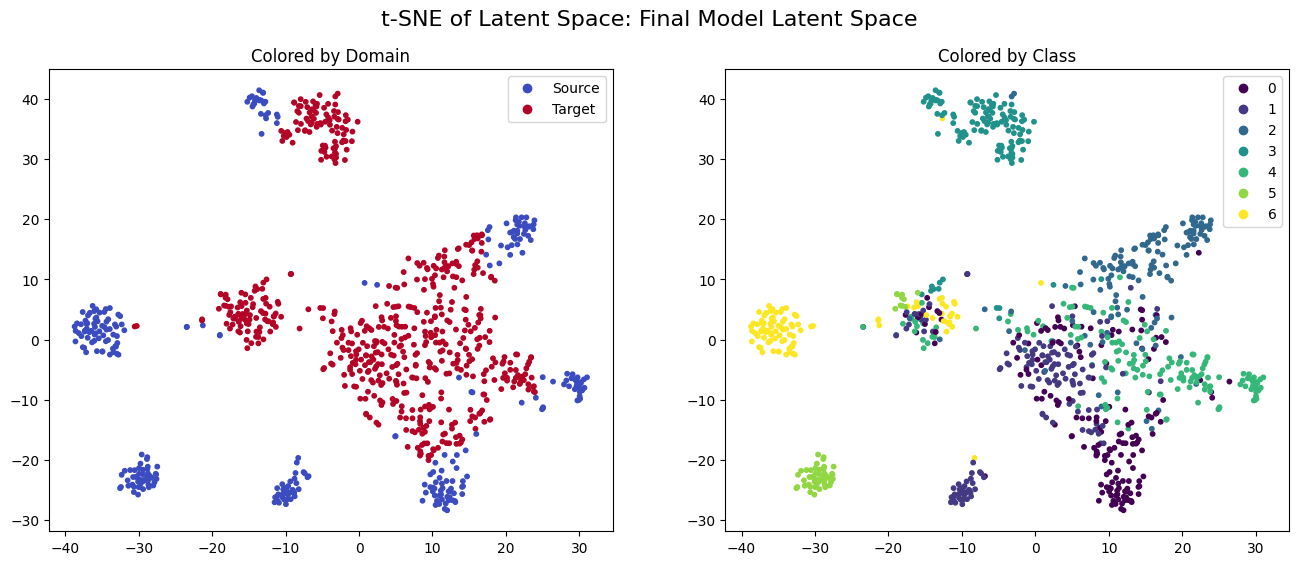


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 95.45%
Final Accuracy on Target ('sketch') Test Set: 47.08%


Calculating F1 Scores:   0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.3426



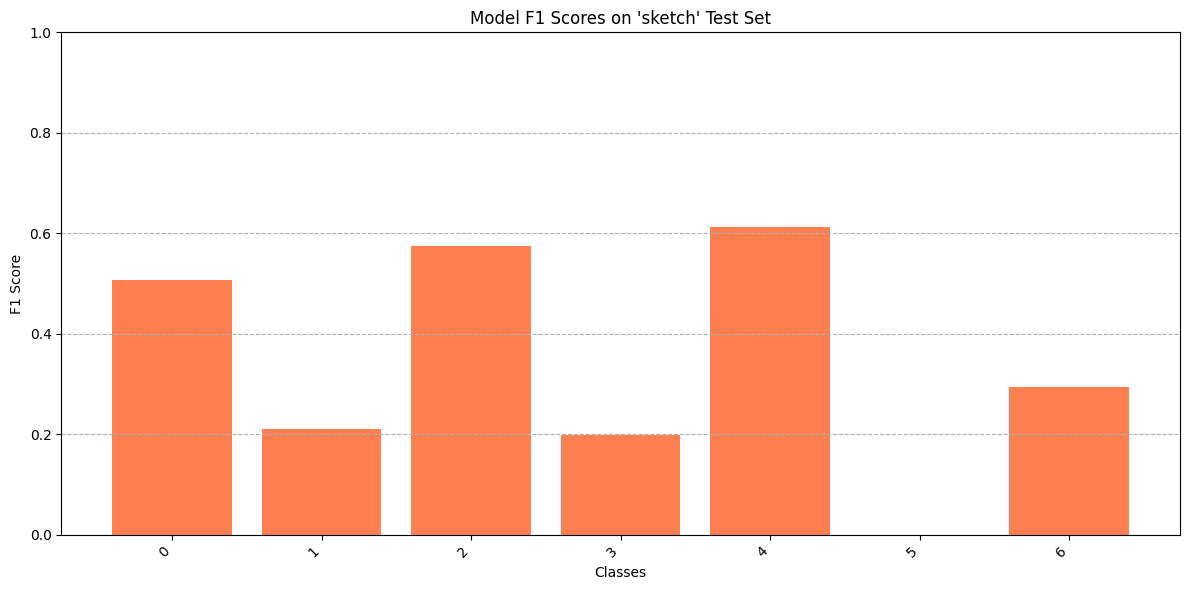


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/16 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


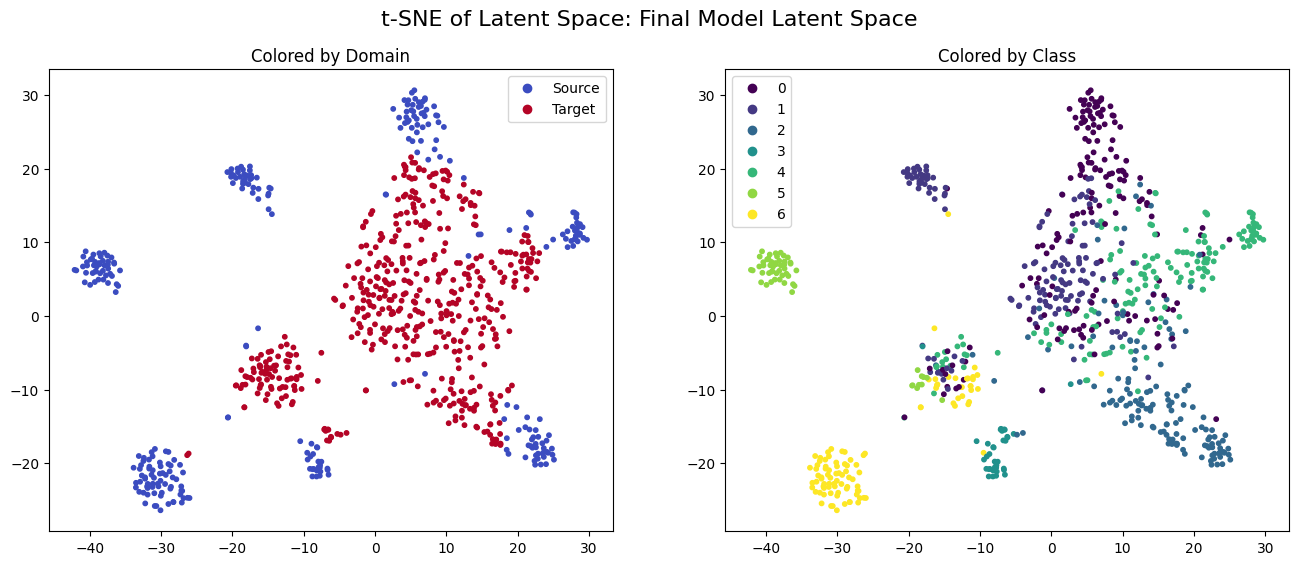


✅ Final Analysis Complete.

🔍 Evaluating Fine-tuned Model
  • Dataset: Target


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 72.03%


Calculating F1 Scores:   0%|          | 0/19 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.7385



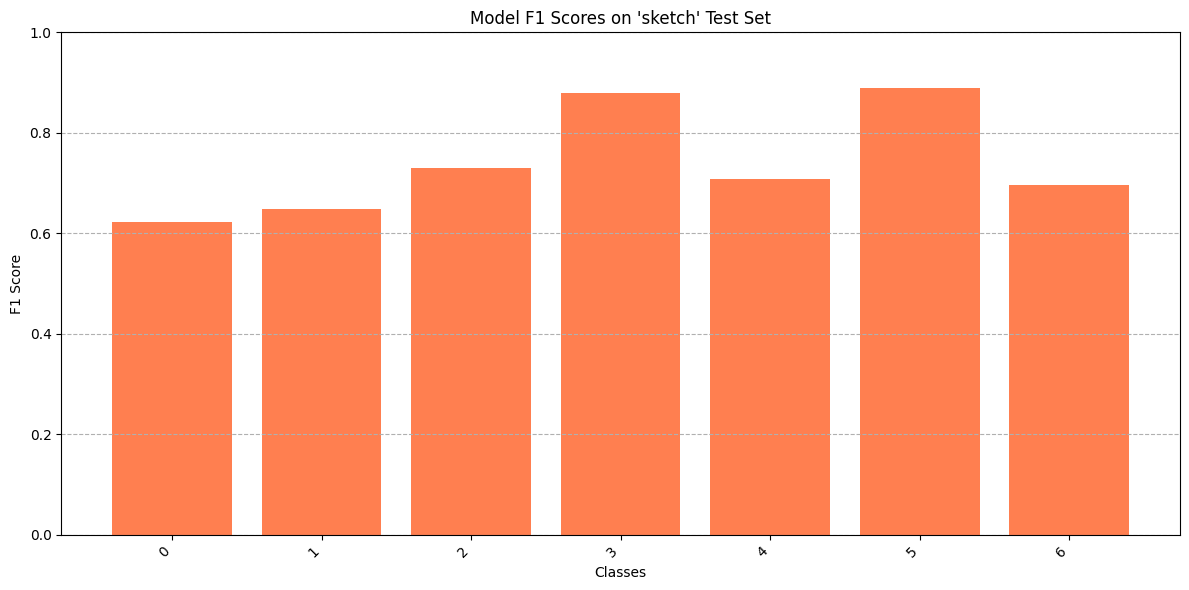


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/19 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


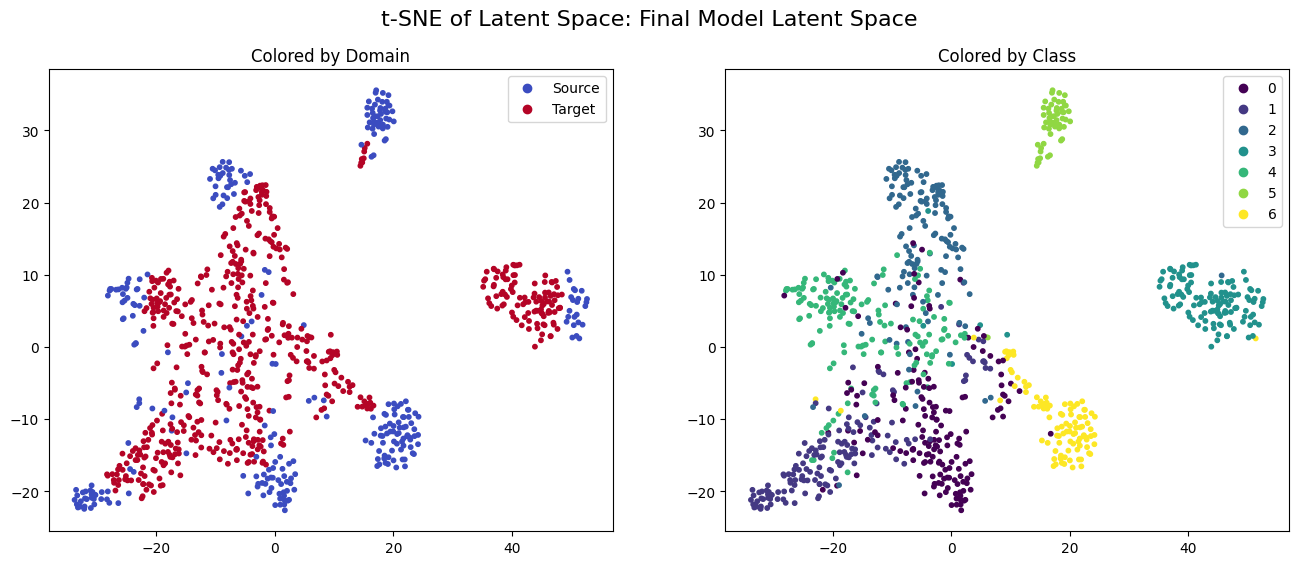


✅ Final Analysis Complete.
  • Dataset: Stress


--- Running Full Evaluation ---
Final Accuracy on Combined Source Test Set: 96.10%
Final Accuracy on Target ('sketch') Test Set: 67.20%


Calculating F1 Scores:   0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Score on 'sketch' Test Set: 0.6761



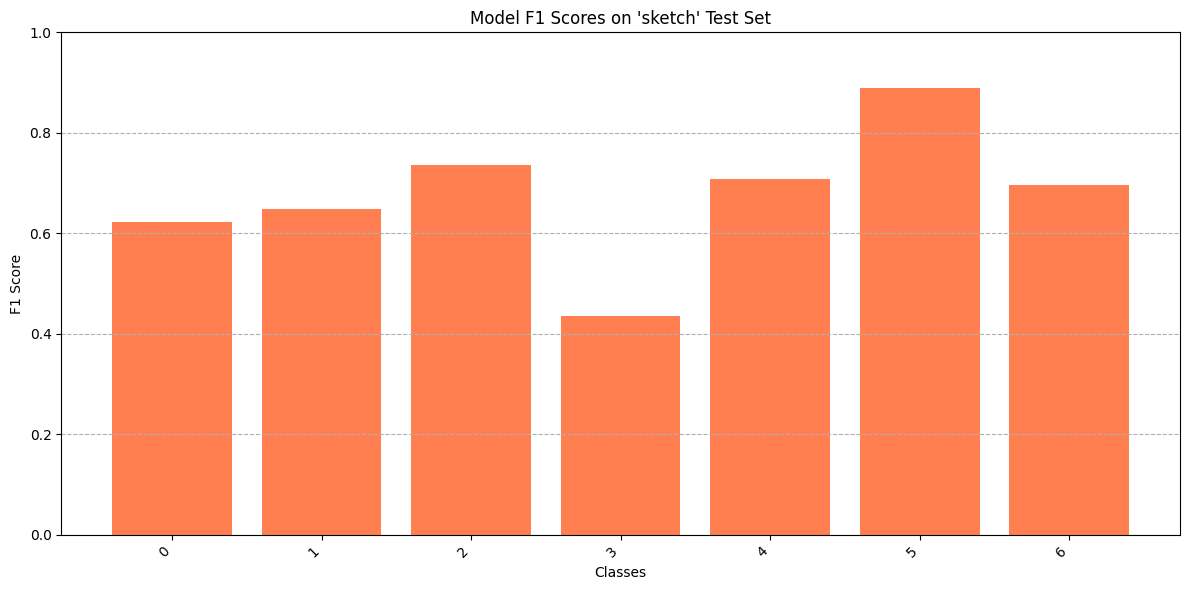


--- Generating t-SNE Plot of Final Latent Features ---
Extracting source test features...


  0%|          | 0/10 [00:00<?, ?it/s]

Extracting target test features...


  0%|          | 0/16 [00:00<?, ?it/s]


Running t-SNE for Final Model Latent Space... (This may take a minute)


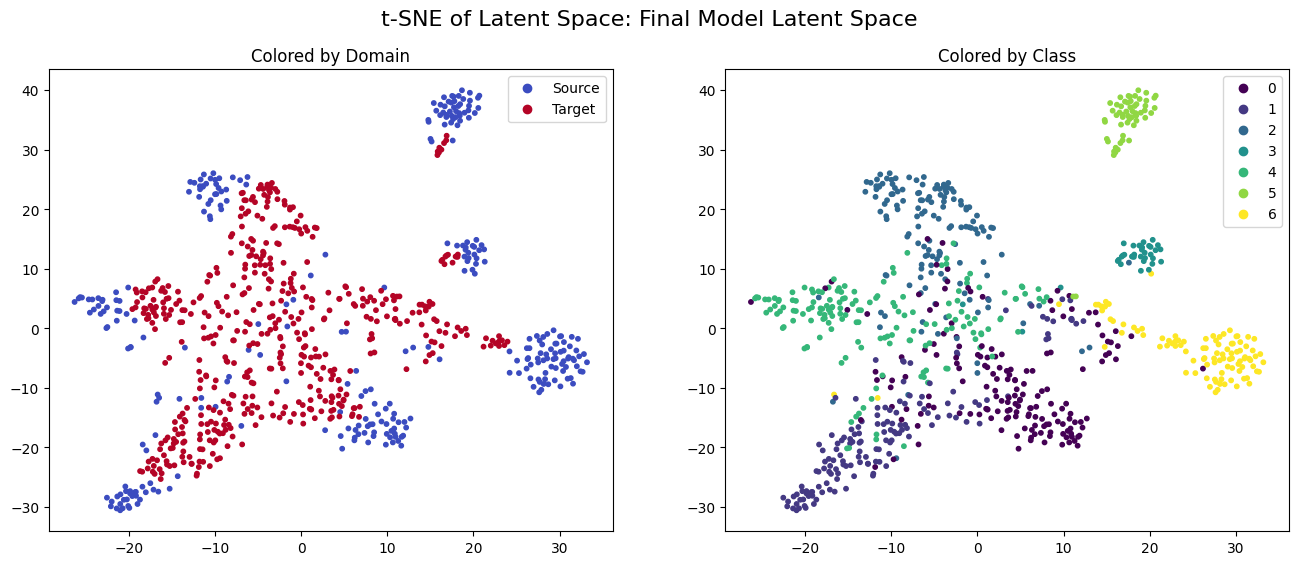


✅ Final Analysis Complete.


In [ ]:
# --- Evaluation Cell ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "MMD": mmd_reload.to(device),
    "DANN": dann_model.to(device),
    "Source-only": source_reload.to(device),
    "Fine-tuned": fine_tuning_model.to(device)
}

loaders = {
    "Target": target_test_loader,
    "Stress": stress_loader_target,
}

# Loop through models and evaluate on each test loader
for model_name, model in models.items():
    print(f"\n🔍 Evaluating {model_name} Model")
    for loader_name, loader in loaders.items():
        print(f"  • Dataset: {loader_name}")
        tester(model, source_test_loader, loader, device, class_names, TARGET_DOMAIN)
